<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Solvay/Solvay_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SOLBBEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 15:56:28,766 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 15:56:28,767 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for SOLBBEEUR
2019-08-25 15:57:13,571 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 15:58:51,901 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 15:59:48,532 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 16:00:46,718 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 16:01:44,122 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 16:02:43,242 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 16:03:43,280 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 16:04:42,886 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.15985  1.15998  1.14733  1.15085  2.480151
2018-01-02 09:00:00  1.15085  1.15348  1.14737  1.14883  2.207122
2018-01-02 10:00:00  1.14898  1.15248  1.14797  1.14897  1.461260
2018-01-02 11:00:00  1.14898  1.14998  1.14835  1.14939  0.588995
2018-01-02 12:00:00  1.14936  1.15098  1.14897  1.14985  0.510376
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.87966  0.88018  0.87489  0.87898  2.628501
2018-12-31 09:00:00  0.87897  0.88018  0.87573  0.87669  3.117746
2018-12-31 10:00:00  0.87669  0.88025  0.87588  0.87989  1.557850
2018-12-31 11:00:00  0.87989  0.87989  0.87498  0.87518  1.765512
2018-12-31 12:00:00  0.87506  0.87506  0.86984  0.86998  1.703395

[2275 rows x 5 columns]

Open         High          Low        Close       Volume
count  2275.000000  2275.000000  2275.000000  2275.000000  2275.000000
mean      1.103510     1.106323     1.100446     1.103346     1.255413
std       0.079594     0.079270     0.080166     0.079829     1.280232
min       0.856180     0.861380     0.854370     0.856170     0.000357
25%       1.077730     1.080980     1.073970     1.077970     0.481376
50%       1.131970     1.134980     1.128970     1.131980     0.789568
75%       1.155980     1.158480     1.153470     1.155970     1.460209
max       1.202970     1.205980     1.199970     1.202980     9.230093

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  1.19298  1.19698  1.19247  1.19448  0.709372    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  1.192938  1.184108  1.188330  1.192875  1.193379  1.193620    1.192185    1.192655  1.198383  1.192197  1.193054  1.191946  1.192712  1.192197  1.193597  1.194564                1.195034                 1.192197                1.189361                1.196452                 1.192197                1.187943                1.197870                 1.192197                1.186525                1.199288                 1.192197                1.185107  1.193379  1.193627  1.194590                1.196215                 1.193379                1.190542                1.197633                 1.193379                1.189124                1.199051                 1.193379                1.187706                1.200469                 1.193379   
2018-01-09 14:00:00  1.19447  1.19748  1.19347  1.19385  3.934354    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  1.192984  1.184330  1.188503  1.193173  1.193483  1.193624    1.192185    1.192905  1.197579  1.192370  1.193463  1.192463  1.193079  1.192370  1.194165  1.194393                1.195412                 1.192370                1.189328                1.196933                 1.192370                1.187807                1.198454                 1.192370                1.186286                1.199975                 1.192370                1.184765  1.193483  1.193888  1.194369                1.196525                 1.193483                1.190441                1.198046                 1.193483                1.188920                1.199567                 1.193483                1.187399                1.201088                 1.193483   
2018-01-09 15:00:00  1.19389  1.19662  1.19283  1.19597 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000    2225.000000  2225.000000   2225.000000     2225.000000     2225.000000       2225.000000  2225.000000  2225.000000  2225.000000  2225.000000   2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000   
mean      1.101835     1.104661     1.098745     1.101662     1.265247    15.984270     2.019326   185.428315      30.424719    11.376180      0.034157        0.023820        0.002247          0.004045     6.597753     2.533483    26.941573     2.019326      2.005843    26.941573     1.102264     1.103344    -0.021284     1.101659     1.102163     1.102366     1.102139     1.102030     1.102817     1.102161     1.101663     1.102161     1.101995     1.102161     1.101749     1.103175                1.111811                 1.102161                1.092511                1.116636                 1.102161                1.087687                1.121460                 1.102161                1.082862                1.126285                 1.102161                1.078037     1.102163     1.101759     1.103022                1.111813                 1.102163                1.092514                1.116638                 1.102163                1.087689                1.121463   
std       0.079629     0.079311     0.080190     0.079862     1.290741     8.577788     1.412332   101.816480       0.852852     2.621176      0.181674        0.152523        0.047362          0.063485     3.350010     1.102188    14.545890     1.412332      1.403510    14.545890     0.079192     0.077613     1.105430     0.079937     0.079125     0.078999     0.079174     0.079060     0.078728     0.079223     0.079901     0.079270     0.079400     0.079223     0.079721     0.077974                0.077794                 0.079223                0.081119                0.077263                 0.079223                0.082233                0.076858                 0.079223                0.083451                0.076582                 0.079223                0.084769     0.079125     0.079687     0.078164                0.077679                 0.079125                0.081038                0.077140                 0.079125                0.082160                0.076727   
min       0.856180     0.861380     0.8543

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.981066  0.984107  0.985398  0.985464  0.076819    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.986545  0.968643  0.997788  0.980337  0.991173  0.989222    0.984915    0.985035  0.988458  0.984220  0.977322  0.982343  0.985501  0.984220  0.985720  0.998527                0.968272                 0.984220                0.984333                0.953071                 0.984220                0.984456                0.916319                 0.984220                0.983786                0.882103                 0.984220                0.983476  0.991173  0.985655  0.997834                0.974822                 0.991173                0.991061                0.953665                 0.991173                0.990030                0.916857                 0.991173                0.989398                0.882766                 0.991173   
2018-01-09 14:00:00  0.985406  0.985573  0.988313  0.983629  0.426231    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.986680  0.969318  0.997860  0.981215  0.991488  0.989236    0.984915    0.985789  0.986147  0.984738  0.978515  0.983887  0.986596  0.984738  0.987393  0.998002                0.969408                 0.984738                0.984237                0.954502                 0.984738                0.984067                0.917994                 0.984738                0.983124                0.884005                 0.984738                0.982574  0.991488  0.986424  0.997159                0.975756                 0.991488                0.990765                0.954891                 0.991488                0.989443                0.918336                 0.991488                0.988559                0.884477                 0.991488   
2018-01-09 15:00:00  0.983717  0.983051  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjrcshien
  JVM stdout: /tmp/tmpjrcshien/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjrcshien/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_6nf8bw
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.789633  0.645013              0.229633  0.475818  0.226403
1  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.780000  0.601914              0.268122  0.456701  0.208576
2  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.756082  0.641624              0.311020  0.475795  0.226381
3  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.752327  0.805476              0.302735  0.477786  0.228279
4  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.746286  1.059947              0.272245  0.549075  0.301483
5  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.734041  2.369712              0.331020  0.620108  0.384534
6  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.718163  3.962041              0.304122  0.585855  0.343226
7  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.704000  0.651643              0.348816  0.479621  0.230036
8  DeepLearning_grid_1_AutoML_20190825_161554_mod...  0.665714  0.680857              0.356122  0.492544  0.242600
9              DeepLearning_1_AutoML_20190825_161554  0.519347  0.796931              0.472000  0.545543  0.297617

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006081
1           CDLCLOSINGMARUBOZU             0.512680           0.512680    0.003118
2                          SUB             0.487339           0.487339    0.002964
3                       TRANGE             0.485695           0.485695    0.002954
4                          DIV             0.473236           0.473236    0.002878
...                        ...                  ...                ...         ...
1030  BBANDS_middleband_12_3_5             0.134202           0.134202    0.000816
1031   BBANDS_middleband_8_0_4             0.133905           0.133905    0.000814
1032  BBANDS_middleband_12_2_3             0.133896           0.133896    0.000814
1033                    EMA_12             0.133584           0.133584    0.000812
1034   BBANDS_middleband_8_4_2             0.130899           0.130899    0.000796

[1035 rows x 4 columns]

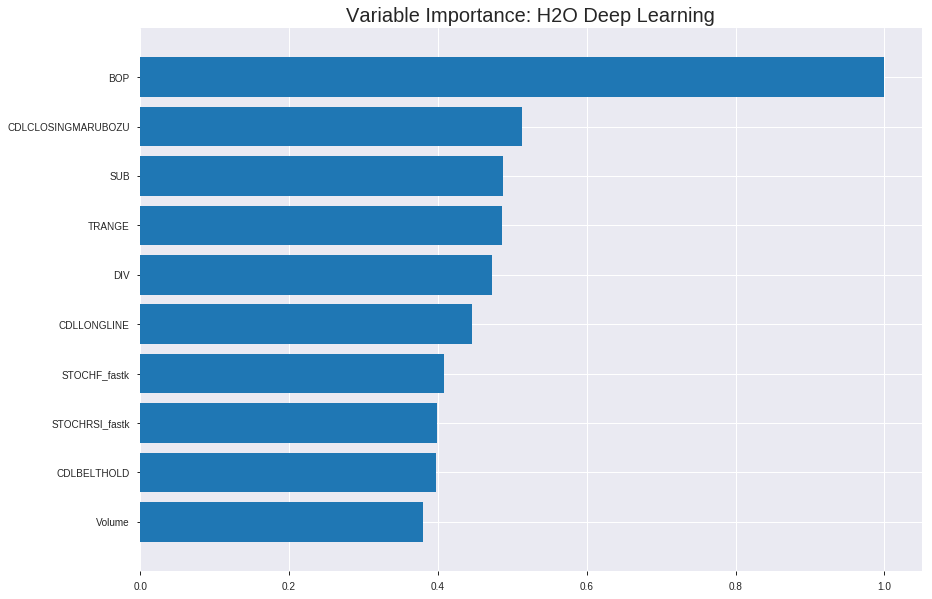

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_161554_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19951921769641368
RMSE: 0.4466757411102753
LogLoss: 0.5815504423549336
Mean Per-Class Error: 0.2888607783317211
AUC: 0.7776893122008086
pr_auc: 0.783999240616382
Gini: 0.5553786244016172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4956382605076608: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      378  377   0.4993   (377.0/755.0)
1      92   709   0.1149   (92.0/801.0)
Total  470  1086  0.3014   (469.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495638     0.751457  234
max f2                       0.283502     0.854766  328
max f0point5                 0.543779     0.712508  200
max accuracy                 0.535323     0.71401   206
max precision                0.976084     1         0
max recall                   0.0567951    1         386
max specificity              0.976084     1         0
max absolute_mcc             0.535323     0.432368  206
max min_per_class_accuracy   0.574389     0.696689  177
max mean_per_class_accuracy  0.543779     0.711139  200

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 54.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.880454           1.94257   1.94257            1                0.923171  1                           0.923171            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.850726           1.82116   1.88187            0.9375           0.8662    0.96875                     0.894685            0.0187266       0.0387016                  82.1161   88.1866
    3        0.0302057                   0.832478           1.81307   1.85991            0.933333         0.840874  0.957447                    0.877511            0.0174782       0.0561798                  81.3067   85.9909
    4        0.0404884                   0.806164           1.82116   1.85007            0.9375           0.819634  0.952381                    0.862812            0.0187266       0.0749064                  82.1161   85.0068
    5        0.0501285                   0.791773           1.81307   1.84295            0.933333         0.796961  0.948718                    0.850149            0.0174782       0.0923845                  81.3067   84.2953
    6        0.100257                    0.743193           1.81805   1.8305             0.935897         0.767713  0.942308                    0.808931            0.0911361       0.183521                   81.8048   83.05
    7        0.150386                    0.704079           1.49429   1.71843            0.769231         0.724437  0.884615                    0.780766            0.0749064       0.258427                   49.4286   71.8429
    8        0.200514                    0.678887           1.39467   1.63749            0.717949         0.689715  0.842949                    0.758003            0.0699126       0.32834                    39.4667   63.7488
    9        0.300129                    0.637162           1.32847   1.53492            0.683871         0.656747  0.79015                     0.724396            0.132335        0.460674                   32.8468   53.4923
    10       0.400386                    0.605232           1.17052   1.44368            0.602564         0.620877  0.743178                    0.698475            0.117353        0.578027                   17.0524   44.3677
    11       0.5                         0.576496           1.10288   1.37578            0.567742         0.590477  0.708226                    0.676958            0.109863        0.68789                    10.2879   37.578
    12       0.600257                    0.537778           1.14562   1.33734            0.589744         0.557379  0.688437                    0.656986            0.114856        0.802747                   14.5619   33.7338
    13       0.699871                    0.494181           0.839692  1.26651            0.432258         0.518575  0.651974                    0.637285            0.0836454       0.886392                   -16.0308  26.6507
    14       0.800129                    0.43703            0.510548  1.17178            0.262821         0.470695  0.603213                    0.616411            0.051186        0.937578                   -48.9452  17.1784
    15       0.899743                    0.30704            0.426113  1.08923            0.219355         0.378276  0.560714                    0.590046            0.0424469       0.980025                   -57.3887  8.92278
    16       1                           0.00119753         0.199238  1                  0.102564         0.169574  0.514781                    0.547891            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21652372055986924
RMSE: 0.4653210940413826
LogLoss: 0.6204873650594482
Mean Per-Class Error: 0.2888249128213446
AUC: 0.7748763279539372
pr_auc: 0.7332329190200791
Gini: 0.5497526559078745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.517936433801249: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  116  0.4915   (116.0/236.0)
1      18   191  0.0861   (18.0/209.0)
Total  138  307  0.3011   (134.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517936     0.74031   269
max f2                       0.515677     0.839861  275
max f0point5                 0.587597     0.689468  160
max accuracy                 0.587597     0.701124  160
max precision                0.941472     1         0
max recall                   0.308061     1         382
max specificity              0.941472     1         0
max absolute_mcc             0.517936     0.455715  269
max min_per_class_accuracy   0.572237     0.684211  189
max mean_per_class_accuracy  0.517936     0.711175  269

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 55.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.813755           2.12919   2.12919            1                0.861975  1                           0.861975            0.0239234       0.0239234                  112.919    112.919
    2        0.0202247                   0.791622           1.59689   1.89261            0.75             0.802326  0.888889                    0.835464            0.0143541       0.0382775                  59.689     89.261
    3        0.0314607                   0.772475           2.12919   1.9771             1                0.785786  0.928571                    0.817722            0.0239234       0.062201                   112.919    97.7102
    4        0.0404494                   0.748361           1.06459   1.77432            0.5              0.764263  0.833333                    0.805842            0.00956938      0.0717703                  6.45933    77.4322
    5        0.0516854                   0.726478           2.12919   1.85147            1                0.733681  0.869565                    0.790155            0.0239234       0.0956938                  112.919    85.1467
    6        0.101124                    0.689845           1.74206   1.79798            0.818182         0.706535  0.844444                    0.749274            0.0861244       0.181818                   74.2062    79.798
    7        0.150562                    0.661037           1.74206   1.77962            0.818182         0.674581  0.835821                    0.724748            0.0861244       0.267943                   74.2062    77.9619
    8        0.2                         0.64338            1.35494   1.67464            0.636364         0.652293  0.786517                    0.706838            0.0669856       0.334928                   35.4937    67.4641
    9        0.301124                    0.615871           1.37214   1.57306            0.644444         0.628486  0.738806                    0.680526            0.138756        0.473684                   37.2142    57.3056
    10       0.4                         0.587205           1.35494   1.51914            0.636364         0.60064   0.713483                    0.660779            0.133971        0.607656                   35.4937    51.9139
    11       0.501124                    0.568607           0.99362   1.41309            0.466667         0.577995  0.663677                    0.644073            0.100478        0.708134                   -0.637959  41.3092
    12       0.6                         0.543763           0.919421  1.33174            0.431818         0.556163  0.625468                    0.629586            0.0909091       0.799043                   -8.05785   33.1738
    13       0.698876                    0.516159           1.16137   1.30764            0.545455         0.530138  0.614148                    0.615516            0.114833        0.913876                   16.1375    30.7636
    14       0.8                         0.481014           0.378522  1.19019            0.177778         0.49869   0.558989                    0.600749            0.0382775       0.952153                   -62.1478   19.0191
    15       0.898876                    0.422779           0.290344  1.09121            0.136364         0.453075  0.5125                      0.584505            0.0287081       0.980861                   -70.9656   9.12081
    16       1                           1.79889e-05        0.189261  1                  0.0888889        0.295772  0.469663                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:27:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:27:32  6 min 32.294 sec  308 obs/sec       0.392674  1             611        0.618323         2.20451             -0.53063       0.596776        0.481255           1.45693          0.423522                         0.700862           3.84321               -0.972088        0.569013          0.561406             1.70335            0.503371
    2019-08-25 16:27:54  6 min 54.658 sec  402 obs/sec       5.73972   14            8931       0.474287         0.641689            0.0994219      0.695961        0.680558           1.82116          0.365681                         0.517545           0.733616              -0.0753696       0.56361           0.514339             1.27751            0.45618
    2019-08-25 16:28:16  7 min 16.598 sec  427 obs/sec       11.5353   28            17949      0.472107         0.634989            0.107682       0.687061        0.683089           1.82116          0.365681                         0.534823           0.775712              -0.148371        0.537467          0.516516             1.27751            0.465169
    2019-08-25 16:28:38  7 min 38.945 sec  443 obs/sec       17.7211   43            27574      0.456956         0.60307             0.164034       0.730173        0.731023           1.82116          0.359254                         0.552238           0.839429              -0.224373        0.557011          0.526521             1.27751            0.442697
    2019-08-25 16:29:01  8 min  1.424 sec  449 obs/sec       23.84     58            37095      0.446676         0.58155             0.201225       0.777689        0.783999           1.94257          0.301414                         0.465321           0.620487              0.130705         0.774876          0.733233             2.12919            0.301124
    2019-08-25 16:29:23  8 min 23.920 sec  455 obs/sec       30.0842   73            46811      0.433209         0.551442            0.248662       0.794352        0.801882           1.69975          0.320051                         0.500636           0.701104              -0.00624906      0.714794          0.678696             2.12919            0.377528
    2019-08-25 16:29:46  8 min 46.274 sec  458 obs/sec       36.2751   88            56444      0.420205         0.527463            0.293093       0.820813        0.821157           1.94257          0.280848                         0.466993           0.631023              0.124449         0.732879          0.68077              1.70335            0.323596
    2019-08-25 16:30:08  9 min  8.544 sec  458 obs/sec       42.099    102           65506      0.416328         0.516376            0.306079       0.82243         0.828935           1.94257          0.301414                         0.480302           0.669436              0.073832         0.736852          0.69629              2.12919            0.332584
    2019-08-25 16:30:32 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006081411240742104
CDLCLOSINGMARUBOZU        0.512680172920227      0.512680172920227    0.003117818966502675
SUB                       0.48733949661254883    0.48733949661254883  0.0029637118927571533
TRANGE                    0.4856950044631958     0.4856950044631958   0.0029537110597147656
DIV                       0.47323647141456604    0.47323647141456604  0.0028779455967896717
---                       ---                    ---                  ---
BBANDS_middleband_12_3_5  0.1342015415430069     0.1342015415430069   0.0008161347632645606
BBANDS_middleband_8_0_4   0.13390541076660156    0.13390541076660156  0.0008143338702321995
BBANDS_middleband_12_2_3  0.13389582931995392    0.13389582931995392  0.000814275601514854
EMA_12                    0.13358420133590698    0.13358420133590698  0.0008123804635897412
BBANDS_middleband_8_4_2   0.13089872896671295    0.13089872896671295  0.0007960490017370223


See the whole table with table.as_data_frame()


('accuracy', 0.7623318385650224)

('F1', 0.7557603686635945)

('auc', 0.7896326530612244)

('logloss', 0.6450127317825802)

('mean_per_class_error', 0.2296326530612245)

('rmse', 0.4758178216248886)

('mse', 0.2264025993758543)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


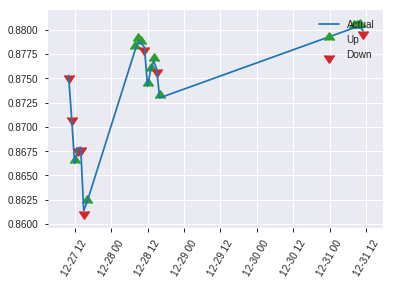


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2264025993758543
RMSE: 0.4758178216248886
LogLoss: 0.6450127317825802
Mean Per-Class Error: 0.2296326530612245
AUC: 0.7896326530612244
pr_auc: 0.6988882475106944
Gini: 0.5792653061224489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5366041027255114: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   37   0.296    (37.0/125.0)
1      16   82   0.1633   (16.0/98.0)
Total  104  119  0.2377   (53.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536604     0.75576   118
max f2                       0.505438     0.821168  155
max f0point5                 0.536604     0.714286  118
max accuracy                 0.536604     0.762332  118
max precision                0.676955     0.9       9
max recall                   0.406406     1         213
max specificity              0.70615      0.992     0
max absolute_mcc             0.536604     0.537975  118
max min_per_class_accuracy   0.549415     0.728     105
max mean_per_class_accuracy  0.536604     0.770367  118

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 54.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.695144           1.51701   1.51701            0.666667         0.701736  0.666667                    0.701736            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.6877             2.27551   1.82041            1                0.691364  0.8                         0.697587            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.681905           2.27551   1.95044            1                0.685247  0.857143                    0.694061            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.677019           2.27551   2.02268            1                0.678943  0.888889                    0.690702            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.668921           1.51701   1.89626            0.666667         0.672871  0.833333                    0.686244            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.641518           1.65492   1.78083            0.727273         0.653567  0.782609                    0.670616            0.0816327       0.183673                   65.4917   78.0834
    7        0.152466                    0.626804           1.65492   1.7401             0.727273         0.63227   0.764706                    0.65821             0.0816327       0.265306                   65.4917   74.0096
    8        0.201794                    0.612246           1.03432   1.56757            0.454545         0.619328  0.688889                    0.648705            0.0510204       0.316327                   3.43228   56.7574
    9        0.300448                    0.593532           1.65492   1.59625            0.727273         0.602713  0.701493                    0.633603            0.163265        0.479592                   65.4917   59.6253
    10       0.399103                    0.570779           1.55148   1.58519            0.681818         0.582861  0.696629                    0.62106             0.153061        0.632653                   55.1484   58.5187
    11       0.502242                    0.543828           1.38509   1.5441             0.608696         0.553878  0.678571                    0.607264            0.142857        0.77551                    38.5093   54.4096
    12       0.600897                    0.522067           0.827458  1.42644            0.363636         0.53199   0.626866                    0.594906            0.0816327       0.857143                   -17.2542  42.6439
    13       0.699552                    0.504662           0.620594  1.31279            0.272727         0.515124  0.576923                    0.583654            0.0612245       0.918367                   -37.9406  31.2794
    14       0.798206                    0.483571           0.103432  1.16332            0.0454545        0.493647  0.511236                    0.57253             0.0102041       0.928571                   -89.6568  16.3323
    15       0.896861                    0.444615           0.413729  1.08087            0.181818         0.466296  0.475                       0.560844            0.0408163       0.969388                   -58.6271  8.08673
    16       1                           0.312011           0.296806  1                  0.130435         0.402013  0.439462                    0.544462         

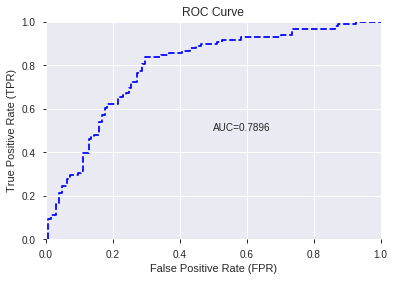

This function is available for GLM models only


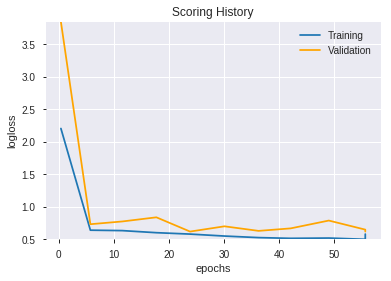

--2019-08-25 16:43:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  34.9MB/s    in 11s     

2019-08-25 16:43:51 (32.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_161554_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_161554_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_164404_model_4  0.801796  1.079018              0.276816  0.520340  0.270754
1  DeepLearning_grid_1_AutoML_20190825_164404_model_3  0.800000  0.739889              0.248531  0.453838  0.205969
2  DeepLearning_grid_1_AutoML_20190825_164404_model_6  0.798857  0.542273              0.258327  0.431245  0.185972
3  DeepLearning_grid_1_AutoML_20190825_164404_model_5  0.792490  0.545427              0.263143  0.430442  0.185280
4  DeepLearning_grid_1_AutoML_20190825_164404_model_2  0.792163  0.636054              0.248531  0.445070  0.198087
5  DeepLearning_grid_1_AutoML_20190825_164404_model_8  0.791265  0.553535              0.258041  0.433940  0.188304
6  DeepLearning_grid_1_AutoML_20190825_164404_model_9  0.788163  0.577466              0.260245  0.443656  0.196831
7  DeepLearning_grid_1_AutoML_20190825_164404_model_7  0.783265  0.744944              0.250449  0.481932  0.232258
8               DeepLearning_1_AutoML_20190825_164404  0.744490  0.718853              0.310735  0.474709  0.225348
9  DeepLearning_grid_1_AutoML_20190825_164404_model_1  0.729878  0.891833              0.335429  0.502373  0.252378

variable  relative_importance  scaled_importance  percentage
0              CDLTAKURI             1.000000           1.000000    0.028391
1       CDLDRAGONFLYDOJI             0.994548           0.994548    0.028237
2          CDLHANGINGMAN             0.987659           0.987659    0.028041
3         is_month_start             0.883662           0.883662    0.025088
4              CDLHAMMER             0.883206           0.883206    0.025075
5     CDLCLOSINGMARUBOZU             0.772476           0.772476    0.021932
6            CDLMARUBOZU             0.752938           0.752938    0.021377
7              CORREL_24             0.733963           0.733963    0.020838
8          days_in_month             0.722221           0.722221    0.020505
9           CDLSHORTLINE             0.716261           0.716261    0.020336
10           CDLHIGHWAVE             0.711479           0.711479    0.020200
11                ADX_24             0.704487           0.704487    0.020001
12                   SUB             0.701135           0.701135    0.019906
13                TRANGE             0.700846           0.700846    0.019898
14           CDLLONGLINE             0.699771           0.699771    0.019867
15                Volume             0.698250           0.698250    0.019824
16                   BOP             0.697733           0.697733    0.019810
17                   DIV             0.689914           0.689914    0.019588
18               BETA_30             0.688742           0.688742    0.019554
19                 DX_14             0.688033           0.688033    0.019534
20          CDLENGULFING             0.684955           0.684955    0.019447
21             dayofyear             0.683863           0.683863    0.019416
22              WILLR_14             0.677241           0.677241    0.019228
23  HT_PHASOR_quadrature             0.674849           0.674849    0.019160
24                ULTOSC             0.674201           0.674201    0.019142
25               BETA_12             0.673050           0.673050    0.019109
26             aroonup_8             0.671753           0.671753    0.019072
27            AROONOSC_8             0.670273           0.670273    0.019030
28              WILLR_24             0.668038           0.668038    0.018967
29           CDLBELTHOLD             0.667539           0.667539    0.018952
30          HT_TRENDMODE             0.667377           0.667377    0.018948
31            aroonup_14             0.664319           0.664319    0.018861
32                 RSI_8             0.664243           0.664243    0.018859
33                   day             0.663732           0.663732    0.018844
34        STOCHRSI_fastk             0.663651           0.663651    0.018842
35              CORREL_8             0.660324           0.660324    0.018748
36          aroondown_14             0.659464           0.659464    0.018723
37        CDLSPINNINGTOP             0.659047           0.659047    0.018711
38              WILLR_20             0.654799           0.654799    0.018591
39                 CMO_8             0.653958           0.653958    0.018567
40           STOCH_slowk             0.649277           0.649277    0.018434
41                 ADOSC             0.648006           0.648006    0.018398
42              WILLR_12             0.647331           0.647331    0.018379
43                    AD             0.646730           0.646730    0.018362
44               WILLR_8             0.645245           0.645245    0.018319
45           STOCH_slowd             0.644778           0.644778    0.018306
46        STOCHRSI_fastd             0.643164           0.643164    0.018260
47          weekday_name             0.640275           0.640275    0.018178
48          STOCHF_fastk             0.639943           0.639943    0.018169
49                  hour             0.633184           0.633184    0.017977

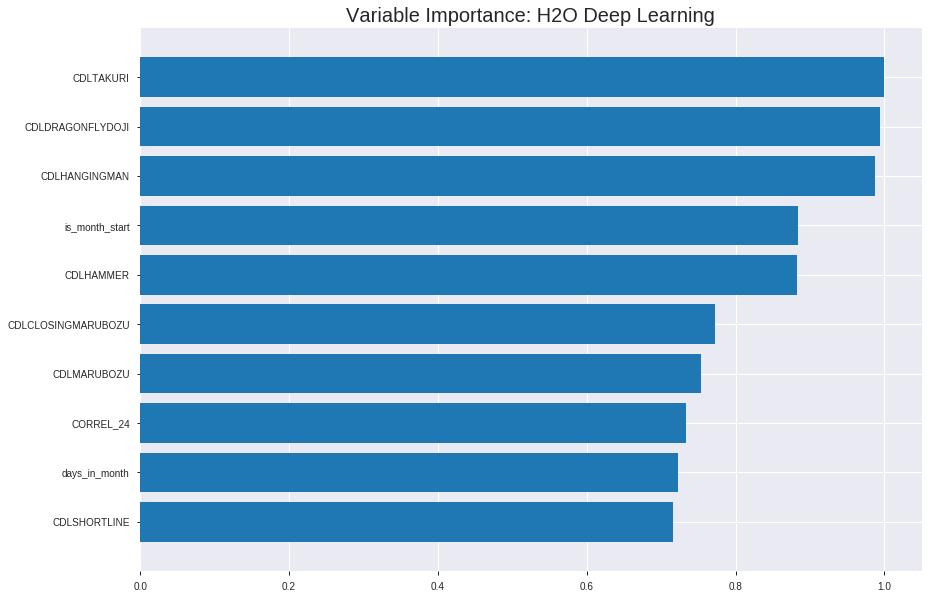

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_164404_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17378324719121202
RMSE: 0.4168731787860812
LogLoss: 0.5935480576393015
Mean Per-Class Error: 0.21879190746666
AUC: 0.8594695372506221
pr_auc: 0.7483457134036803
Gini: 0.7189390745012443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4339048055075623: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      463  292   0.3868   (292.0/755.0)
1      88   713   0.1099   (88.0/801.0)
Total  551  1005  0.2442   (380.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433905     0.78959   237
max f2                       0.117771     0.872408  336
max f0point5                 0.898155     0.806907  70
max accuracy                 0.750901     0.780848  130
max precision                0.99991      0.979592  0
max recall                   0.000725964  1         398
max specificity              0.99991      0.997351  0
max absolute_mcc             0.837601     0.564508  98
max min_per_class_accuracy   0.732638     0.774032  137
max mean_per_class_accuracy  0.750901     0.781208  130

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 60.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.999999           1.94257    1.94257            1                1           1                           1                   0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.999978           1.82116    1.88187            0.9375           0.99999     0.96875                     0.999995            0.0187266       0.0387016                  82.1161   88.1866
    3        0.0302057                   0.999945           1.94257    1.90124            1                0.999965    0.978723                    0.999985            0.0187266       0.0574282                  94.2572   90.124
    4        0.0404884                   0.999882           1.94257    1.91174            1                0.999917    0.984127                    0.999968            0.019975        0.0774032                  94.2572   91.1737
    5        0.0501285                   0.999833           1.94257    1.91767            1                0.999854    0.987179                    0.999946            0.0187266       0.0961298                  94.2572   91.7667
    6        0.100257                    0.999014           1.79314    1.85541            0.923077         0.999475    0.955128                    0.99971             0.0898876       0.186017                   79.3143   85.5405
    7        0.150386                    0.995752           1.79314    1.83465            0.923077         0.997702    0.944444                    0.999041            0.0898876       0.275905                   79.3143   83.4651
    8        0.200514                    0.989325           1.69352    1.79937            0.871795         0.992881    0.926282                    0.997501            0.0848939       0.360799                   69.3524   79.9369
    9        0.300129                    0.959567           1.61672    1.73875            0.832258         0.97671     0.895075                    0.9906              0.161049        0.521848                   61.6721   73.8747
    10       0.400386                    0.882605           1.35731    1.64323            0.698718         0.925676    0.845907                    0.974343            0.13608         0.657928                   35.731    64.3235
    11       0.5                         0.743897           1.12794    1.54057            0.580645         0.819615    0.793059                    0.943517            0.11236         0.770287                   12.7945   54.0574
    12       0.600257                    0.540906           0.759595   1.41013            0.391026         0.641101    0.72591                     0.893006            0.0761548       0.846442                   -24.0405  41.0132
    13       0.699871                    0.30209            0.764496   1.31824            0.393548         0.420868    0.678604                    0.825806            0.0761548       0.922597                   -23.5504  31.8237
    14       0.800129                    0.106606           0.448286   1.20923            0.230769         0.189795    0.62249                     0.746113            0.0449438       0.967541                   -55.1714  20.9231
    15       0.899743                    0.012332           0.225589   1.10033            0.116129         0.0462242   0.566429                    0.668625            0.0224719       0.990012                   -77.4411  10.0328
    16       1                           3.53118e-06        0.0996191  1                  0.0512821        0.00



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2251653538728297
RMSE: 0.47451591529982395
LogLoss: 0.9059336626505126
Mean Per-Class Error: 0.28049225529154165
AUC: 0.7826108993593383
pr_auc: 0.6985525978217333
Gini: 0.5652217987186765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2467052837542994: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  122  0.5169   (122.0/236.0)
1      17   192  0.0813   (17.0/209.0)
Total  131  314  0.3124   (139.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.246705     0.734226  284
max f2                       0.0742164    0.850254  316
max f0point5                 0.86102      0.699223  143
max accuracy                 0.55515      0.714607  220
max precision                0.999833     0.866667  8
max recall                   0.00130213   1         380
max specificity              0.999999     0.991525  0
max absolute_mcc             0.463098     0.448102  239
max min_per_class_accuracy   0.731304     0.707627  187
max mean_per_class_accuracy  0.463098     0.719508  239

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 57.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.999999           1.70335    1.70335            0.8              1            0.8                         1                   0.0191388       0.0191388                  70.3349   70.3349
    2        0.0202247                   0.999982           1.06459    1.41946            0.5              0.999994     0.666667                    0.999997            0.00956938      0.0287081                  6.45933   41.9458
    3        0.0314607                   0.999958           2.12919    1.67293            1                0.999972     0.785714                    0.999988            0.0239234       0.0526316                  112.919   67.2932
    4        0.0404494                   0.999937           2.12919    1.77432            1                0.999951     0.833333                    0.99998             0.0191388       0.0717703                  112.919   77.4322
    5        0.0516854                   0.999906           2.12919    1.85147            1                0.999917     0.869565                    0.999966            0.0239234       0.0956938                  112.919   85.1467
    6        0.101124                    0.998597           1.74206    1.79798            0.818182         0.999491     0.844444                    0.999734            0.0861244       0.181818                   74.2062   79.798
    7        0.150562                    0.995775           1.06459    1.55717            0.5              0.997137     0.731343                    0.998881            0.0526316       0.23445                    6.45933   55.7166
    8        0.2                         0.985846           1.83884    1.62679            0.863636         0.992001     0.764045                    0.99718             0.0909091       0.325359                   83.8843   62.6794
    9        0.301124                    0.945213           1.46677    1.57306            0.688889         0.970242     0.738806                    0.988134            0.148325        0.473684                   46.6773   57.3056
    10       0.4                         0.85263            1.40333    1.5311             0.659091         0.904064     0.719101                    0.967353            0.138756        0.61244                    40.3328   53.11
    11       0.501124                    0.697838           1.08825    1.44174            0.511111         0.78706      0.67713                     0.930971            0.110048        0.722488                   8.82509   44.1736
    12       0.6                         0.465608           1.11298    1.38756            0.522727         0.576874     0.651685                    0.872618            0.110048        0.832536                   11.2984   38.756
    13       0.698876                    0.255196           0.77425    1.30079            0.363636         0.35875      0.610932                    0.799916            0.076555        0.909091                   -22.575   30.0789
    14       0.8                         0.0562539          0.567783   1.20813            0.266667         0.142261     0.567416                    0.716786            0.0574163       0.966507                   -43.2217  20.8134
    15       0.898876                    0.00305077         0.290344   1.10718            0.136364         0.0253504    0.52                        0.640728            0.0287081       0.995215                   -70.9656  10.7177
    16       1                           9.95527e-06        0.0473153  1                  0.02222


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:46:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:46:10  7.262 sec         313 obs/sec       1.33933   1             2084       0.490497         1.07252             0.0368092      0.773493        0.629719           1.94257          0.298201                         0.507427           1.32081               -0.033735        0.741576          0.631788             1.70335            0.368539
    2019-08-25 16:46:16  13.479 sec        340 obs/sec       2.67481   2             4162       0.615469         1.94912             -0.516533      0.756486        0.766632           1.94257          0.320051                         0.602541           1.94857               -0.45759         0.74259           0.699722             2.12919            0.341573
    2019-08-25 16:46:26  23.699 sec        381 obs/sec       5.3599    4             8340       0.52866          1.19897             -0.118903      0.807364        0.794345           1.82116          0.28599                          0.544565           1.3644                -0.190587        0.752098          0.68328              1.70335            0.330337
    2019-08-25 16:46:35  32.453 sec        417 obs/sec       8.07455   6             12564      0.431628         0.654209            0.254137       0.826683        0.746095           1.82116          0.268638                         0.50411            1.09921               -0.0202624       0.733162          0.638785             2.12919            0.323596
    2019-08-25 16:46:43  40.576 sec        444 obs/sec       10.7834   8             16779      0.446407         0.717653            0.202187       0.819462        0.699954           1.82116          0.264781                         0.51033            1.06496               -0.0455971       0.730324          0.636835             1.70335            0.375281
    2019-08-25 16:46:51  48.106 sec        467 obs/sec       13.464    10            20950      0.416873         0.593548            0.304259       0.85947         0.748346           1.94257          0.244216                         0.474516           0.905934              0.0960107        0.782611          0.698553             1.70335            0.31236
    2019-08-25 16:46:57  55.077 sec        490 obs/sec       16.16     12            25145      0.418871         0.576323            0.297574       0.852472        0.801055           1.82116          0.241003                         0.51319            1.00552               -0.0573476       0.735028          0.664633             1.70335            0.375281
    2019-08-25 16:47:04  1 min  1.688 sec  511 obs/sec       18.8425   14            29319      0.401532         0.568545            0.354523       0.893456        0.885229           1.94257          0.199229                         0.498915           0.920232              0.000656469      0.770862          0.733923             2.12919            0.276404
    2019-08-25 16:47:10 

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLTAKURI         1.0                    1.0                  0.02839139983804537
CDLDRAGONFLYDOJI  0.994547963142395      0.994547963142395    0.028236608879689346
CDLHANGINGMAN     0.9876590371131897     0.9876590371131897   0.028041022626339458
is_month_start    0.8836624026298523     0.8836624026298523   0.02508841259491197
CDLHAMMER         0.8832058310508728     0.8832058310508728   0.025075449888658476
---               ---                    ---                  ---
STOCH_slowd       0.6447778344154358     0.6447778344154358   0.018306145303597646
STOCHRSI_fastd    0.6431636810302734     0.6431636810302734   0.01826031722943957
weekday_name      0.6402748823165894     0.6402748823165894   0.018178300190107733
STOCHF_fastk      0.6399425864219666     0.6399425864219666   0.018168865844498956
hour              0.6331844329833984     0.6331844329833984   0.017976992408057706


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.728744939271255)

('auc', 0.801795918367347)

('logloss', 1.079017844365874)

('mean_per_class_error', 0.2768163265306123)

('rmse', 0.5203402244604064)

('mse', 0.27075394919150614)

deeplearning prediction progress: |███████████████████████████████████████| 100%


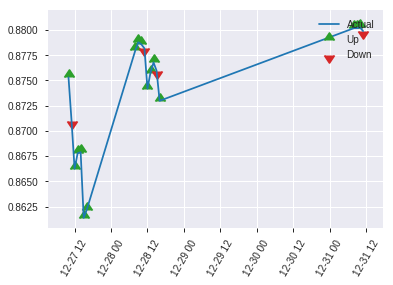


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27075394919150614
RMSE: 0.5203402244604064
LogLoss: 1.079017844365874
Mean Per-Class Error: 0.2768163265306123
AUC: 0.801795918367347
pr_auc: 0.7448623095857319
Gini: 0.603591836734694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6335770310442275: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   59   0.472    (59.0/125.0)
1      8    90   0.0816   (8.0/98.0)
Total  74   149  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.633577     0.728745  148
max f2                       0.270502     0.850877  177
max f0point5                 0.977817     0.687204  80
max accuracy                 0.917782     0.721973  105
max precision                1            1         0
max recall                   0.0144881    1         210
max specificity              1            1         0
max absolute_mcc             0.633577     0.470491  148
max min_per_class_accuracy   0.917782     0.72      105
max mean_per_class_accuracy  0.633577     0.723184  148

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 70.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.999998           2.27551    2.27551            1                0.999999   1                           0.999999            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.99999            2.27551    2.27551            1                0.999996   1                           0.999998            0.0204082       0.0510204                  127.551   127.551
    3        0.0313901                   0.999973           2.27551    2.27551            1                0.999983   1                           0.999993            0.0204082       0.0714286                  127.551   127.551
    4        0.0403587                   0.999964           2.27551    2.27551            1                0.999969   1                           0.999988            0.0204082       0.0918367                  127.551   127.551
    5        0.0538117                   0.999932           1.51701    2.08588            0.666667         0.999953   0.916667                    0.999979            0.0204082       0.112245                   51.7007   108.588
    6        0.103139                    0.999287           1.86178    1.9787             0.818182         0.999675   0.869565                    0.999834            0.0918367       0.204082                   86.1781   97.8705
    7        0.152466                    0.997837           2.06865    2.0078             0.909091         0.998448   0.882353                    0.999385            0.102041        0.306122                   106.865   100.78
    8        0.201794                    0.993801           1.44805    1.87098            0.636364         0.996036   0.822222                    0.998567            0.0714286       0.377551                   44.8052   87.0975
    9        0.300448                    0.985124           1.13776    1.63022            0.5              0.989698   0.716418                    0.995654            0.112245        0.489796                   13.7755   63.0216
    10       0.399103                    0.967803           1.34462    1.55962            0.590909         0.978206   0.685393                    0.991341            0.132653        0.622449                   34.462    55.9619
    11       0.502242                    0.902267           1.18722    1.48315            0.521739         0.932319   0.651786                    0.979221            0.122449        0.744898                   18.7223   48.3145
    12       0.600897                    0.772079           0.930891   1.39248            0.409091         0.864231   0.61194                     0.960342            0.0918367       0.836735                   -6.91095  39.2476
    13       0.699552                    0.591842           1.03432    1.34197            0.454545         0.678933   0.589744                    0.920656            0.102041        0.938776                   3.43228   34.1968
    14       0.798206                    0.268262           0.517161   1.24003            0.227273         0.433622   0.544944                    0.860461            0.0510204       0.989796                   -48.2839  24.0025
    15       0.896861                    0.0356669          0          1.10362            0                0.132483   0.485                       0.780383            0               0.989796                   -100      10.3622
    16       1                           3.43206e-05        0.0989352  1                  0.0434783        0.0149293  0.439462  

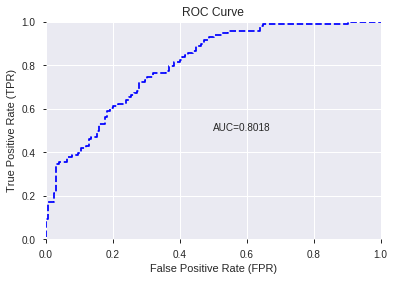

This function is available for GLM models only


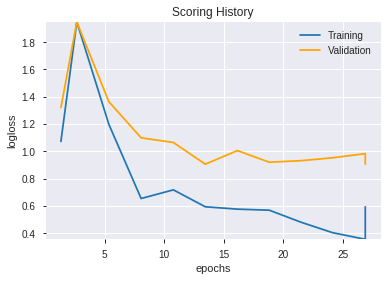

--2019-08-25 16:51:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_164404_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_164404_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'is_month_start',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'CORREL_24',
 'days_in_month',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'ADX_24',
 'SUB',
 'TRANGE',
 'CDLLONGLINE',
 'Volume',
 'BOP',
 'DIV',
 'BETA_30',
 'DX_14',
 'CDLENGULFING',
 'dayofyear',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'ULTOSC',
 'BETA_12',
 'aroonup_8',
 'AROONOSC_8',
 'WILLR_24',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'aroonup_14',
 'RSI_8',
 'day',
 'STOCHRSI_fastk',
 'CORREL_8',
 'aroondown_14',
 'CDLSPINNINGTOP',
 'WILLR_20',
 'CMO_8',
 'STOCH_slowk',
 'ADOSC',
 'WILLR_12',
 'AD',
 'WILLR_8',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'weekday_name',
 'STOCHF_fastk',
 'hour']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_165131_model_1  0.792082  0.561042              0.246735  0.436002  0.190098

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.454646           1.000000    0.126599
1     CDLCLOSINGMARUBOZU             0.204338           0.449444    0.056899
2              CDLHAMMER             0.182345           0.401070    0.050775
3                    SUB             0.139649           0.307159    0.038886
4           STOCHF_fastk             0.134763           0.296413    0.037526
5             aroonup_14             0.125213           0.275407    0.034866
6                    DIV             0.115241           0.253473    0.032089
7          CDLHANGINGMAN             0.106936           0.235206    0.029777
8                  ADOSC             0.106750           0.234798    0.029725
9                WILLR_8             0.105820           0.232752    0.029466
10           STOCH_slowk             0.102739           0.225975    0.028608
11                ULTOSC             0.100999           0.222149    0.028124
12        STOCHRSI_fastd             0.094032           0.206824    0.026184
13          CDLSHORTLINE             0.085492           0.188041    0.023806
14             aroonup_8             0.085147           0.187282    0.023710
15                TRANGE             0.083885           0.184507    0.023358
16         days_in_month             0.078875           0.173487    0.021963
17                 DX_14             0.078780           0.173277    0.021937
18                  hour             0.076286           0.167791    0.021242
19        CDLSPINNINGTOP             0.074200           0.163205    0.020662
20        STOCHRSI_fastk             0.072158           0.158713    0.020093
21           STOCH_slowd             0.070708           0.155524    0.019689
22          CDLENGULFING             0.070683           0.155468    0.019682
23              WILLR_12             0.064402           0.141652    0.017933
24           CDLBELTHOLD             0.063821           0.140375    0.017771
25        is_month_start             0.060634           0.133365    0.016884
26          weekday_name             0.058284           0.128197    0.016230
27      CDLDRAGONFLYDOJI             0.055667           0.122440    0.015501
28             CDLTAKURI             0.055572           0.122232    0.015474
29           CDLLONGLINE             0.049367           0.108583    0.013747
30               BETA_12             0.044048           0.096883    0.012265
31            AROONOSC_8             0.042929           0.094422    0.011954
32           CDLHIGHWAVE             0.042486           0.093447    0.011830
33              WILLR_14             0.037256           0.081945    0.010374
34             CORREL_24             0.035603           0.078308    0.009914
35              WILLR_20             0.032969           0.072517    0.009181
36           CDLMARUBOZU             0.032154           0.070723    0.008954
37          aroondown_14             0.021233           0.046703    0.005913
38                Volume             0.018603           0.040918    0.005180
39  HT_PHASOR_quadrature             0.018231           0.040099    0.005077
40                 CMO_8             0.017028           0.037452    0.004741
41                 RSI_8             0.016683           0.036695    0.004646
42             dayofyear             0.016218           0.035671    0.004516
43               BETA_30             0.013189           0.029009    0.003673
44                    AD             0.011933           0.026247    0.003323
45                ADX_24             0.010414           0.022906    0.002900
46              WILLR_24             0.008071           0.017752    0.002247
47                   day             0.007513           0.016526    0.002092
48          HT_TRENDMODE             0.006595           0.014506    0.001836
49              CORREL_8             0.000636           0.001399    0.000177

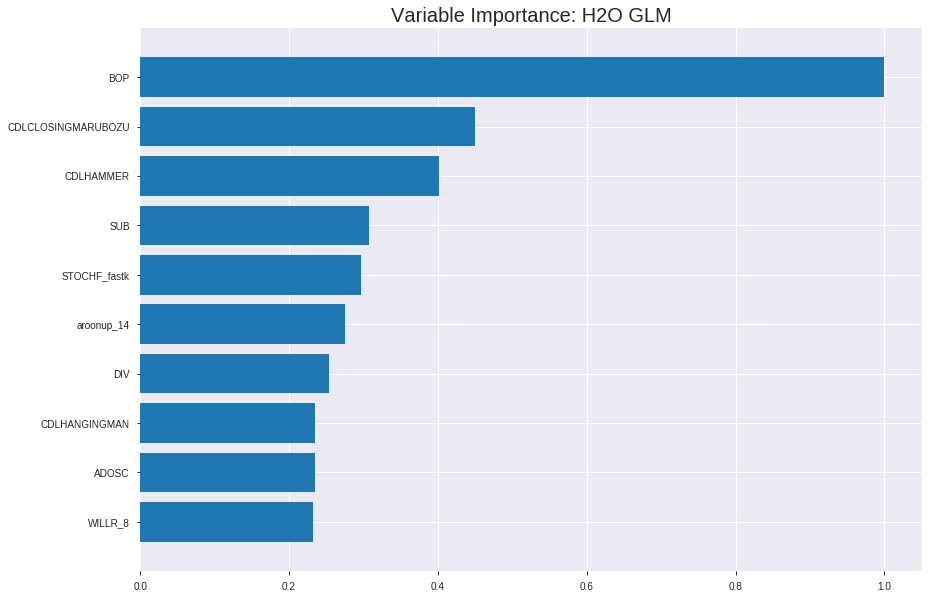

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_165131_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18268897041447424
RMSE: 0.4274213031827897
LogLoss: 0.5447157705082446
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2155.7139305761725
Residual deviance: 1695.155477821657
AIC: 1797.155477821657
AUC: 0.803512166083786
pr_auc: 0.8030044316975108
Gini: 0.6070243321675719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4374959652257395: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      468  287  0.3801   (287.0/755.0)
1      140  661  0.1748   (140.0/801.0)
Total  608  948  0.2744   (427.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437496     0.75586   230
max f2                       0.194803     0.85395   341
max f0point5                 0.578844     0.746998  165
max accuracy                 0.53906      0.733933  184
max precision                0.940733     1         0
max recall                   0.0451492    1         393
max specificity              0.940733     1         0
max absolute_mcc             0.53906      0.468444  184
max min_per_class_accuracy   0.526392     0.729089  189
max mean_per_class_accuracy  0.53906      0.734309  184

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.91254            1.94257   1.94257            1                0.92688   1                           0.92688             0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.897001           1.57834   1.76046            0.8125           0.904494  0.90625                     0.915687            0.0162297       0.0362047                  57.834    76.0456
    3        0.0302057                   0.878842           1.94257   1.81858            1                0.887899  0.93617                     0.906819            0.0187266       0.0549313                  94.2572   81.8578
    4        0.0404884                   0.864658           1.94257   1.85007            1                0.870611  0.952381                    0.897623            0.019975        0.0749064                  94.2572   85.0068
    5        0.0501285                   0.848594           1.81307   1.84295            0.933333         0.856485  0.948718                    0.889712            0.0174782       0.0923845                  81.3067   84.2953
    6        0.100257                    0.795531           1.66862   1.75579            0.858974         0.819659  0.903846                    0.854686            0.0836454       0.17603                    66.8619   75.5786
    7        0.150386                    0.763352           1.76824   1.75994            0.910256         0.779674  0.905983                    0.829682            0.0886392       0.264669                   76.8238   75.9937
    8        0.200514                    0.730765           1.61881   1.72466            0.833333         0.746941  0.887821                    0.808997            0.0811486       0.345818                   61.881    72.4655
    9        0.300129                    0.674186           1.35353   1.60148            0.696774         0.700691  0.824411                    0.773049            0.134831        0.480649                   35.3534   60.1478
    10       0.400386                    0.61833            1.27014   1.51851            0.653846         0.64648   0.781701                    0.741356            0.127341        0.60799                    27.0143   51.8511
    11       0.5                         0.530747           1.16554   1.44819            0.6              0.574842  0.745501                    0.708182            0.116105        0.724095                   16.5543   44.819
    12       0.600257                    0.443724           0.871667  1.3519             0.448718         0.48607   0.695931                    0.671084            0.0873908       0.811486                   -12.8333  35.1897
    13       0.699871                    0.371003           0.726898  1.26294            0.374194         0.410751  0.650138                    0.63403             0.0724095       0.883895                   -27.3102  26.2939
    14       0.800129                    0.299491           0.597714  1.17959            0.307692         0.335321  0.607229                    0.596602            0.0599251       0.94382                    -40.2286  17.9586
    15       0.899743                    0.198082           0.350916  1.08784            0.180645         0.250885  0.56                        0.558326            0.0349563       0.978777                   -64.9084  8.78402
    16       1                           0.0136775          0.211691  1                  0.108974         0.123999  0.514781                    0.514782          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19081699220132192
RMSE: 0.4368260434100993
LogLoss: 0.5610626550295734
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 618.886943697008
Residual deviance: 499.3457629763204
AIC: 601.3457629763204
AUC: 0.7805733517151894
pr_auc: 0.7182312459907144
Gini: 0.5611467034303788
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39614398765078224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  83   0.3517   (83.0/236.0)
1      43   166  0.2057   (43.0/209.0)
Total  196  249  0.2831   (126.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396144     0.724891  221
max f2                       0.151795     0.848435  336
max f0point5                 0.507269     0.712841  173
max accuracy                 0.470049     0.72809   190
max precision                0.930613     1         0
max recall                   0.0806171    1         373
max specificity              0.930613     1         0
max absolute_mcc             0.435635     0.455896  206
max min_per_class_accuracy   0.470049     0.722488  190
max mean_per_class_accuracy  0.435635     0.728114  206

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 45.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.893803           1.70335   1.70335            0.8              0.915317   0.8                         0.915317            0.0191388       0.0191388                  70.3349   70.3349
    2        0.0202247                   0.869796           2.12919   1.89261            1                0.876462   0.888889                    0.898048            0.0191388       0.0382775                  112.919   89.261
    3        0.0314607                   0.860411           1.70335   1.82502            0.8              0.865944   0.857143                    0.886582            0.0191388       0.0574163                  70.3349   82.5017
    4        0.0404494                   0.848021           1.59689   1.77432            0.75             0.854201   0.833333                    0.879386            0.0143541       0.0717703                  59.689    77.4322
    5        0.0516854                   0.841486           2.12919   1.85147            1                0.844112   0.869565                    0.871718            0.0239234       0.0956938                  112.919   85.1467
    6        0.101124                    0.782964           1.45172   1.65603            0.681818         0.811045   0.777778                    0.842055            0.0717703       0.167464                   45.1718   65.6034
    7        0.150562                    0.732276           1.5485    1.62072            0.727273         0.755165   0.761194                    0.813524            0.076555        0.244019                   54.8499   62.0724
    8        0.2                         0.684913           1.74206   1.65072            0.818182         0.710535   0.775281                    0.788066            0.0861244       0.330144                   74.2062   65.0718
    9        0.301124                    0.61563            1.41946   1.57306            0.666667         0.647691   0.738806                    0.740925            0.143541        0.473684                   41.9458   57.3056
    10       0.4                         0.538822           1.40333   1.5311             0.659091         0.579156   0.719101                    0.700937            0.138756        0.61244                    40.3328   53.11
    11       0.501124                    0.452121           1.27751   1.47993            0.6              0.493691   0.695067                    0.659116            0.129187        0.741627                   27.7512   47.9928
    12       0.6                         0.365539           0.77425   1.36364            0.363636         0.407032   0.640449                    0.617574            0.076555        0.818182                   -22.575   36.3636
    13       0.698876                    0.288282           0.629078  1.25971            0.295455         0.331108   0.59164                     0.577045            0.062201        0.880383                   -37.0922  25.9712
    14       0.8                         0.208101           0.709729  1.19019            0.333333         0.255923   0.558989                    0.536454            0.0717703       0.952153                   -29.0271  19.0191
    15       0.898876                    0.11229            0.338734  1.09653            0.159091         0.155173   0.515                       0.494513            0.0334928       0.985646                   -66.1266  9.65311
    16       1                           0.00955409         0.141946  1                  0.0666667        0.0632216  0.469663                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:51:32  0.000 sec   2            22        51            1.36126           1.36183
    2019-08-25 16:51:32  0.061 sec   4            14        51            1.34915           1.34741
    2019-08-25 16:51:32  0.098 sec   6            8.6       51            1.3326            1.32781
    2019-08-25 16:51:32  0.124 sec   8            5.4       51            1.31122           1.30284
    2019-08-25 16:51:32  0.146 sec   10           3.3       51            1.28523           1.27318
    2019-08-25 16:51:32  0.168 sec   12           2.1       51            1.25556           1.24058
    2019-08-25 16:51:32  0.193 sec   14           1.3       51            1.22394           1.20786
    2019-08-25 16:51:32  0.212 sec   16           0.8       51            1.19249           1.17802
    2019-08-25 16:51:32  0.232 sec   18           0.5       51            1.16347           1.15386
    2019-08-25 16:51:32  0.247 sec   20           0.31      51            1.13842           1.13683
    2019-08-25 16:51:32  0.268 sec   22           0.19      51            1.11795           1.12681
    2019-08-25 16:51:32  0.287 sec   24           0.12      51            1.10182           1.12251
    2019-08-25 16:51:32  0.307 sec   26           0.074     51            1.08943           1.12213
    2019-08-25 16:51:32  0.328 sec   28           0.046     51            1.08011           1.12404
    2019-08-25 16:51:32  0.347 sec   30           0.028     51            1.07326           1.12713
    2019-08-25 16:51:32  0.363 sec   32           0.018     51            1.0683            1.13054
    2019-08-25 16:51:32  0.380 sec   34           0.011     51            1.06471           1.13376
    2019-08-25 16:51:32  0.399 sec   36           0.0068    51            1.06201           1.13647

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7397260273972602)

('auc', 0.7920816326530612)

('logloss', 0.5610415716601912)

('mean_per_class_error', 0.2442448979591837)

('rmse', 0.43600211078366635)

('mse', 0.19009784060781246)

glm prediction progress: |████████████████████████████████████████████████| 100%


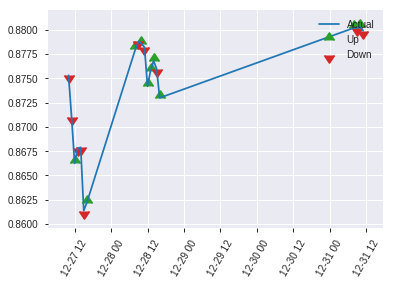


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19009784060781246
RMSE: 0.43600211078366635
LogLoss: 0.5610415716601912
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.9354893756444
Residual deviance: 250.22454096044524
AIC: 352.2245409604452
AUC: 0.7920816326530612
pr_auc: 0.7133917335943545
Gini: 0.5841632653061224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31824336593146113: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   40   0.32     (40.0/125.0)
1      17   81   0.1735   (17.0/98.0)
Total  102  121  0.2556   (57.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318243     0.739726  120
max f2                       0.0558683    0.820771  204
max f0point5                 0.367902     0.71161   108
max accuracy                 0.367902     0.753363  108
max precision                0.916275     1         0
max recall                   0.0558683    1         204
max specificity              0.916275     1         0
max absolute_mcc             0.367902     0.507875  108
max min_per_class_accuracy   0.381235     0.744     104
max mean_per_class_accuracy  0.367902     0.755755  108

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 37.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.860555           1.51701   1.51701            0.666667         0.88051    0.666667                    0.88051             0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.853427           2.27551   1.82041            1                0.854809   0.8                         0.87023             0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.836517           2.27551   1.95044            1                0.851678   0.857143                    0.864929            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.79874            2.27551   2.02268            1                0.826425   0.888889                    0.856373            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.791387           1.51701   1.89626            0.666667         0.793538   0.833333                    0.840664            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.729485           2.06865   1.9787             0.909091         0.755801   0.869565                    0.800077            0.102041        0.204082                   106.865   97.8705
    7        0.152466                    0.682267           1.44805   1.80702            0.636364         0.712908   0.794118                    0.771875            0.0714286       0.27551                    44.8052   80.7023
    8        0.201794                    0.614887           1.24119   1.66871            0.545455         0.647642   0.733333                    0.741507            0.0612245       0.336735                   24.1187   66.8707
    9        0.300448                    0.502608           1.55148   1.63022            0.681818         0.557224   0.716418                    0.680996            0.153061        0.489796                   55.1484   63.0216
    10       0.399103                    0.439248           1.65492   1.63632            0.727273         0.466295   0.719101                    0.627924            0.163265        0.653061                   65.4917   63.6322
    11       0.502242                    0.359691           1.18722   1.5441             0.521739         0.400061   0.678571                    0.581131            0.122449        0.77551                    18.7223   54.4096
    12       0.600897                    0.279951           0.827458  1.42644            0.363636         0.311247   0.626866                    0.536821            0.0816327       0.857143                   -17.2542  42.6439
    13       0.699552                    0.211015           0.413729  1.28362            0.181818         0.244325   0.564103                    0.495572            0.0408163       0.897959                   -58.6271  28.3621
    14       0.798206                    0.146427           0.517161  1.18889            0.227273         0.179837   0.522472                    0.456549            0.0510204       0.94898                    -48.2839  18.889
    15       0.896861                    0.0610134          0.310297  1.09224            0.136364         0.102336   0.48                        0.417585            0.0306122       0.979592                   -68.9703  9.22449
    16       1                           0.00728991         0.19787   1                  0.0869565        0.0406874  0.439462                    

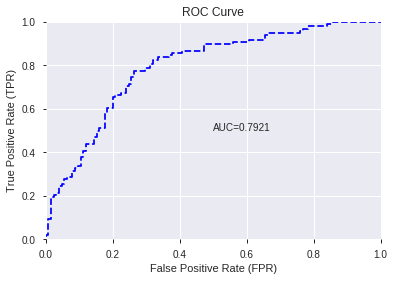

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


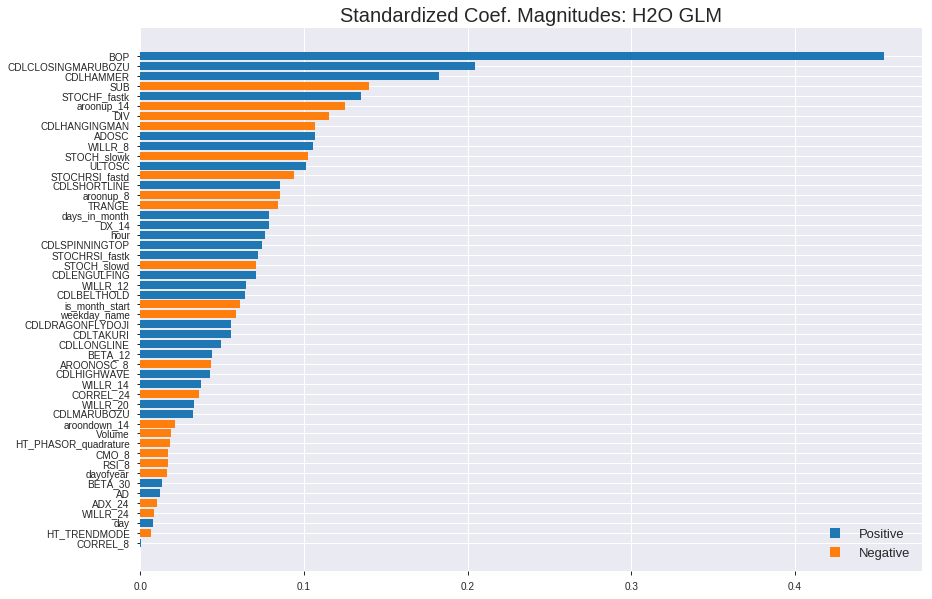

'log_likelihood'
--2019-08-25 16:51:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_165131_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_165131_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'SUB',
 'STOCHF_fastk',
 'aroonup_14',
 'DIV',
 'CDLHANGINGMAN',
 'ADOSC',
 'WILLR_8',
 'STOCH_slowk',
 'ULTOSC',
 'STOCHRSI_fastd',
 'CDLSHORTLINE',
 'aroonup_8',
 'TRANGE',
 'days_in_month',
 'DX_14',
 'hour',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'CDLENGULFING',
 'WILLR_12',
 'CDLBELTHOLD',
 'is_month_start',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLLONGLINE',
 'BETA_12',
 'AROONOSC_8',
 'CDLHIGHWAVE',
 'WILLR_14',
 'CORREL_24',
 'WILLR_20',
 'CDLMARUBOZU',
 'aroondown_14',
 'Volume',
 'HT_PHASOR_quadrature',
 'CMO_8',
 'RSI_8',
 'dayofyear',
 'BETA_30',
 'AD',
 'ADX_24',
 'WILLR_24',
 'day',
 'HT_TRENDMODE',
 'CORREL_8']

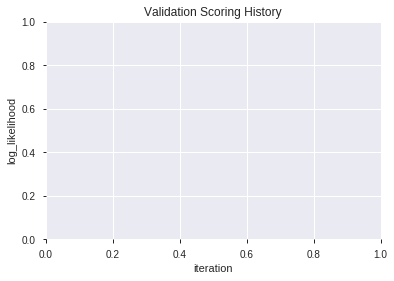

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_165146_model_1  0.781061  0.569150              0.288122  0.439862  0.193479
1  XGBoost_grid_1_AutoML_20190825_165146_model_5  0.778776  0.571444              0.305224  0.438685  0.192444
2  XGBoost_grid_1_AutoML_20190825_165146_model_2  0.778041  0.569791              0.283837  0.439984  0.193586
3               XGBoost_3_AutoML_20190825_165146  0.777551  0.566195              0.270041  0.438039  0.191878
4  XGBoost_grid_1_AutoML_20190825_165146_model_3  0.774367  0.571531              0.268245  0.439866  0.193482
5  XGBoost_grid_1_AutoML_20190825_165146_model_6  0.773633  0.572380              0.298612  0.442093  0.195446
6               XGBoost_2_AutoML_20190825_165146  0.770939  0.577932              0.285224  0.443263  0.196482
7               XGBoost_1_AutoML_20190825_165146  0.770367  0.581465              0.300122  0.444826  0.197870
8  XGBoost_grid_1_AutoML_20190825_165146_model_4  0.764898  0.578903              0.283837  0.444411  0.197501
9  XGBoost_grid_1_AutoML_20190825_165146_model_7  0.762449  0.585934              0.334612  0.446720  0.199559

variable  relative_importance  scaled_importance  percentage
0                    BOP          3179.066162           1.000000    0.352127
1                 TRANGE           528.541626           0.166257    0.058544
2                    DIV           439.977844           0.138398    0.048734
3         STOCHRSI_fastk           311.619354           0.098022    0.034516
4           STOCHF_fastk           290.177307           0.091278    0.032141
5     CDLCLOSINGMARUBOZU           283.216034           0.089088    0.031370
6              CDLHAMMER           259.214142           0.081538    0.028712
7              CORREL_24           244.708160           0.076975    0.027105
8                    SUB           242.681152           0.076337    0.026880
9                WILLR_8           242.164047           0.076175    0.026823
10               BETA_12           226.895660           0.071372    0.025132
11                ADX_24           211.416473           0.066503    0.023417
12                 ADOSC           185.962708           0.058496    0.020598
13           STOCH_slowk           167.468597           0.052679    0.018550
14                 DX_14           165.056656           0.051920    0.018282
15  HT_PHASOR_quadrature           162.576324           0.051140    0.018008
16                Volume           159.873184           0.050289    0.017708
17             dayofyear           145.619370           0.045806    0.016129
18              CORREL_8           127.739815           0.040182    0.014149
19            aroonup_14           121.841255           0.038326    0.013496
20                ULTOSC           116.098808           0.036520    0.012860
21              WILLR_24           113.192978           0.035606    0.012538
22        STOCHRSI_fastd           106.044716           0.033357    0.011746
23                    AD            98.756996           0.031065    0.010939
24                   day            88.157860           0.027731    0.009765
25               BETA_30            87.431541           0.027502    0.009684
26           STOCH_slowd            78.804718           0.024789    0.008729
27                  hour            76.682892           0.024121    0.008494
28             aroonup_8            76.309502           0.024004    0.008452
29                 CMO_8            65.984467           0.020756    0.007309
30            AROONOSC_8            64.341156           0.020239    0.007127
31              WILLR_20            59.608788           0.018750    0.006603
32              WILLR_12            50.772160           0.015971    0.005624
33          aroondown_14            44.909363           0.014127    0.004974
34         CDLHANGINGMAN            38.553131           0.012127    0.004270
35              WILLR_14            37.147064           0.011685    0.004115
36      CDLDRAGONFLYDOJI            34.840862           0.010959    0.003859
37                 RSI_8            32.234383           0.010140    0.003570
38         days_in_month            23.408440           0.007363    0.002593
39          weekday_name            10.942615           0.003442    0.001212
40           CDLBELTHOLD            10.255738           0.003226    0.001136
41          CDLSHORTLINE             9.541529           0.003001    0.001057
42           CDLLONGLINE             4.864745           0.001530    0.000539
43          HT_TRENDMODE             3.471046           0.001092    0.000384

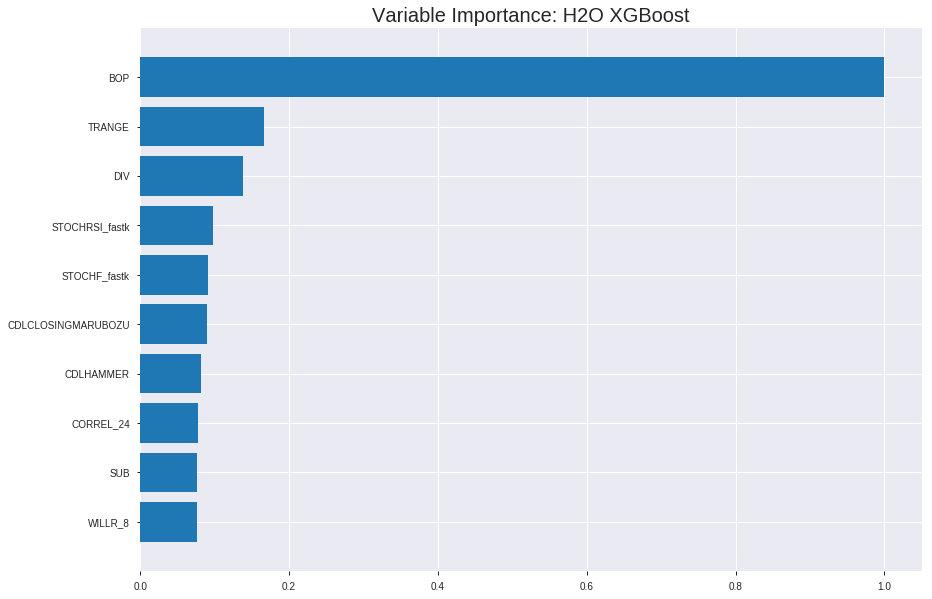

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_165146_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1266416277610197
RMSE: 0.35586743003683224
LogLoss: 0.41027620596501324
Mean Per-Class Error: 0.15950674239981477
AUC: 0.9226240378335028
pr_auc: 0.9267578707669873
Gini: 0.8452480756670055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4605250159899394: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      588  167  0.2212   (167.0/755.0)
1      82   719  0.1024   (82.0/801.0)
Total  670  886  0.16     (249.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460525     0.852401  224
max f2                       0.313704     0.904598  287
max f0point5                 0.605923     0.85595   158
max accuracy                 0.491164     0.84126   211
max precision                0.95178      1         0
max recall                   0.164999     1         347
max specificity              0.95178      1         0
max absolute_mcc             0.476016     0.683621  218
max min_per_class_accuracy   0.508777     0.838411  202
max mean_per_class_accuracy  0.491164     0.840493  211

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.933996           1.94257   1.94257            1                0.942317   1                           0.942317            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.924746           1.94257   1.94257            1                0.929622   1                           0.935969            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.915937           1.94257   1.94257            1                0.920749   1                           0.931112            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.90708            1.94257   1.94257            1                0.911315   1                           0.926084            0.019975        0.0786517                  94.2572   94.2572
    5        0.0501285                   0.895583           1.94257   1.94257            1                0.900365   1                           0.921138            0.0187266       0.0973783                  94.2572   94.2572
    6        0.100257                    0.858886           1.94257   1.94257            1                0.875789   1                           0.898463            0.0973783       0.194757                   94.2572   94.2572
    7        0.150386                    0.82456            1.94257   1.94257            1                0.841821   1                           0.879583            0.0973783       0.292135                   94.2572   94.2572
    8        0.200514                    0.784052           1.89276   1.93012            0.974359         0.8049     0.99359                     0.860912            0.0948814       0.387016                   89.2762   93.0119
    9        0.300129                    0.714729           1.67938   1.8469             0.864516         0.750399   0.950749                    0.824232            0.167291        0.554307                   67.9385   84.6899
    10       0.400386                    0.614204           1.45693   1.74925            0.75             0.666485   0.900482                    0.784732            0.146067        0.700375                   45.6929   74.925
    11       0.5                         0.517163           1.24074   1.64794            0.63871          0.565909   0.848329                    0.741136            0.123596        0.82397                    24.0739   64.794
    12       0.600257                    0.430417           0.971286  1.53492            0.5              0.475216   0.79015                     0.696721            0.0973783       0.921348                   -2.87141  53.4923
    13       0.699871                    0.342638           0.438645  1.37889            0.225806         0.382699   0.709826                    0.652026            0.0436954       0.965044                   -56.1355  37.8887
    14       0.800129                    0.24369            0.224143  1.2342             0.115385         0.293864   0.635341                    0.607148            0.0224719       0.987516                   -77.5857  23.4196
    15       0.899743                    0.138413           0.125327  1.11143            0.0645161        0.185301   0.572143                    0.560443            0.0124844       1                          -87.4673  11.1429
    16       1                           0.0446715          0         1                  0                0.0990733  0.514781                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1838375987616452
RMSE: 0.42876287008280606
LogLoss: 0.5428613717398879
Mean Per-Class Error: 0.2642324223501744
AUC: 0.7997830670667424
pr_auc: 0.7615704184358911
Gini: 0.5995661341334848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2923279106616974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  104  0.4407   (104.0/236.0)
1      27   182  0.1292   (27.0/209.0)
Total  159  286  0.2944   (131.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292328     0.735354  259
max f2                       0.128207     0.853355  336
max f0point5                 0.607233     0.719557  135
max accuracy                 0.440777     0.734831  199
max precision                0.944628     1         0
max recall                   0.0785272    1         373
max specificity              0.944628     1         0
max absolute_mcc             0.434192     0.470668  201
max min_per_class_accuracy   0.462621     0.724576  195
max mean_per_class_accuracy  0.434192     0.735768  201

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 45.23 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.928352           2.12919    2.12919            1                0.93566    1                           0.93566             0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.914561           1.59689    1.89261            0.75             0.91919    0.888889                    0.92834             0.0143541       0.0382775                  59.689    89.261
    3        0.0314607                   0.909917           2.12919    1.9771             1                0.913007   0.928571                    0.922864            0.0239234       0.062201                   112.919   97.7102
    4        0.0404494                   0.903674           2.12919    2.0109             1                0.906904   0.944444                    0.919317            0.0191388       0.0813397                  112.919   101.09
    5        0.0516854                   0.892663           2.12919    2.03661            1                0.895932   0.956522                    0.914234            0.0239234       0.105263                   112.919   103.661
    6        0.101124                    0.843809           1.74206    1.89261            0.818182         0.868874   0.888889                    0.892058            0.0861244       0.191388                   74.2062   89.261
    7        0.150562                    0.790449           1.5485     1.77962            0.727273         0.814319   0.835821                    0.866532            0.076555        0.267943                   54.8499   77.9619
    8        0.2                         0.750322           1.45172    1.69856            0.681818         0.766857   0.797753                    0.841893            0.0717703       0.339713                   45.1718   69.8565
    9        0.301124                    0.654982           1.51409    1.63661            0.711111         0.702715   0.768657                    0.795154            0.15311         0.492823                   51.4088   63.6614
    10       0.4                         0.548547           1.25816    1.54306            0.590909         0.599189   0.724719                    0.746713            0.124402        0.617225                   25.8156   54.3062
    11       0.501124                    0.434192           1.32483    1.49902            0.622222         0.491567   0.704036                    0.695226            0.133971        0.751196                   32.4827   49.9024
    12       0.6                         0.344577           0.725859   1.37161            0.340909         0.388273   0.644195                    0.644642            0.0717703       0.822967                   -27.4141  37.1611
    13       0.698876                    0.220416           0.725859   1.28025            0.340909         0.283381   0.601286                    0.593531            0.0717703       0.894737                   -27.4141  28.025
    14       0.8                         0.149452           0.709729   1.20813            0.333333         0.187214   0.567416                    0.542171            0.0717703       0.966507                   -29.0271  20.8134
    15       0.898876                    0.0882312          0.290344   1.10718            0.136364         0.115914   0.52                        0.495283            0.0287081       0.995215                   -70.9656  10.7177
    16       1                           0.04129            0.0473153  1                  0.0222222        0.0703042  0.469663     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:52:00  0.030 sec   0                  0.5              0.693147            0.5             0                  1                0.485219                         0.5                0.693147              0.5               0                    1                  0.530337
    2019-08-25 16:52:00  0.105 sec   5                  0.466458         0.627756            0.844969        0.841512           1.94257          0.261568                         0.470491           0.635292              0.785966          0.738507             1.70335            0.301124
    2019-08-25 16:52:00  0.156 sec   10                 0.442667         0.582239            0.858174        0.852033           1.94257          0.217866                         0.452484           0.599816              0.791755          0.756562             1.70335            0.31236
    2019-08-25 16:52:00  0.231 sec   15                 0.424536         0.547332            0.869799        0.873658           1.94257          0.217224                         0.442313           0.578632              0.793316          0.760994             2.12919            0.296629
    2019-08-25 16:52:00  0.304 sec   20                 0.411486         0.52139             0.875737        0.879252           1.94257          0.208226                         0.436125           0.564561              0.791957          0.754305             1.70335            0.319101
    2019-08-25 16:52:01  0.379 sec   25                 0.402224         0.502375            0.87986         0.885109           1.94257          0.205656                         0.433039           0.5566                0.793518          0.761205             2.12919            0.323596
    2019-08-25 16:52:01  0.446 sec   30                 0.39382          0.485184            0.88686         0.892106           1.94257          0.208226                         0.430554           0.550532              0.796489          0.764335             2.12919            0.283146
    2019-08-25 16:52:01  0.523 sec   35                 0.386467         0.470239            0.893131        0.899482           1.94257          0.188946                         0.429227           0.54658               0.798891          0.763579             2.12919            0.28764
    2019-08-25 16:52:01  0.595 sec   40                 0.379789         0.456827            0.899326        0.904411           1.94257          0.181234                         0.428967           0.544967              0.797948          0.761428             2.12919            0.283146
    2019-08-25 16:52:01  0.673 sec   45                 0.374066         0.445269            0.90471         0.911117           1.94257          0.179306                         0.427941           0.541662              0.800726          0.763403             2.12919            0.289888
    2019-08-25 16:52:01  0.742 sec   50                 0.368832         0.434882            0.90979         0.915933           1.94257          0.16838                          0.427678           0.540909              0.801131          0.763847             2.12919            0.285393
    2019-08-25 16:52:01  0.810 sec   55                 0.364654         0.426631            0.913654        0.91964            1.94257          0.16838                          0.427551           0.540463              0.801577          0.7

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             3179.066162109375      1.0                    0.35212736137979705
TRANGE          528.5416259765625      0.16625688143145292    0.058543596969691296
DIV             439.97784423828125     0.1383984547041786     0.04873388267402377
STOCHRSI_fastk  311.6193542480469      0.09802229282365142    0.034516331328390194
STOCHF_fastk    290.17730712890625     0.0912775300456055     0.03214131580822421
---             ---                    ---                    ---
weekday_name    10.942614555358887     0.003442084561114714   0.001212052154151461
CDLBELTHOLD     10.255738258361816     0.003226022276792417   0.001135970712079359
CDLSHORTLINE    9.541528701782227      0.003001362102967756   0.0010568617178633546
CDLLONGLINE     4.864745140075684      0.0015302434400571979  0.0005388405848160847
HT_TRENDMODE    3.4710464477539062     0.0010918446709680292  0.0003844683830245648


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7160493827160493)

('auc', 0.7810612244897959)

('logloss', 0.5691500644166712)

('mean_per_class_error', 0.27114285714285713)

('rmse', 0.43986231538396986)

('mse', 0.19347885649494698)

xgboost prediction progress: |████████████████████████████████████████████| 100%


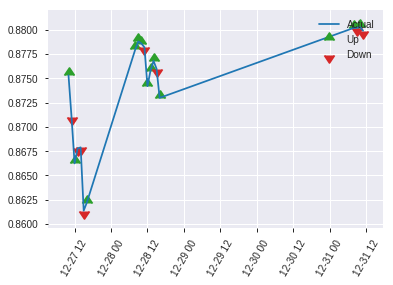


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19347885649494698
RMSE: 0.43986231538396986
LogLoss: 0.5691500644166712
Mean Per-Class Error: 0.27114285714285713
AUC: 0.7810612244897959
pr_auc: 0.6947056337984967
Gini: 0.5621224489795917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22384954988956451: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   58   0.464    (58.0/125.0)
1      11   87   0.1122   (11.0/98.0)
Total  78   145  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.22385      0.716049  144
max f2                       0.10245      0.837607  192
max f0point5                 0.524607     0.692488  81
max accuracy                 0.524607     0.721973  81
max precision                0.932368     1         0
max recall                   0.10245      1         192
max specificity              0.932368     1         0
max absolute_mcc             0.400259     0.455121  117
max min_per_class_accuracy   0.437038     0.688     106
max mean_per_class_accuracy  0.400259     0.728857  117

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 42.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.923101           1.51701   1.51701            0.666667         0.928903  0.666667                    0.928903            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.915315           2.27551   1.82041            1                0.918285  0.8                         0.924656            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.904248           1.13776   1.62536            0.5              0.911615  0.714286                    0.92093             0.0102041       0.0510204                  13.7755   62.5364
    4        0.0403587                   0.898723           2.27551   1.76984            1                0.900381  0.777778                    0.916364            0.0204082       0.0714286                  127.551   76.9841
    5        0.0538117                   0.882279           2.27551   1.89626            1                0.890989  0.833333                    0.91002             0.0306122       0.102041                   127.551   89.6259
    6        0.103139                    0.825739           2.06865   1.9787             0.909091         0.847481  0.869565                    0.88011             0.102041        0.204082                   106.865   97.8705
    7        0.152466                    0.792283           1.65492   1.87395            0.727273         0.806714  0.823529                    0.856364            0.0816327       0.285714                   65.4917   87.395
    8        0.201794                    0.739189           1.03432   1.66871            0.454545         0.760995  0.733333                    0.833052            0.0510204       0.336735                   3.43228   66.8707
    9        0.300448                    0.5853             1.55148   1.63022            0.681818         0.667342  0.716418                    0.77864             0.153061        0.489796                   55.1484   63.0216
    10       0.399103                    0.494224           1.34462   1.55962            0.590909         0.539173  0.685393                    0.719446            0.132653        0.622449                   34.462    55.9619
    11       0.502242                    0.419502           1.08829   1.46283            0.478261         0.452509  0.642857                    0.664628            0.112245        0.734694                   8.82875   46.2828
    12       0.600897                    0.292449           0.930891  1.37549            0.409091         0.369216  0.604478                    0.616128            0.0918367       0.826531                   -6.91095  37.5495
    13       0.699552                    0.185732           0.827458  1.29821            0.363636         0.229226  0.570513                    0.561565            0.0816327       0.908163                   -17.2542  29.8208
    14       0.798206                    0.125152           0.413729  1.18889            0.181818         0.147479  0.522472                    0.510385            0.0408163       0.94898                    -58.6271  18.889
    15       0.896861                    0.0905403          0.517161  1.115              0.227273         0.109581  0.49                        0.466297            0.0510204       1                          -48.2839  11.5
    16       1                           0.056604           0         1                  0                0.077869  0.439462                    0.426235            0 

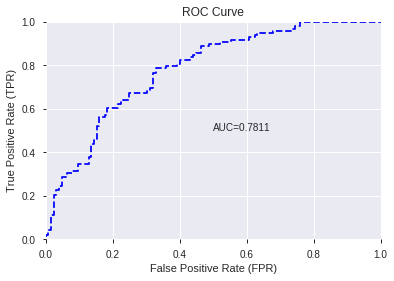

This function is available for GLM models only


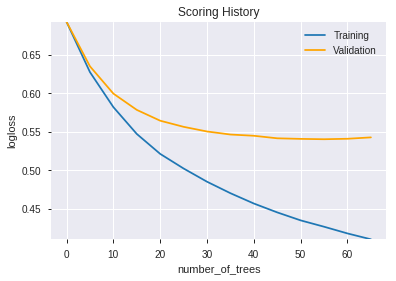

--2019-08-25 16:52:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_165146_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_165146_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CORREL_24',
 'SUB',
 'WILLR_8',
 'BETA_12',
 'ADX_24',
 'ADOSC',
 'STOCH_slowk',
 'DX_14',
 'HT_PHASOR_quadrature',
 'Volume',
 'dayofyear',
 'CORREL_8',
 'aroonup_14',
 'ULTOSC',
 'WILLR_24',
 'STOCHRSI_fastd',
 'AD',
 'day',
 'BETA_30',
 'STOCH_slowd',
 'hour',
 'aroonup_8',
 'CMO_8',
 'AROONOSC_8',
 'WILLR_20',
 'WILLR_12',
 'aroondown_14',
 'CDLHANGINGMAN',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'RSI_8',
 'days_in_month',
 'weekday_name',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_165223_model_1  0.792082  0.549875              0.255837  0.430561  0.185383

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.235615           1.000000  3.537966e-02
1           CDLCLOSINGMARUBOZU             0.127977           0.543163  1.921691e-02
2                    CDLHAMMER             0.103782           0.440473  1.558380e-02
3                          SUB             0.096060           0.407699  1.442425e-02
4                          DIV             0.092475           0.392481  1.388586e-02
...                        ...                  ...                ...           ...
1030                  MAVP_8_7             0.000009           0.000039  1.382581e-06
1031   BBANDS_upperband_14_6_3             0.000005           0.000019  6.865908e-07
1032   BBANDS_lowerband_30_1_3             0.000003           0.000011  3.913021e-07
1033   BBANDS_middleband_8_7_2             0.000002           0.000007  2.517957e-07
1034  BBANDS_middleband_14_7_5             0.000002           0.000007  2.353636e-07

[1035 rows x 4 columns]

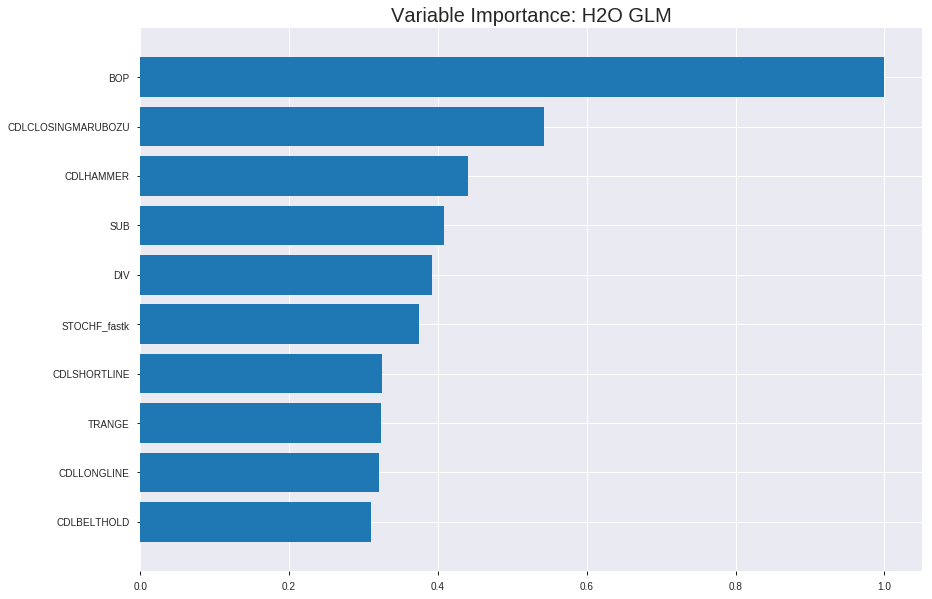

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_165223_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18152891942080723
RMSE: 0.426062107468861
LogLoss: 0.543856263019273
Null degrees of freedom: 1555
Residual degrees of freedom: 520
Null deviance: 2155.7139305761725
Residual deviance: 1692.4806905159776
AIC: 3764.4806905159776
AUC: 0.8173508280212648
pr_auc: 0.8240714768488033
Gini: 0.6347016560425296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47843506201525454: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      509  246  0.3258   (246.0/755.0)
1      152  649  0.1898   (152.0/801.0)
Total  661  895  0.2558   (398.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478435     0.76533   217
max f2                       0.258505     0.858795  332
max f0point5                 0.589684     0.760576  153
max accuracy                 0.507101     0.747429  202
max precision                0.942653     1         0
max recall                   0.107997     1         387
max specificity              0.942653     1         0
max absolute_mcc             0.502532     0.494245  204
max min_per_class_accuracy   0.522706     0.74407   193
max mean_per_class_accuracy  0.507101     0.746695  202

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.868902           1.94257   1.94257            1                0.892064  1                           0.892064            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.855923           1.82116   1.88187            0.9375           0.862572  0.96875                     0.877318            0.0187266       0.0387016                  82.1161   88.1866
    3        0.0302057                   0.840939           1.81307   1.85991            0.933333         0.847425  0.957447                    0.867778            0.0174782       0.0561798                  81.3067   85.9909
    4        0.0404884                   0.821112           1.82116   1.85007            0.9375           0.830098  0.952381                    0.858208            0.0187266       0.0749064                  82.1161   85.0068
    5        0.0501285                   0.803424           1.94257   1.86786            1                0.814766  0.961538                    0.849854            0.0187266       0.093633                   94.2572   86.7857
    6        0.100257                    0.758492           1.76824   1.81805            0.910256         0.780812  0.935897                    0.815333            0.0886392       0.182272                   76.8238   81.8048
    7        0.150386                    0.728981           1.76824   1.80144            0.910256         0.744806  0.92735                     0.791824            0.0886392       0.270911                   76.8238   80.1445
    8        0.200514                    0.695603           1.5441    1.73711            0.794872         0.712521  0.894231                    0.771998            0.0774032       0.348315                   54.4096   73.7107
    9        0.300129                    0.644957           1.4538    1.64307            0.748387         0.670635  0.845824                    0.738355            0.144819        0.493134                   45.3796   64.3075
    10       0.400386                    0.592913           1.2826    1.55281            0.660256         0.618849  0.799358                    0.708431            0.128589        0.621723                   28.2595   55.281
    11       0.5                         0.525827           1.16554   1.47566            0.6              0.559685  0.75964                     0.678796            0.116105        0.737828                   16.5543   47.5655
    12       0.600257                    0.460056           0.83431   1.36854            0.429487         0.493523  0.704497                    0.647851            0.0836454       0.821473                   -16.569   36.8536
    13       0.699871                    0.396954           0.664234  1.26829            0.341935         0.429093  0.652893                    0.616715            0.0661673       0.88764                    -33.5766  26.8291
    14       0.800129                    0.334428           0.498095  1.17178            0.25641          0.368621  0.603213                    0.585628            0.0499376       0.937578                   -50.1905  17.1784
    15       0.899743                    0.237977           0.451178  1.092              0.232258         0.292534  0.562143                    0.553179            0.0449438       0.982522                   -54.8822  9.20029
    16       1                           0.018626           0.174333  1                  0.0897436        0.170192  0.514781                    0.514781          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19622418873313094
RMSE: 0.442971995427624
LogLoss: 0.5771562900803909
Null degrees of freedom: 444
Residual degrees of freedom: -591
Null deviance: 618.886943697008
Residual deviance: 513.669098171548
AIC: 2585.669098171548
AUC: 0.7750081096423648
pr_auc: 0.7039195262936602
Gini: 0.5500162192847295
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4945721842153204: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  85   0.3602   (85.0/236.0)
1      38   171  0.1818   (38.0/209.0)
Total  189  256  0.2764   (123.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494572     0.735484  226
max f2                       0.260316     0.836768  336
max f0point5                 0.540138     0.716929  194
max accuracy                 0.540138     0.737079  194
max precision                0.949207     1         0
max recall                   0.104205     1         383
max specificity              0.949207     1         0
max absolute_mcc             0.529059     0.477353  204
max min_per_class_accuracy   0.540766     0.733051  193
max mean_per_class_accuracy  0.529059     0.738981  204

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.897437           1.70335   1.70335            0.8              0.917808  0.8                         0.917808            0.0191388       0.0191388                  70.3349   70.3349
    2        0.0202247                   0.865321           1.59689   1.65603            0.75             0.885358  0.777778                    0.903386            0.0143541       0.0334928                  59.689    65.6034
    3        0.0314607                   0.851223           1.70335   1.67293            0.8              0.856384  0.785714                    0.8866              0.0191388       0.0526316                  70.3349   67.2932
    4        0.0404494                   0.84494            1.59689   1.65603            0.75             0.850512  0.777778                    0.87858             0.0143541       0.0669856                  59.689    65.6034
    5        0.0516854                   0.827956           2.12919   1.75889            1                0.83199   0.826087                    0.868452            0.0239234       0.0909091                  112.919   75.8893
    6        0.101124                    0.798198           1.5485    1.65603            0.727273         0.809457  0.777778                    0.83961             0.076555        0.167464                   54.8499   65.6034
    7        0.150562                    0.745531           1.5485    1.62072            0.727273         0.779286  0.761194                    0.819802            0.076555        0.244019                   54.8499   62.0724
    8        0.2                         0.713077           1.74206   1.65072            0.818182         0.729999  0.775281                    0.797604            0.0861244       0.330144                   74.2062   65.0718
    9        0.301124                    0.648603           1.2302    1.5095             0.577778         0.684787  0.708955                    0.759718            0.124402        0.454545                   23.0197   50.9498
    10       0.4                         0.587283           1.45172   1.49522            0.681818         0.620554  0.702247                    0.725318            0.143541        0.598086                   45.1718   49.5215
    11       0.501124                    0.536952           1.46677   1.48948            0.688889         0.559732  0.699552                    0.691903            0.148325        0.746411                   46.6773   48.9476
    12       0.6                         0.479723           0.871031  1.38756            0.409091         0.509868  0.651685                    0.661905            0.0861244       0.832536                   -12.8969  38.756
    13       0.698876                    0.407817           0.77425   1.30079            0.363636         0.442804  0.610932                    0.630907            0.076555        0.909091                   -22.575   30.0789
    14       0.8                         0.303948           0.331207  1.17823            0.155556         0.35371   0.553371                    0.595868            0.0334928       0.942584                   -66.8793  17.823
    15       0.898876                    0.188007           0.435515  1.09653            0.204545         0.252012  0.515                       0.558044            0.0430622       0.985646                   -56.4485  9.65311
    16       1                           0.0222917          0.141946  1                  0.0666667        0.122555  0.469663                    0.514006           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:52:26  0.000 sec   2            22        1036          1.35333           1.37186
    2019-08-25 16:52:28  1.799 sec   4            16        1036          1.34512           1.36149
    2019-08-25 16:52:30  3.561 sec   6            12        1036          1.335             1.34992
    2019-08-25 16:52:32  5.502 sec   8            8.6       1036          1.32278           1.33588
    2019-08-25 16:52:33  7.285 sec   10           6.3       1036          1.30819           1.31919
    2019-08-25 16:52:35  9.052 sec   12           4.6       1036          1.29108           1.30014
    2019-08-25 16:52:37  10.822 sec  14           3.3       1036          1.27153           1.2791
    2019-08-25 16:52:39  12.588 sec  16           2.4       1036          1.24977           1.25691
    2019-08-25 16:52:41  14.437 sec  18           1.8       1036          1.22632           1.23447
    2019-08-25 16:52:42  16.237 sec  20           1.3       1036          1.20182           1.21289
    2019-08-25 16:52:44  17.972 sec  22           0.93      1036          1.17705           1.19345
    2019-08-25 16:52:46  19.724 sec  24           0.68      1036          1.15274           1.17698
    2019-08-25 16:52:48  21.538 sec  26           0.5       1036          1.12949           1.16453
    2019-08-25 16:52:49  23.305 sec  28           0.36      1036          1.10774           1.15678
    2019-08-25 16:52:51  25.074 sec  30           0.26      1036          1.08771           1.15431
    2019-08-25 16:52:53  26.853 sec  32           0.19      1036          1.06952           1.15689
    2019-08-25 16:52:55  28.624 sec  34           0.14      1036          1.05301           1.16443
    2019-08-25 16:52:57  30.508 sec  36           0.1       1036          1.03804           1.17655
    2019-08-25 16:52:59  32.317 sec  38           0.074     1036          1.02438           1.19282
    2019-08-25 16:53:00  34.117 sec  40           0.054     1036          1.01186           1.21255

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7305936073059361)

('auc', 0.7920816326530612)

('logloss', 0.5498752195533171)

('mean_per_class_error', 0.25583673469387747)

('rmse', 0.4305607233319502)

('mse', 0.1853825364761322)

glm prediction progress: |████████████████████████████████████████████████| 100%


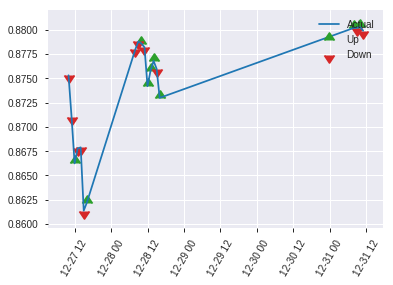


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1853825364761322
RMSE: 0.4305607233319502
LogLoss: 0.5498752195533171
Null degrees of freedom: 222
Residual degrees of freedom: -813
Null deviance: 310.9354893756444
Residual deviance: 245.24434792077943
AIC: 2317.2443479207795
AUC: 0.7920816326530612
pr_auc: 0.7241756508992929
Gini: 0.5841632653061224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41553808270154646: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   41   0.328    (41.0/125.0)
1      18   80   0.1837   (18.0/98.0)
Total  102  121  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415538     0.730594  120
max f2                       0.133035     0.816498  201
max f0point5                 0.512215     0.708155  91
max accuracy                 0.512215     0.73991   91
max precision                0.912755     1         0
max recall                   0.0965247    1         213
max specificity              0.912755     1         0
max absolute_mcc             0.415538     0.486503  120
max min_per_class_accuracy   0.476196     0.734694  104
max mean_per_class_accuracy  0.415538     0.744163  120

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 44.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.853325           2.27551   2.27551            1                0.882729  1                           0.882729            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.847535           1.13776   1.82041            0.5              0.848758  0.8                         0.86914             0.0102041       0.0408163                  13.7755   82.0408
    3        0.0313901                   0.836015           2.27551   1.95044            1                0.846435  0.857143                    0.862653            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.813086           2.27551   2.02268            1                0.829445  0.888889                    0.855274            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.803941           1.51701   1.89626            0.666667         0.806756  0.833333                    0.843144            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.74551            2.06865   1.9787             0.909091         0.773951  0.869565                    0.810052            0.102041        0.204082                   106.865   97.8705
    7        0.152466                    0.706244           1.44805   1.80702            0.636364         0.729231  0.794118                    0.783904            0.0714286       0.27551                    44.8052   80.7023
    8        0.201794                    0.651221           1.44805   1.71927            0.636364         0.6731    0.755556                    0.756819            0.0714286       0.346939                   44.8052   71.9274
    9        0.300448                    0.588217           1.55148   1.66418            0.681818         0.616225  0.731343                    0.710654            0.153061        0.5                        55.1484   66.4179
    10       0.399103                    0.516473           1.44805   1.61075            0.636364         0.550014  0.707865                    0.670945            0.142857        0.642857                   44.8052   61.0754
    11       0.502242                    0.447722           1.08829   1.50346            0.478261         0.488527  0.660714                    0.633484            0.112245        0.755102                   8.82875   50.3462
    12       0.600897                    0.371778           1.03432   1.42644            0.454545         0.409318  0.626866                    0.596681            0.102041        0.857143                   3.43228   42.6439
    13       0.699552                    0.298202           0.206865  1.25445            0.0909091        0.336415  0.551282                    0.559977            0.0204082       0.877551                   -79.3135  25.4448
    14       0.798206                    0.230055           0.620594  1.17611            0.272727         0.259753  0.516854                    0.52287             0.0612245       0.938776                   -37.9406  17.6106
    15       0.896861                    0.133399           0.413729  1.09224            0.181818         0.180149  0.48                        0.485171            0.0408163       0.979592                   -58.6271  9.22449
    16       1                           0.0180836          0.19787   1                  0.0869565        0.089475  0.439462                    0.444359         

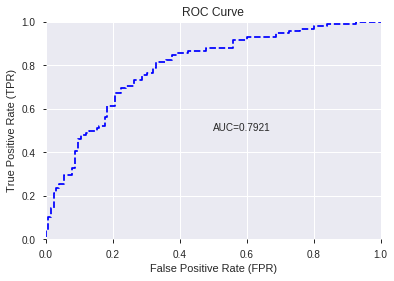

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


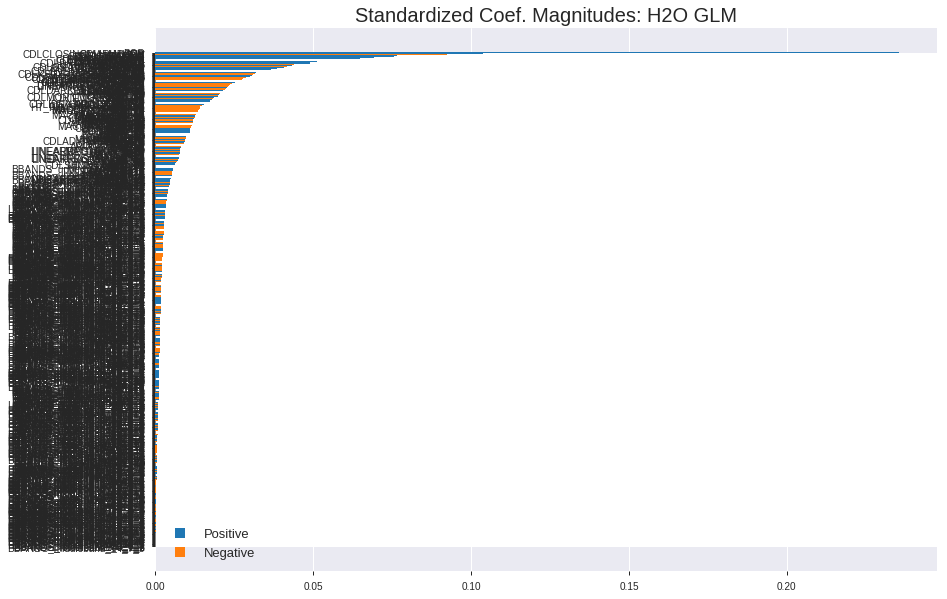

'log_likelihood'
--2019-08-25 16:53:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_165223_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_165223_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

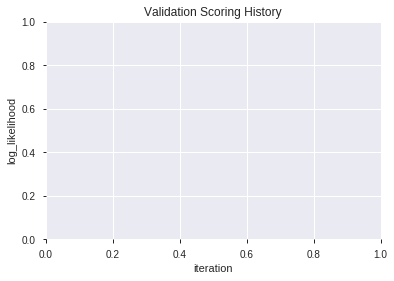

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_165329_model_3  0.798776  0.543518              0.246857  0.426396  0.181814
1  XGBoost_grid_1_AutoML_20190825_165329_model_5  0.792816  0.554303              0.277918  0.432074  0.186688
2  XGBoost_grid_1_AutoML_20190825_165329_model_6  0.786449  0.559348              0.266735  0.432966  0.187459
3               XGBoost_3_AutoML_20190825_165329  0.779673  0.562457              0.268245  0.435556  0.189709
4  XGBoost_grid_1_AutoML_20190825_165329_model_1  0.778531  0.567854              0.285633  0.437274  0.191208
5               XGBoost_1_AutoML_20190825_165329  0.776082  0.564869              0.285633  0.437259  0.191196
6  XGBoost_grid_1_AutoML_20190825_165329_model_7  0.774531  0.569660              0.286327  0.438368  0.192167
7  XGBoost_grid_1_AutoML_20190825_165329_model_2  0.774122  0.568414              0.306612  0.438437  0.192227
8               XGBoost_2_AutoML_20190825_165329  0.773224  0.569037              0.278327  0.439072  0.192784
9  XGBoost_grid_1_AutoML_20190825_165329_model_4  0.769061  0.569316              0.271837  0.439215  0.192910

variable  relative_importance  scaled_importance  percentage
0                        BOP          1794.344971           1.000000    0.197513
1                        SUB           379.223541           0.211344    0.041743
2               STOCHF_fastk           370.107758           0.206263    0.040740
3                        DIV           235.416367           0.131199    0.025913
4         CDLCLOSINGMARUBOZU           202.462326           0.112834    0.022286
..                       ...                  ...                ...         ...
353  BBANDS_upperband_20_7_3             0.425882           0.000237    0.000047
354                 SAR_0.14             0.417191           0.000233    0.000046
355                   MA_8_0             0.282232           0.000157    0.000031
356   BBANDS_lowerband_8_4_2             0.252416           0.000141    0.000028
357   BBANDS_lowerband_8_7_5             0.126362           0.000070    0.000014

[358 rows x 4 columns]

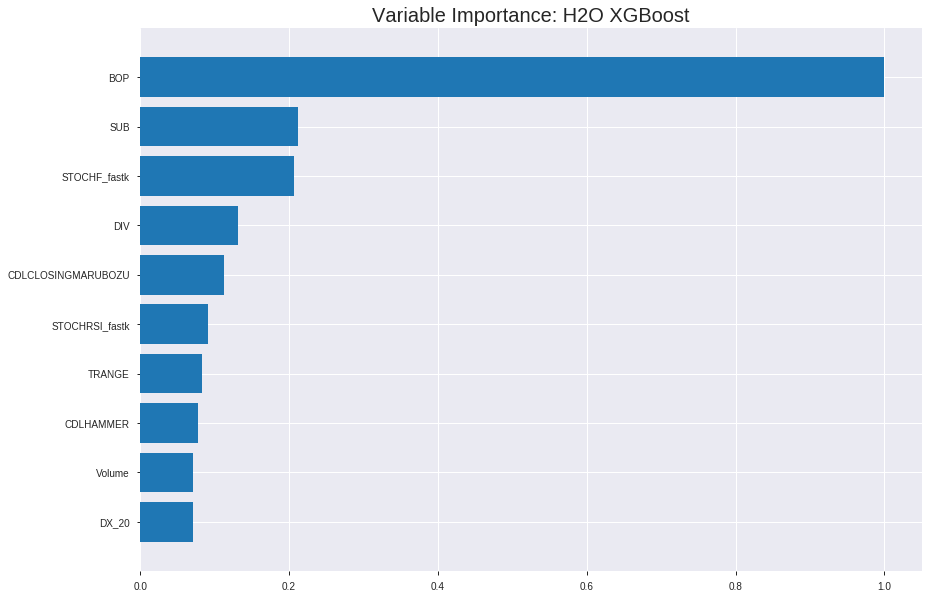

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_165329_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10906379171840225
RMSE: 0.3302480760252847
LogLoss: 0.3720486944534156
Mean Per-Class Error: 0.11941364684872391
AUC: 0.9545824342088945
pr_auc: 0.9546016887386078
Gini: 0.9091648684177891
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5041109323501587: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      649  106  0.1404   (106.0/755.0)
1      83   718  0.1036   (83.0/801.0)
Total  732  824  0.1215   (189.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504111     0.883692  204
max f2                       0.308184     0.926699  285
max f0point5                 0.580357     0.900196  169
max accuracy                 0.526354     0.880463  194
max precision                0.941346     1         0
max recall                   0.209549     1         329
max specificity              0.941346     1         0
max absolute_mcc             0.526354     0.760916  194
max min_per_class_accuracy   0.522192     0.878146  196
max mean_per_class_accuracy  0.526354     0.880586  194

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.92134            1.94257    1.94257            1                0.930925  1                           0.930925            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.908343           1.94257    1.94257            1                0.914282  1                           0.922603            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.901293           1.94257    1.94257            1                0.905727  1                           0.917217            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.894556           1.94257    1.94257            1                0.897107  1                           0.91211             0.019975        0.0786517                  94.2572   94.2572
    5        0.0501285                   0.884413           1.94257    1.94257            1                0.888114  1                           0.907495            0.0187266       0.0973783                  94.2572   94.2572
    6        0.100257                    0.85854            1.94257    1.94257            1                0.871763  1                           0.889629            0.0973783       0.194757                   94.2572   94.2572
    7        0.150386                    0.827492           1.94257    1.94257            1                0.842694  1                           0.873984            0.0973783       0.292135                   94.2572   94.2572
    8        0.200514                    0.799285           1.91767    1.93635            0.987179         0.812556  0.996795                    0.858627            0.0961298       0.388265                   91.7667   93.6346
    9        0.300129                    0.727811           1.85484    1.90929            0.954839         0.767579  0.982869                    0.828408            0.184769        0.573034                   85.4843   90.9294
    10       0.400386                    0.621328           1.61881    1.83656            0.833333         0.674718  0.945425                    0.789924            0.162297        0.735331                   61.881    83.6557
    11       0.5                         0.530298           1.32847    1.73533            0.683871         0.574186  0.893316                    0.746943            0.132335        0.867665                   32.8468   73.5331
    12       0.600257                    0.415507           0.722238   1.56612            0.371795         0.475489  0.80621                     0.701603            0.0724095       0.940075                   -27.7762  56.6121
    13       0.699871                    0.313651           0.526374   1.41813            0.270968         0.367152  0.730028                    0.654               0.0524345       0.992509                   -47.3626  41.8131
    14       0.800129                    0.223939           0.0622619  1.24824            0.0320513        0.268078  0.64257                     0.605644            0.0062422       0.998752                   -93.7738  24.8239
    15       0.899743                    0.143393           0.0125327  1.11143            0.00645161       0.182433  0.572143                    0.558788            0.00124844      1                          -98.7467  11.1429
    16       1                           0.0422272          0          1                  0                0.106348  0.514781                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17821827214902242
RMSE: 0.4221590602474646
LogLoss: 0.5316529295898882
Mean Per-Class Error: 0.25302084178087747
AUC: 0.8098086124401914
pr_auc: 0.770206343135336
Gini: 0.6196172248803828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40595653653144836: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  78   0.3305   (78.0/236.0)
1      38   171  0.1818   (38.0/209.0)
Total  196  249  0.2607   (116.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405957     0.746725  223
max f2                       0.224892     0.862795  315
max f0point5                 0.450957     0.718668  208
max accuracy                 0.450957     0.74382   208
max precision                0.916819     1         0
max recall                   0.0736278    1         397
max specificity              0.916819     1         0
max absolute_mcc             0.44492      0.49441   213
max min_per_class_accuracy   0.487942     0.728814  193
max mean_per_class_accuracy  0.44492      0.746979  213

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 47.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.903634           2.12919    2.12919            1                0.912747  1                           0.912747            0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.885264           2.12919    2.12919            1                0.895525  1                           0.905093            0.0191388       0.0430622                  112.919   112.919
    3        0.0314607                   0.879861           2.12919    2.12919            1                0.881746  1                           0.896755            0.0239234       0.0669856                  112.919   112.919
    4        0.0404494                   0.873404           1.59689    2.0109             0.75             0.877874  0.944444                    0.892559            0.0143541       0.0813397                  59.689    101.09
    5        0.0516854                   0.858              2.12919    2.03661            1                0.864793  0.956522                    0.886523            0.0239234       0.105263                   112.919   103.661
    6        0.101124                    0.808227           1.5485     1.79798            0.727273         0.827824  0.844444                    0.857826            0.076555        0.181818                   54.8499   79.798
    7        0.150562                    0.774815           1.93562    1.84318            0.909091         0.790392  0.865672                    0.835683            0.0956938       0.277512                   93.5624   84.3176
    8        0.2                         0.724557           1.5485     1.77033            0.727273         0.740987  0.831461                    0.812275            0.076555        0.354067                   54.8499   77.0335
    9        0.301124                    0.633295           1.37214    1.63661            0.644444         0.6787    0.768657                    0.767418            0.138756        0.492823                   37.2142   63.6614
    10       0.4                         0.55865            1.20977    1.5311             0.568182         0.597225  0.719101                    0.725348            0.119617        0.61244                    20.9765   53.11
    11       0.501124                    0.472578           1.32483    1.48948            0.622222         0.51555   0.699552                    0.683012            0.133971        0.746411                   32.4827   48.9476
    12       0.6                         0.368634           0.967812   1.40351            0.454545         0.418689  0.659176                    0.639453            0.0956938       0.842105                   -3.21879  40.3509
    13       0.698876                    0.301071           0.82264    1.32133            0.386364         0.333571  0.620579                    0.596177            0.0813397       0.923445                   -17.736   32.1328
    14       0.8                         0.217586           0.567783   1.22608            0.266667         0.255658  0.575843                    0.553134            0.0574163       0.980861                   -43.2217  22.6077
    15       0.898876                    0.143507           0.0967812  1.10185            0.0454545        0.180625  0.5175                      0.512158            0.00956938      0.990431                   -90.3219  10.1854
    16       1                           0.0551281          0.0946305  1                  0.0444444        0.108888  0.469663                    0.4


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:53:54  7.647 sec   0                  0.5              0.693147            0.5             0                  1                0.485219                         0.5                0.693147              0.5               0                    1                  0.530337
    2019-08-25 16:53:55  8.326 sec   5                  0.466527         0.627975            0.867823        0.870027           1.94257          0.208226                         0.475328           0.644657              0.784983          0.757182             2.12919            0.278652
    2019-08-25 16:53:55  8.634 sec   10                 0.443901         0.585114            0.880683        0.884768           1.94257          0.217866                         0.459629           0.614236              0.799134          0.76469              2.12919            0.267416
    2019-08-25 16:53:55  8.934 sec   15                 0.425142         0.549664            0.88923         0.893302           1.94257          0.190231                         0.445948           0.587238              0.804963          0.774424             2.12919            0.258427
    2019-08-25 16:53:56  9.241 sec   20                 0.409416         0.519829            0.898895        0.902986           1.94257          0.196015                         0.437283           0.56932               0.810985          0.781827             2.12919            0.274157
    2019-08-25 16:53:56  9.562 sec   25                 0.394267         0.490673            0.906064        0.911883           1.94257          0.178021                         0.430979           0.555783              0.809849          0.77962              2.12919            0.265169
    2019-08-25 16:53:56  9.865 sec   30                 0.384584         0.471828            0.912565        0.9184             1.94257          0.174807                         0.427838           0.548769              0.811025          0.781568             2.12919            0.265169
    2019-08-25 16:53:57  10.174 sec  35                 0.376125         0.455814            0.919247        0.924664           1.94257          0.167738                         0.42645            0.545502              0.812414          0.77821              2.12919            0.265169
    2019-08-25 16:53:57  10.521 sec  40                 0.366715         0.43782             0.926015        0.930674           1.94257          0.152956                         0.424021           0.539222              0.813924          0.781676             2.12919            0.267416
    2019-08-25 16:53:57  10.841 sec  45                 0.359768         0.424771            0.931741        0.934774           1.94257          0.149743                         0.423079           0.536779              0.812698          0.771019             2.12919            0.280899
    2019-08-25 16:53:58  11.176 sec  50                 0.354075         0.413152            0.933611        0.936247           1.94257          0.154242                         0.422021           0.533573              0.812971          0.768107             2.12919            0.274157
    2019-08-25 16:53:58  11.520 sec  55                 0.349513         0.404804            0.937741        0.938757           1.94257          0.147815                         0.421392           0.531777              0.813357          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1794.344970703125      1.0                     0.1975127283278166
SUB                      379.2235412597656      0.21134372010481606     0.04174307477285265
STOCHF_fastk             370.1077575683594      0.20626343518734327     0.04073965383811994
DIV                      235.41636657714844     0.13119905615746738     0.025913483535695808
CDLCLOSINGMARUBOZU       202.4623260498047      0.11283355728997228     0.022286063747275427
---                      ---                    ---                     ---
BBANDS_upperband_20_7_3  0.42588233947753906    0.0002373469686326005   4.687904733496163e-05
SAR_0.14                 0.4171905517578125     0.0002325029793988465   4.5922297805412314e-05
MA_8_0                   0.28223228454589844    0.00015728986853364322  3.1066751072403466e-05
BBANDS_lowerband_8_4_2   0.25241565704345703    0.0001406728701363074   2.7784682382326714e-05
BBANDS_lowerband_8_7_5   0.12636184692382812    7.042227051485671e-05   1.3909294784428906e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7216494845360826)

('auc', 0.7987755102040817)

('logloss', 0.5435183027552994)

('mean_per_class_error', 0.24685714285714289)

('rmse', 0.4263961691256183)

('mse', 0.18181369304500286)

xgboost prediction progress: |████████████████████████████████████████████| 100%


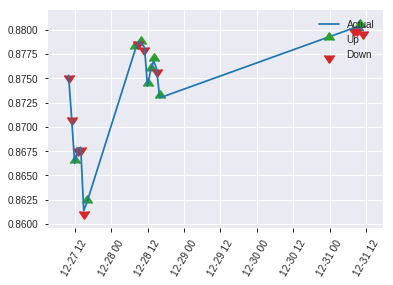


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18181369304500286
RMSE: 0.4263961691256183
LogLoss: 0.5435183027552994
Mean Per-Class Error: 0.24685714285714289
AUC: 0.7987755102040817
pr_auc: 0.7258108749746081
Gini: 0.5975510204081633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518826425075531: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      99   26   0.208    (26.0/125.0)
1      28   70   0.2857   (28.0/98.0)
Total  127  96   0.2422   (54.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518826     0.721649  95
max f2                       0.230934     0.83935   161
max f0point5                 0.552088     0.730594  84
max accuracy                 0.518826     0.757848  95
max precision                0.917374     1         0
max recall                   0.0998604    1         214
max specificity              0.917374     1         0
max absolute_mcc             0.518826     0.507489  95
max min_per_class_accuracy   0.507767     0.72449   99
max mean_per_class_accuracy  0.518826     0.753143  95

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 45.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.91335            2.27551   2.27551            1                0.917023  1                           0.917023            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.888911           2.27551   2.27551            1                0.895865  1                           0.908559            0.0204082       0.0510204                  127.551   127.551
    3        0.0313901                   0.880525           1.13776   1.95044            0.5              0.884976  0.857143                    0.901821            0.0102041       0.0612245                  13.7755   95.0437
    4        0.0403587                   0.873821           2.27551   2.02268            1                0.876577  0.888889                    0.896212            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.866142           1.51701   1.89626            0.666667         0.870237  0.833333                    0.889718            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.79165            1.86178   1.87977            0.818182         0.82571   0.826087                    0.859105            0.0918367       0.193878                   86.1781   87.9769
    7        0.152466                    0.747416           1.65492   1.80702            0.727273         0.764561  0.794118                    0.828518            0.0816327       0.27551                    65.4917   80.7023
    8        0.201794                    0.704584           1.44805   1.71927            0.636364         0.723563  0.755556                    0.802862            0.0714286       0.346939                   44.8052   71.9274
    9        0.300448                    0.625698           1.65492   1.69814            0.727273         0.662298  0.746269                    0.756707            0.163265        0.510204                   65.4917   69.8142
    10       0.399103                    0.543705           1.65492   1.68746            0.727273         0.576738  0.741573                    0.71222             0.163265        0.673469                   65.4917   68.7457
    11       0.502242                    0.462823           0.791482  1.50346            0.347826         0.502843  0.660714                    0.669223            0.0816327       0.755102                   -20.8518  50.3462
    12       0.600897                    0.358749           0.827458  1.39248            0.363636         0.394637  0.61194                     0.624142            0.0816327       0.836735                   -17.2542  39.2476
    13       0.699552                    0.254939           0.827458  1.31279            0.363636         0.307455  0.576923                    0.579481            0.0816327       0.918367                   -17.2542  31.2794
    14       0.798206                    0.196134           0.413729  1.20167            0.181818         0.218936  0.52809                     0.534919            0.0408163       0.959184                   -58.6271  20.1674
    15       0.896861                    0.151808           0.206865  1.09224            0.0909091        0.171228  0.48                        0.494913            0.0204082       0.979592                   -79.3135  9.22449
    16       1                           0.0775179          0.19787   1                  0.0869565        0.115484  0.439462                    0.455779         

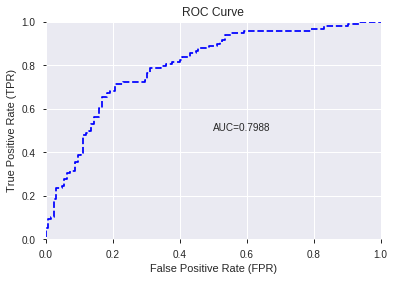

This function is available for GLM models only


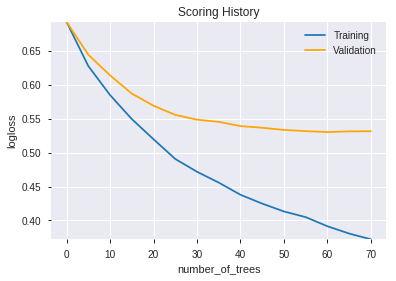

--2019-08-25 16:54:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_165329_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_165329_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_165435_model_5  0.806612  0.528698              0.259429  0.423539  0.179386
1  DeepLearning_grid_1_AutoML_20190825_165435_model_6  0.802286  0.543806              0.245347  0.427979  0.183166
2  DeepLearning_grid_1_AutoML_20190825_165435_model_8  0.800571  0.552991              0.251837  0.434571  0.188852
3  DeepLearning_grid_1_AutoML_20190825_165435_model_4  0.795673  0.747237              0.274449  0.476921  0.227453
4  DeepLearning_grid_1_AutoML_20190825_165435_model_3  0.794449  0.841288              0.263143  0.486965  0.237135
5  DeepLearning_grid_1_AutoML_20190825_165435_model_9  0.793306  0.565270              0.244531  0.440163  0.193743
6  DeepLearning_grid_1_AutoML_20190825_165435_model_7  0.792735  0.870746              0.251020  0.520544  0.270966
7  DeepLearning_grid_1_AutoML_20190825_165435_model_2  0.787755  0.719791              0.269633  0.453972  0.206091
8               DeepLearning_1_AutoML_20190825_165435  0.753306  0.725095              0.301633  0.470870  0.221719
9  DeepLearning_grid_1_AutoML_20190825_165435_model_1  0.735429  1.143358              0.338327  0.510669  0.260783

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.025215
1         STOCHRSI_fastd             0.852789           0.852789    0.021503
2       CDLDRAGONFLYDOJI             0.852246           0.852246    0.021489
3          days_in_month             0.845391           0.845391    0.021317
4     CDLCLOSINGMARUBOZU             0.841797           0.841797    0.021226
5              CDLHAMMER             0.837768           0.837768    0.021124
6         STOCHRSI_fastk             0.832325           0.832325    0.020987
7         is_month_start             0.824982           0.824982    0.020802
8           CDLSHORTLINE             0.816427           0.816427    0.020586
9            CDLHIGHWAVE             0.814643           0.814643    0.020541
10                TRANGE             0.813528           0.813528    0.020513
11                Volume             0.812623           0.812623    0.020490
12                  hour             0.807904           0.807904    0.020371
13                   SUB             0.807765           0.807765    0.020368
14                 DX_14             0.804890           0.804890    0.020295
15               BETA_30             0.804223           0.804223    0.020279
16           STOCH_slowk             0.803099           0.803099    0.020250
17              WILLR_12             0.800706           0.800706    0.020190
18              CORREL_8             0.798992           0.798992    0.020147
19           CDLLONGLINE             0.797801           0.797801    0.020117
20          STOCHF_fastk             0.797604           0.797604    0.020112
21        CDLSPINNINGTOP             0.797587           0.797587    0.020111
22                   day             0.795867           0.795867    0.020068
23             aroonup_8             0.795611           0.795611    0.020061
24  HT_PHASOR_quadrature             0.794662           0.794662    0.020037
25                   DIV             0.791339           0.791339    0.019954
26          weekday_name             0.791271           0.791271    0.019952
27             dayofyear             0.789144           0.789144    0.019898
28                 RSI_8             0.786151           0.786151    0.019823
29            AROONOSC_8             0.784842           0.784842    0.019790
30          HT_TRENDMODE             0.778957           0.778957    0.019642
31                ADX_24             0.778591           0.778591    0.019632
32            aroonup_14             0.774025           0.774025    0.019517
33               WILLR_8             0.772827           0.772827    0.019487
34             CORREL_24             0.766613           0.766613    0.019330
35              WILLR_24             0.765002           0.765002    0.019290
36             CDLTAKURI             0.763508           0.763508    0.019252
37              WILLR_14             0.761130           0.761130    0.019192
38                 ADOSC             0.761081           0.761081    0.019191
39          aroondown_14             0.760841           0.760841    0.019185
40                    AD             0.760075           0.760075    0.019165
41          CDLENGULFING             0.757868           0.757868    0.019110
42                ULTOSC             0.756264           0.756264    0.019069
43           STOCH_slowd             0.754079           0.754079    0.019014
44              WILLR_20             0.751162           0.751162    0.018941
45           CDLBELTHOLD             0.747830           0.747830    0.018857
46         CDLHANGINGMAN             0.742624           0.742624    0.018725
47                 CMO_8             0.740612           0.740612    0.018675
48               BETA_12             0.740565           0.740565    0.018673
49           CDLMARUBOZU             0.731111           0.731111    0.018435

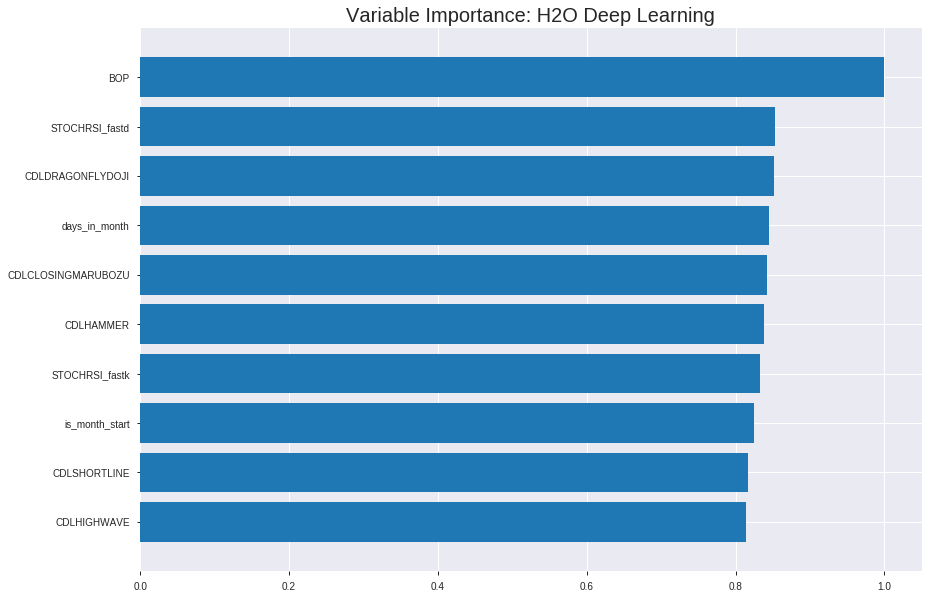

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_165435_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18213813193606215
RMSE: 0.4267764425739337
LogLoss: 0.5446686355039215
Mean Per-Class Error: 0.2662078031599573
AUC: 0.8033120850592388
pr_auc: 0.8001933342914814
Gini: 0.6066241701184776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3709639803534138: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      391  364   0.4821   (364.0/755.0)
1      97   704   0.1211   (97.0/801.0)
Total  488  1068  0.2963   (461.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370964     0.753344  263
max f2                       0.180963     0.860013  336
max f0point5                 0.699425     0.752     136
max accuracy                 0.515825     0.734576  205
max precision                0.994269     1         0
max recall                   0.0270129    1         392
max specificity              0.994269     1         0
max absolute_mcc             0.515825     0.468428  205
max min_per_class_accuracy   0.558684     0.728477  194
max mean_per_class_accuracy  0.515825     0.733792  205

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 54.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.982856           1.69975   1.69975            0.875            0.987683  0.875                       0.987683            0.0174782       0.0174782                  69.975    69.975
    2        0.0205656                   0.974255           1.94257   1.82116            1                0.978764  0.9375                      0.983223            0.019975        0.0374532                  94.2572   82.1161
    3        0.0302057                   0.967863           1.94257   1.85991            1                0.971186  0.957447                    0.979382            0.0187266       0.0561798                  94.2572   85.9909
    4        0.0404884                   0.96078            1.82116   1.85007            0.9375           0.96457   0.952381                    0.97562             0.0187266       0.0749064                  82.1161   85.0068
    5        0.0501285                   0.953767           1.81307   1.84295            0.933333         0.958124  0.948718                    0.972255            0.0174782       0.0923845                  81.3067   84.2953
    6        0.100257                    0.920112           1.71843   1.78069            0.884615         0.936547  0.916667                    0.954401            0.0861423       0.178527                   71.8429   78.0691
    7        0.150386                    0.883445           1.569     1.71013            0.807692         0.903085  0.880342                    0.937296            0.0786517       0.257179                   56.9      71.0127
    8        0.200514                    0.843185           1.49429   1.65617            0.769231         0.863842  0.852564                    0.918932            0.0749064       0.332085                   49.4286   65.6167
    9        0.300129                    0.767001           1.50393   1.60564            0.774194         0.804137  0.826552                    0.880831            0.149813        0.481898                   50.3927   60.5637
    10       0.400386                    0.665756           1.29505   1.52787            0.666667         0.720249  0.786517                    0.840621            0.129838        0.611735                   29.5048   52.7865
    11       0.5                         0.5646             1.10288   1.4432             0.567742         0.612042  0.742931                    0.795081            0.109863        0.721598                   10.2879   44.3196
    12       0.600257                    0.454823           0.896572  1.3519             0.461538         0.503204  0.695931                    0.746331            0.0898876       0.811486                   -10.3428  35.1897
    13       0.699871                    0.353281           0.751963  1.26651            0.387097         0.40484   0.651974                    0.697726            0.0749064       0.886392                   -24.8037  26.6507
    14       0.800129                    0.242682           0.585262  1.18115            0.301282         0.295074  0.608032                    0.647273            0.0586767       0.945069                   -41.4738  18.1146
    15       0.899743                    0.11774            0.363449  1.09062            0.187097         0.181588  0.561429                    0.595715            0.0362047       0.981273                   -63.6551  9.06153
    16       1                           0.00486471         0.186786  1                  0.0961538        0.060684  0.514781                    0.542074          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19508193701402288
RMSE: 0.44168080897184436
LogLoss: 0.5810031715496382
Mean Per-Class Error: 0.2604715757035114
AUC: 0.7822865136647474
pr_auc: 0.7218602725412469
Gini: 0.5645730273294949
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4189415240633942: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      165  71   0.3008   (71.0/236.0)
1      46   163  0.2201   (46.0/209.0)
Total  211  234  0.2629   (117.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418942     0.735892  213
max f2                       0.110019     0.848027  322
max f0point5                 0.418942     0.71179   213
max accuracy                 0.418942     0.737079  213
max precision                0.990082     1         0
max recall                   0.0111595    1         391
max specificity              0.990082     1         0
max absolute_mcc             0.418942     0.478814  213
max min_per_class_accuracy   0.468291     0.717703  197
max mean_per_class_accuracy  0.418942     0.739528  213

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 46.02 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.975225           2.12919    2.12919            1                0.984373   1                           0.984373            0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.96986            1.59689    1.89261            0.75             0.972352   0.888889                    0.97903             0.0143541       0.0382775                  59.689    89.261
    3        0.0314607                   0.961432           1.27751    1.67293            0.6              0.967215   0.785714                    0.97481             0.0143541       0.0526316                  27.7512   67.2932
    4        0.0404494                   0.94724            2.12919    1.77432            1                0.95231    0.833333                    0.96981             0.0191388       0.0717703                  112.919   77.4322
    5        0.0516854                   0.94379            1.70335    1.75889            0.8              0.946106   0.826087                    0.964657            0.0191388       0.0909091                  70.3349   75.8893
    6        0.101124                    0.8952             1.74206    1.75066            0.818182         0.917934   0.822222                    0.941815            0.0861244       0.177033                   74.2062   75.0665
    7        0.150562                    0.833173           1.64528    1.71606            0.772727         0.863549   0.80597                     0.916116            0.0813397       0.258373                   64.5281   71.6061
    8        0.2                         0.785293           1.16137    1.57895            0.545455         0.810938   0.741573                    0.890116            0.0574163       0.315789                   16.1375   57.8947
    9        0.301124                    0.699874           1.41946    1.52539            0.666667         0.745595   0.716418                    0.841583            0.143541        0.45933                    41.9458   52.5387
    10       0.4                         0.583151           1.45172    1.50718            0.681818         0.643656   0.707865                    0.792657            0.143541        0.602871                   45.1718   50.7177
    11       0.501124                    0.446897           1.32483    1.47038            0.622222         0.513376   0.690583                    0.7363              0.133971        0.736842                   32.4827   47.038
    12       0.6                         0.322458           0.967812   1.38756            0.454545         0.381018   0.651685                    0.677752            0.0956938       0.832536                   -3.21879  38.756
    13       0.698876                    0.229438           0.725859   1.29394            0.340909         0.280523   0.607717                    0.621552            0.0717703       0.904306                   -27.4141  29.3943
    14       0.8                         0.102846           0.615098   1.20813            0.288889         0.165046   0.567416                    0.563848            0.062201        0.966507                   -38.4902  20.8134
    15       0.898876                    0.04178            0.241953   1.10185            0.113636         0.0708615  0.5175                      0.509619            0.0239234       0.990431                   -75.8047  10.1854
    16       1                           0.00450405         0.0946305  1                  0.0444444        0.0210099  0.469663    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:57:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:57:21  1 min  6.395 sec  1098 obs/sec      1.4126    1             2198       0.426776         0.544669            0.27081        0.803312        0.800193           1.69975          0.296272                         0.441681           0.581003              0.216789         0.782287          0.72186              2.12919            0.262921
    2019-08-25 16:57:27  1 min 12.190 sec  1801 obs/sec      8.44666   6             13143      0.413877         0.515411            0.314224       0.829753        0.814472           1.94257          0.291131                         0.450201           0.641765              0.186279         0.780472          0.738986             2.12919            0.310112
    2019-08-25 16:57:32  1 min 17.245 sec  2029 obs/sec      15.4614   11            24058      0.393413         0.465278            0.380365       0.858969        0.862501           1.94257          0.26671                          0.457166           0.627823              0.160909         0.760461          0.719326             2.12919            0.325843
    2019-08-25 16:57:38  1 min 22.834 sec  2201 obs/sec      23.9942   17            37335      0.37831          0.430504            0.427024       0.880228        0.878204           1.94257          0.224293                         0.461508           0.686047              0.144894         0.767831          0.72454              2.12919            0.296629
    2019-08-25 16:57:43  1 min 28.130 sec  2326 obs/sec      32.5328   23            50621      0.355126         0.382075            0.495101       0.907542        0.891002           1.94257          0.212082                         0.468541           0.742218              0.118632         0.76852           0.721229             2.12919            0.32809
    2019-08-25 16:57:48  1 min 33.225 sec  2421 obs/sec      41.0334   29            63848      0.335451         0.344081            0.549496       0.928641        0.913592           1.94257          0.182519                         0.479632           0.843178              0.0764121        0.765317          0.715321             2.12919            0.330337
    2019-08-25 16:57:48  1 min 33.740 sec  2419 obs/sec      41.0334   29            63848      0.426776         0.544669            0.27081        0.803312        0.800193           1.69975          0.296272                         0.441681           0.581003              0.216789         0.782287          0.72186              2.12919            0.262921

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.025215120101924345
STOCHRSI_fastd      0.8527888655662537     0.8527888655662537   0.0215031736668369
CDLDRAGONFLYDOJI    0.8522462248802185     0.8522462248802185   0.021489490916766333
days_in_month       0.8453911542892456     0.8453911542892456   0.02131663948850778
CDLCLOSINGMARUBOZU  0.8417969346046448     0.8417969346046448   0.02122601080748787
---                 ---                    ---                  ---
CDLBELTHOLD         0.7478299140930176     0.7478299140930176   0.018856621099667202
CDLHANGINGMAN       0.7426242828369141     0.7426242828369141   0.01872536048233822
CMO_8               0.7406120896339417     0.7406120896339417   0.018674622789056995
BETA_12             0.7405650615692139     0.7405650615692139   0.018673436970756723
CDLMARUBOZU         0.7311111688613892     0.7311111688613892   0.01843505593069822


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7336244541484715)

('auc', 0.8066122448979591)

('logloss', 0.5286983272363193)

('mean_per_class_error', 0.25195918367346937)

('rmse', 0.42353944582746744)

('mse', 0.1793856621718382)

deeplearning prediction progress: |███████████████████████████████████████| 100%


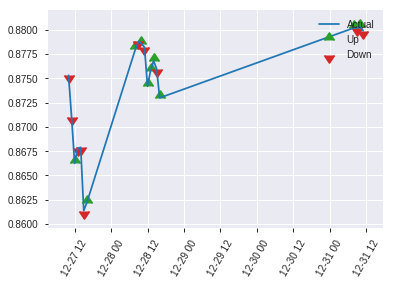


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1793856621718382
RMSE: 0.42353944582746744
LogLoss: 0.5286983272363193
Mean Per-Class Error: 0.25195918367346937
AUC: 0.8066122448979591
pr_auc: 0.7511889764361072
Gini: 0.6132244897959183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31053719406388797: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   47   0.376    (47.0/125.0)
1      14   84   0.1429   (14.0/98.0)
Total  92   131  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310537     0.733624  130
max f2                       0.200736     0.842294  165
max f0point5                 0.455873     0.721757  94
max accuracy                 0.455873     0.753363  94
max precision                0.990032     1         0
max recall                   0.0531078    1         200
max specificity              0.990032     1         0
max absolute_mcc             0.455873     0.497914  94
max min_per_class_accuracy   0.401174     0.734694  104
max mean_per_class_accuracy  0.455873     0.748041  94

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 43.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.979479           2.27551    2.27551            1                0.984113   1                           0.984113            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.966543           2.27551    2.27551            1                0.974882   1                           0.980421            0.0204082       0.0510204                  127.551   127.551
    3        0.0313901                   0.950844           2.27551    2.27551            1                0.956141   1                           0.973484            0.0204082       0.0714286                  127.551   127.551
    4        0.0403587                   0.945173           2.27551    2.27551            1                0.94805    1                           0.967832            0.0204082       0.0918367                  127.551   127.551
    5        0.0538117                   0.914088           2.27551    2.27551            1                0.928319   1                           0.957953            0.0306122       0.122449                   127.551   127.551
    6        0.103139                    0.856593           1.65492    1.9787             0.727273         0.891734   0.869565                    0.926283            0.0816327       0.204082                   65.4917   97.8705
    7        0.152466                    0.795794           1.44805    1.80702            0.636364         0.823992   0.794118                    0.893189            0.0714286       0.27551                    44.8052   80.7023
    8        0.201794                    0.729609           1.65492    1.76984            0.727273         0.756221   0.777778                    0.859708            0.0816327       0.357143                   65.4917   76.9841
    9        0.300448                    0.638577           1.65492    1.7321             0.727273         0.690559   0.761194                    0.804167            0.163265        0.520408                   65.4917   73.2105
    10       0.399103                    0.494122           1.34462    1.63632            0.590909         0.562345   0.719101                    0.74439             0.132653        0.653061                   34.462    63.6322
    11       0.502242                    0.373532           1.18722    1.5441             0.521739         0.428138   0.678571                    0.679446            0.122449        0.77551                    18.7223   54.4096
    12       0.600897                    0.299488           0.827458   1.42644            0.363636         0.327169   0.626866                    0.621609            0.0816327       0.857143                   -17.2542  42.6439
    13       0.699552                    0.237664           0.517161   1.29821            0.227273         0.267152   0.570513                    0.571622            0.0510204       0.908163                   -48.2839  29.8208
    14       0.798206                    0.147995           0.620594   1.21446            0.272727         0.194385   0.533708                    0.524997            0.0612245       0.969388                   -37.9406  21.4458
    15       0.896861                    0.0550422          0.206865   1.10362            0.0909091        0.0990643  0.485                       0.478144            0.0204082       0.989796                   -79.3135  10.3622
    16       1                           0.00585423         0.0989352  1                  0.0434783        0.031731   0.439462 

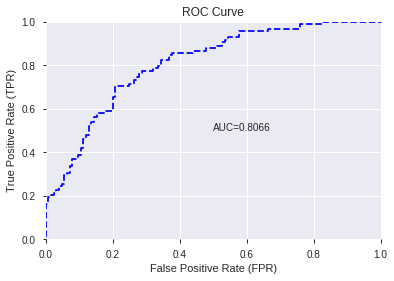

This function is available for GLM models only


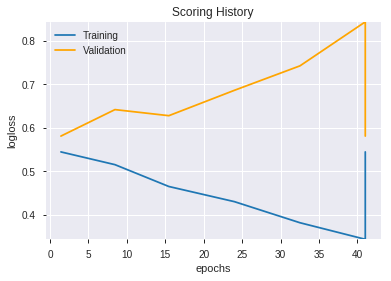

--2019-08-25 17:01:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.92
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.92|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_165435_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_165435_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHRSI_fastd',
 'CDLDRAGONFLYDOJI',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'is_month_start',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'TRANGE',
 'Volume',
 'hour',
 'SUB',
 'DX_14',
 'BETA_30',
 'STOCH_slowk',
 'WILLR_12',
 'CORREL_8',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'CDLSPINNINGTOP',
 'day',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'DIV',
 'weekday_name',
 'dayofyear',
 'RSI_8',
 'AROONOSC_8',
 'HT_TRENDMODE',
 'ADX_24',
 'aroonup_14',
 'WILLR_8',
 'CORREL_24',
 'WILLR_24',
 'CDLTAKURI',
 'WILLR_14',
 'ADOSC',
 'aroondown_14',
 'AD',
 'CDLENGULFING',
 'ULTOSC',
 'STOCH_slowd',
 'WILLR_20',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'CMO_8',
 'BETA_12',
 'CDLMARUBOZU']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_170144_model_1  0.792082  0.561042              0.246735  0.436002  0.190098

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.454646           1.000000    0.126599
1     CDLCLOSINGMARUBOZU             0.204338           0.449444    0.056899
2              CDLHAMMER             0.182345           0.401070    0.050775
3                    SUB             0.139649           0.307159    0.038886
4           STOCHF_fastk             0.134763           0.296413    0.037526
5             aroonup_14             0.125213           0.275407    0.034866
6                    DIV             0.115241           0.253473    0.032089
7          CDLHANGINGMAN             0.106936           0.235206    0.029777
8                  ADOSC             0.106750           0.234798    0.029725
9                WILLR_8             0.105820           0.232752    0.029466
10           STOCH_slowk             0.102739           0.225975    0.028608
11                ULTOSC             0.100999           0.222149    0.028124
12        STOCHRSI_fastd             0.094032           0.206824    0.026184
13          CDLSHORTLINE             0.085492           0.188041    0.023806
14             aroonup_8             0.085147           0.187282    0.023710
15                TRANGE             0.083885           0.184507    0.023358
16         days_in_month             0.078875           0.173487    0.021963
17                 DX_14             0.078780           0.173277    0.021937
18                  hour             0.076286           0.167791    0.021242
19        CDLSPINNINGTOP             0.074200           0.163205    0.020662
20        STOCHRSI_fastk             0.072158           0.158713    0.020093
21           STOCH_slowd             0.070708           0.155524    0.019689
22          CDLENGULFING             0.070683           0.155468    0.019682
23              WILLR_12             0.064402           0.141652    0.017933
24           CDLBELTHOLD             0.063821           0.140375    0.017771
25        is_month_start             0.060634           0.133365    0.016884
26          weekday_name             0.058284           0.128197    0.016230
27      CDLDRAGONFLYDOJI             0.055667           0.122440    0.015501
28             CDLTAKURI             0.055572           0.122232    0.015474
29           CDLLONGLINE             0.049367           0.108583    0.013747
30               BETA_12             0.044048           0.096883    0.012265
31            AROONOSC_8             0.042929           0.094422    0.011954
32           CDLHIGHWAVE             0.042486           0.093447    0.011830
33              WILLR_14             0.037256           0.081945    0.010374
34             CORREL_24             0.035603           0.078308    0.009914
35              WILLR_20             0.032969           0.072517    0.009181
36           CDLMARUBOZU             0.032154           0.070723    0.008954
37          aroondown_14             0.021233           0.046703    0.005913
38                Volume             0.018603           0.040918    0.005180
39  HT_PHASOR_quadrature             0.018231           0.040099    0.005077
40                 CMO_8             0.017028           0.037452    0.004741
41                 RSI_8             0.016683           0.036695    0.004646
42             dayofyear             0.016218           0.035671    0.004516
43               BETA_30             0.013189           0.029009    0.003673
44                    AD             0.011933           0.026247    0.003323
45                ADX_24             0.010414           0.022906    0.002900
46              WILLR_24             0.008071           0.017752    0.002247
47                   day             0.007513           0.016526    0.002092
48          HT_TRENDMODE             0.006595           0.014506    0.001836
49              CORREL_8             0.000636           0.001399    0.000177

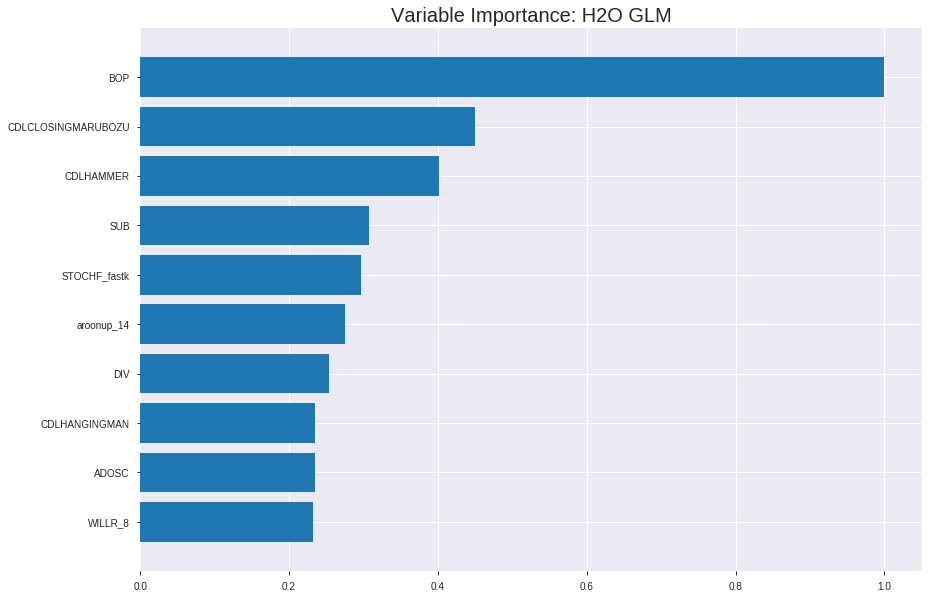

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_170144_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18268897041447424
RMSE: 0.4274213031827897
LogLoss: 0.5447157705082446
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2155.7139305761725
Residual deviance: 1695.155477821657
AIC: 1797.155477821657
AUC: 0.803512166083786
pr_auc: 0.8030044316975108
Gini: 0.6070243321675719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4374959652257395: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      468  287  0.3801   (287.0/755.0)
1      140  661  0.1748   (140.0/801.0)
Total  608  948  0.2744   (427.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437496     0.75586   230
max f2                       0.194803     0.85395   341
max f0point5                 0.578844     0.746998  165
max accuracy                 0.53906      0.733933  184
max precision                0.940733     1         0
max recall                   0.0451492    1         393
max specificity              0.940733     1         0
max absolute_mcc             0.53906      0.468444  184
max min_per_class_accuracy   0.526392     0.729089  189
max mean_per_class_accuracy  0.53906      0.734309  184

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.91254            1.94257   1.94257            1                0.92688   1                           0.92688             0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.897001           1.57834   1.76046            0.8125           0.904494  0.90625                     0.915687            0.0162297       0.0362047                  57.834    76.0456
    3        0.0302057                   0.878842           1.94257   1.81858            1                0.887899  0.93617                     0.906819            0.0187266       0.0549313                  94.2572   81.8578
    4        0.0404884                   0.864658           1.94257   1.85007            1                0.870611  0.952381                    0.897623            0.019975        0.0749064                  94.2572   85.0068
    5        0.0501285                   0.848594           1.81307   1.84295            0.933333         0.856485  0.948718                    0.889712            0.0174782       0.0923845                  81.3067   84.2953
    6        0.100257                    0.795531           1.66862   1.75579            0.858974         0.819659  0.903846                    0.854686            0.0836454       0.17603                    66.8619   75.5786
    7        0.150386                    0.763352           1.76824   1.75994            0.910256         0.779674  0.905983                    0.829682            0.0886392       0.264669                   76.8238   75.9937
    8        0.200514                    0.730765           1.61881   1.72466            0.833333         0.746941  0.887821                    0.808997            0.0811486       0.345818                   61.881    72.4655
    9        0.300129                    0.674186           1.35353   1.60148            0.696774         0.700691  0.824411                    0.773049            0.134831        0.480649                   35.3534   60.1478
    10       0.400386                    0.61833            1.27014   1.51851            0.653846         0.64648   0.781701                    0.741356            0.127341        0.60799                    27.0143   51.8511
    11       0.5                         0.530747           1.16554   1.44819            0.6              0.574842  0.745501                    0.708182            0.116105        0.724095                   16.5543   44.819
    12       0.600257                    0.443724           0.871667  1.3519             0.448718         0.48607   0.695931                    0.671084            0.0873908       0.811486                   -12.8333  35.1897
    13       0.699871                    0.371003           0.726898  1.26294            0.374194         0.410751  0.650138                    0.63403             0.0724095       0.883895                   -27.3102  26.2939
    14       0.800129                    0.299491           0.597714  1.17959            0.307692         0.335321  0.607229                    0.596602            0.0599251       0.94382                    -40.2286  17.9586
    15       0.899743                    0.198082           0.350916  1.08784            0.180645         0.250885  0.56                        0.558326            0.0349563       0.978777                   -64.9084  8.78402
    16       1                           0.0136775          0.211691  1                  0.108974         0.123999  0.514781                    0.514782          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19081699220132192
RMSE: 0.4368260434100993
LogLoss: 0.5610626550295734
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 618.886943697008
Residual deviance: 499.3457629763204
AIC: 601.3457629763204
AUC: 0.7805733517151894
pr_auc: 0.7182312459907144
Gini: 0.5611467034303788
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39614398765078224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  83   0.3517   (83.0/236.0)
1      43   166  0.2057   (43.0/209.0)
Total  196  249  0.2831   (126.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396144     0.724891  221
max f2                       0.151795     0.848435  336
max f0point5                 0.507269     0.712841  173
max accuracy                 0.470049     0.72809   190
max precision                0.930613     1         0
max recall                   0.0806171    1         373
max specificity              0.930613     1         0
max absolute_mcc             0.435635     0.455896  206
max min_per_class_accuracy   0.470049     0.722488  190
max mean_per_class_accuracy  0.435635     0.728114  206

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 45.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.893803           1.70335   1.70335            0.8              0.915317   0.8                         0.915317            0.0191388       0.0191388                  70.3349   70.3349
    2        0.0202247                   0.869796           2.12919   1.89261            1                0.876462   0.888889                    0.898048            0.0191388       0.0382775                  112.919   89.261
    3        0.0314607                   0.860411           1.70335   1.82502            0.8              0.865944   0.857143                    0.886582            0.0191388       0.0574163                  70.3349   82.5017
    4        0.0404494                   0.848021           1.59689   1.77432            0.75             0.854201   0.833333                    0.879386            0.0143541       0.0717703                  59.689    77.4322
    5        0.0516854                   0.841486           2.12919   1.85147            1                0.844112   0.869565                    0.871718            0.0239234       0.0956938                  112.919   85.1467
    6        0.101124                    0.782964           1.45172   1.65603            0.681818         0.811045   0.777778                    0.842055            0.0717703       0.167464                   45.1718   65.6034
    7        0.150562                    0.732276           1.5485    1.62072            0.727273         0.755165   0.761194                    0.813524            0.076555        0.244019                   54.8499   62.0724
    8        0.2                         0.684913           1.74206   1.65072            0.818182         0.710535   0.775281                    0.788066            0.0861244       0.330144                   74.2062   65.0718
    9        0.301124                    0.61563            1.41946   1.57306            0.666667         0.647691   0.738806                    0.740925            0.143541        0.473684                   41.9458   57.3056
    10       0.4                         0.538822           1.40333   1.5311             0.659091         0.579156   0.719101                    0.700937            0.138756        0.61244                    40.3328   53.11
    11       0.501124                    0.452121           1.27751   1.47993            0.6              0.493691   0.695067                    0.659116            0.129187        0.741627                   27.7512   47.9928
    12       0.6                         0.365539           0.77425   1.36364            0.363636         0.407032   0.640449                    0.617574            0.076555        0.818182                   -22.575   36.3636
    13       0.698876                    0.288282           0.629078  1.25971            0.295455         0.331108   0.59164                     0.577045            0.062201        0.880383                   -37.0922  25.9712
    14       0.8                         0.208101           0.709729  1.19019            0.333333         0.255923   0.558989                    0.536454            0.0717703       0.952153                   -29.0271  19.0191
    15       0.898876                    0.11229            0.338734  1.09653            0.159091         0.155173   0.515                       0.494513            0.0334928       0.985646                   -66.1266  9.65311
    16       1                           0.00955409         0.141946  1                  0.0666667        0.0632216  0.469663                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:01:44  0.000 sec   2            22        51            1.36126           1.36183
    2019-08-25 17:01:44  0.016 sec   4            14        51            1.34915           1.34741
    2019-08-25 17:01:44  0.029 sec   6            8.6       51            1.3326            1.32781
    2019-08-25 17:01:44  0.039 sec   8            5.4       51            1.31122           1.30284
    2019-08-25 17:01:44  0.052 sec   10           3.3       51            1.28523           1.27318
    2019-08-25 17:01:44  0.062 sec   12           2.1       51            1.25556           1.24058
    2019-08-25 17:01:44  0.076 sec   14           1.3       51            1.22394           1.20786
    2019-08-25 17:01:44  0.090 sec   16           0.8       51            1.19249           1.17802
    2019-08-25 17:01:44  0.107 sec   18           0.5       51            1.16347           1.15386
    2019-08-25 17:01:44  0.125 sec   20           0.31      51            1.13842           1.13683
    2019-08-25 17:01:44  0.148 sec   22           0.19      51            1.11795           1.12681
    2019-08-25 17:01:44  0.161 sec   24           0.12      51            1.10182           1.12251
    2019-08-25 17:01:44  0.171 sec   26           0.074     51            1.08943           1.12213
    2019-08-25 17:01:44  0.182 sec   28           0.046     51            1.08011           1.12404
    2019-08-25 17:01:44  0.193 sec   30           0.028     51            1.07326           1.12713
    2019-08-25 17:01:44  0.202 sec   32           0.018     51            1.0683            1.13054
    2019-08-25 17:01:44  0.216 sec   34           0.011     51            1.06471           1.13376
    2019-08-25 17:01:44  0.226 sec   36           0.0068    51            1.06201           1.13647

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7397260273972602)

('auc', 0.7920816326530612)

('logloss', 0.5610415716601912)

('mean_per_class_error', 0.2442448979591837)

('rmse', 0.43600211078366635)

('mse', 0.19009784060781246)

glm prediction progress: |████████████████████████████████████████████████| 100%


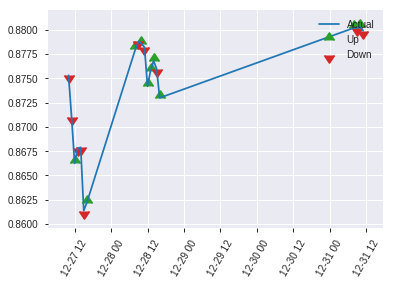


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19009784060781246
RMSE: 0.43600211078366635
LogLoss: 0.5610415716601912
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.9354893756444
Residual deviance: 250.22454096044524
AIC: 352.2245409604452
AUC: 0.7920816326530612
pr_auc: 0.7133917335943545
Gini: 0.5841632653061224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31824336593146113: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   40   0.32     (40.0/125.0)
1      17   81   0.1735   (17.0/98.0)
Total  102  121  0.2556   (57.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318243     0.739726  120
max f2                       0.0558683    0.820771  204
max f0point5                 0.367902     0.71161   108
max accuracy                 0.367902     0.753363  108
max precision                0.916275     1         0
max recall                   0.0558683    1         204
max specificity              0.916275     1         0
max absolute_mcc             0.367902     0.507875  108
max min_per_class_accuracy   0.381235     0.744     104
max mean_per_class_accuracy  0.367902     0.755755  108

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 37.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.860555           1.51701   1.51701            0.666667         0.88051    0.666667                    0.88051             0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.853427           2.27551   1.82041            1                0.854809   0.8                         0.87023             0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.836517           2.27551   1.95044            1                0.851678   0.857143                    0.864929            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.79874            2.27551   2.02268            1                0.826425   0.888889                    0.856373            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.791387           1.51701   1.89626            0.666667         0.793538   0.833333                    0.840664            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.729485           2.06865   1.9787             0.909091         0.755801   0.869565                    0.800077            0.102041        0.204082                   106.865   97.8705
    7        0.152466                    0.682267           1.44805   1.80702            0.636364         0.712908   0.794118                    0.771875            0.0714286       0.27551                    44.8052   80.7023
    8        0.201794                    0.614887           1.24119   1.66871            0.545455         0.647642   0.733333                    0.741507            0.0612245       0.336735                   24.1187   66.8707
    9        0.300448                    0.502608           1.55148   1.63022            0.681818         0.557224   0.716418                    0.680996            0.153061        0.489796                   55.1484   63.0216
    10       0.399103                    0.439248           1.65492   1.63632            0.727273         0.466295   0.719101                    0.627924            0.163265        0.653061                   65.4917   63.6322
    11       0.502242                    0.359691           1.18722   1.5441             0.521739         0.400061   0.678571                    0.581131            0.122449        0.77551                    18.7223   54.4096
    12       0.600897                    0.279951           0.827458  1.42644            0.363636         0.311247   0.626866                    0.536821            0.0816327       0.857143                   -17.2542  42.6439
    13       0.699552                    0.211015           0.413729  1.28362            0.181818         0.244325   0.564103                    0.495572            0.0408163       0.897959                   -58.6271  28.3621
    14       0.798206                    0.146427           0.517161  1.18889            0.227273         0.179837   0.522472                    0.456549            0.0510204       0.94898                    -48.2839  18.889
    15       0.896861                    0.0610134          0.310297  1.09224            0.136364         0.102336   0.48                        0.417585            0.0306122       0.979592                   -68.9703  9.22449
    16       1                           0.00728991         0.19787   1                  0.0869565        0.0406874  0.439462                    

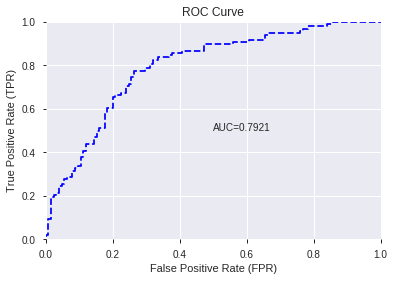

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


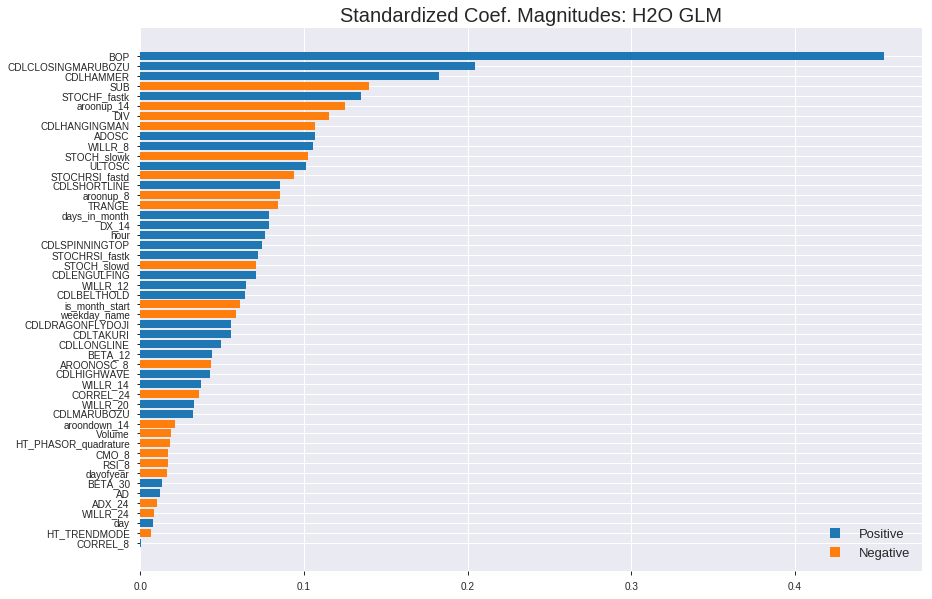

'log_likelihood'
--2019-08-25 17:01:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_170144_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_170144_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'SUB',
 'STOCHF_fastk',
 'aroonup_14',
 'DIV',
 'CDLHANGINGMAN',
 'ADOSC',
 'WILLR_8',
 'STOCH_slowk',
 'ULTOSC',
 'STOCHRSI_fastd',
 'CDLSHORTLINE',
 'aroonup_8',
 'TRANGE',
 'days_in_month',
 'DX_14',
 'hour',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'CDLENGULFING',
 'WILLR_12',
 'CDLBELTHOLD',
 'is_month_start',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLLONGLINE',
 'BETA_12',
 'AROONOSC_8',
 'CDLHIGHWAVE',
 'WILLR_14',
 'CORREL_24',
 'WILLR_20',
 'CDLMARUBOZU',
 'aroondown_14',
 'Volume',
 'HT_PHASOR_quadrature',
 'CMO_8',
 'RSI_8',
 'dayofyear',
 'BETA_30',
 'AD',
 'ADX_24',
 'WILLR_24',
 'day',
 'HT_TRENDMODE',
 'CORREL_8']

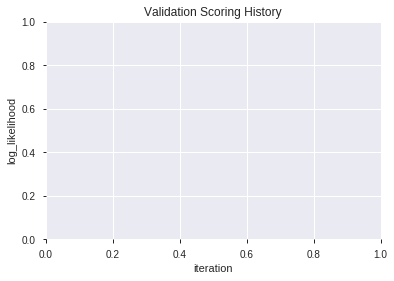

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_170157_model_1  0.781061  0.569150              0.288122  0.439862  0.193479
1  XGBoost_grid_1_AutoML_20190825_170157_model_5  0.778776  0.571444              0.305224  0.438685  0.192444
2  XGBoost_grid_1_AutoML_20190825_170157_model_2  0.778041  0.569791              0.283837  0.439984  0.193586
3               XGBoost_3_AutoML_20190825_170157  0.777551  0.566195              0.270041  0.438039  0.191878
4  XGBoost_grid_1_AutoML_20190825_170157_model_3  0.774367  0.571531              0.268245  0.439866  0.193482
5  XGBoost_grid_1_AutoML_20190825_170157_model_6  0.773633  0.572380              0.298612  0.442093  0.195446
6               XGBoost_2_AutoML_20190825_170157  0.770939  0.577932              0.285224  0.443263  0.196482
7               XGBoost_1_AutoML_20190825_170157  0.770367  0.581465              0.300122  0.444826  0.197870
8  XGBoost_grid_1_AutoML_20190825_170157_model_4  0.764898  0.578903              0.283837  0.444411  0.197501
9  XGBoost_grid_1_AutoML_20190825_170157_model_7  0.762449  0.585934              0.334612  0.446720  0.199559

variable  relative_importance  scaled_importance  percentage
0                    BOP          3179.066162           1.000000    0.352127
1                 TRANGE           528.541626           0.166257    0.058544
2                    DIV           439.977844           0.138398    0.048734
3         STOCHRSI_fastk           311.619354           0.098022    0.034516
4           STOCHF_fastk           290.177307           0.091278    0.032141
5     CDLCLOSINGMARUBOZU           283.216034           0.089088    0.031370
6              CDLHAMMER           259.214142           0.081538    0.028712
7              CORREL_24           244.708160           0.076975    0.027105
8                    SUB           242.681152           0.076337    0.026880
9                WILLR_8           242.164047           0.076175    0.026823
10               BETA_12           226.895660           0.071372    0.025132
11                ADX_24           211.416473           0.066503    0.023417
12                 ADOSC           185.962708           0.058496    0.020598
13           STOCH_slowk           167.468597           0.052679    0.018550
14                 DX_14           165.056656           0.051920    0.018282
15  HT_PHASOR_quadrature           162.576324           0.051140    0.018008
16                Volume           159.873184           0.050289    0.017708
17             dayofyear           145.619370           0.045806    0.016129
18              CORREL_8           127.739815           0.040182    0.014149
19            aroonup_14           121.841255           0.038326    0.013496
20                ULTOSC           116.098808           0.036520    0.012860
21              WILLR_24           113.192978           0.035606    0.012538
22        STOCHRSI_fastd           106.044716           0.033357    0.011746
23                    AD            98.756996           0.031065    0.010939
24                   day            88.157860           0.027731    0.009765
25               BETA_30            87.431541           0.027502    0.009684
26           STOCH_slowd            78.804718           0.024789    0.008729
27                  hour            76.682892           0.024121    0.008494
28             aroonup_8            76.309502           0.024004    0.008452
29                 CMO_8            65.984467           0.020756    0.007309
30            AROONOSC_8            64.341156           0.020239    0.007127
31              WILLR_20            59.608788           0.018750    0.006603
32              WILLR_12            50.772160           0.015971    0.005624
33          aroondown_14            44.909363           0.014127    0.004974
34         CDLHANGINGMAN            38.553131           0.012127    0.004270
35              WILLR_14            37.147064           0.011685    0.004115
36      CDLDRAGONFLYDOJI            34.840862           0.010959    0.003859
37                 RSI_8            32.234383           0.010140    0.003570
38         days_in_month            23.408440           0.007363    0.002593
39          weekday_name            10.942615           0.003442    0.001212
40           CDLBELTHOLD            10.255738           0.003226    0.001136
41          CDLSHORTLINE             9.541529           0.003001    0.001057
42           CDLLONGLINE             4.864745           0.001530    0.000539
43          HT_TRENDMODE             3.471046           0.001092    0.000384

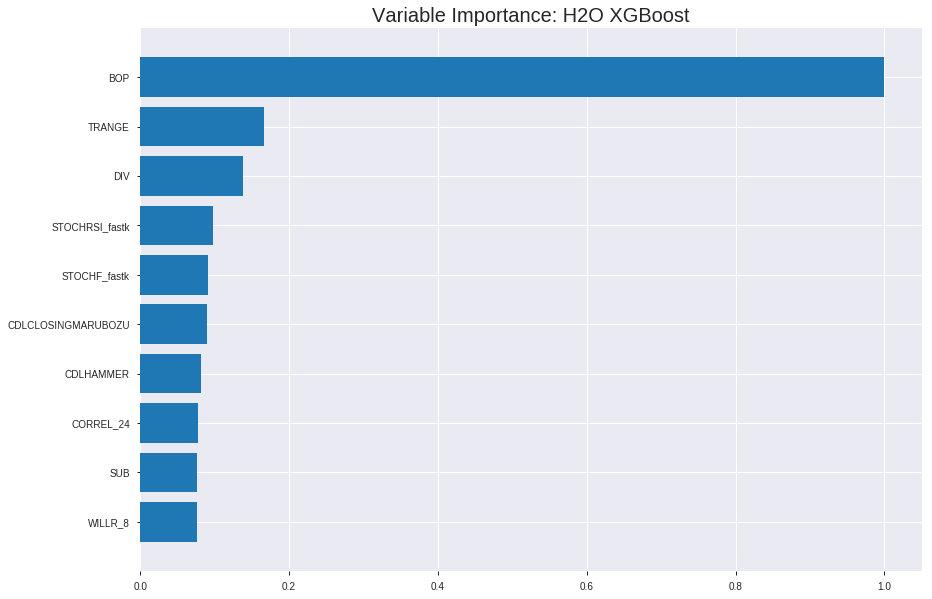

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_170157_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1266416277610197
RMSE: 0.35586743003683224
LogLoss: 0.41027620596501324
Mean Per-Class Error: 0.15950674239981477
AUC: 0.9226240378335028
pr_auc: 0.9267578707669873
Gini: 0.8452480756670055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4605250159899394: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      588  167  0.2212   (167.0/755.0)
1      82   719  0.1024   (82.0/801.0)
Total  670  886  0.16     (249.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460525     0.852401  224
max f2                       0.313704     0.904598  287
max f0point5                 0.605923     0.85595   158
max accuracy                 0.491164     0.84126   211
max precision                0.95178      1         0
max recall                   0.164999     1         347
max specificity              0.95178      1         0
max absolute_mcc             0.476016     0.683621  218
max min_per_class_accuracy   0.508777     0.838411  202
max mean_per_class_accuracy  0.491164     0.840493  211

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.933996           1.94257   1.94257            1                0.942317   1                           0.942317            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.924746           1.94257   1.94257            1                0.929622   1                           0.935969            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.915937           1.94257   1.94257            1                0.920749   1                           0.931112            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.90708            1.94257   1.94257            1                0.911315   1                           0.926084            0.019975        0.0786517                  94.2572   94.2572
    5        0.0501285                   0.895583           1.94257   1.94257            1                0.900365   1                           0.921138            0.0187266       0.0973783                  94.2572   94.2572
    6        0.100257                    0.858886           1.94257   1.94257            1                0.875789   1                           0.898463            0.0973783       0.194757                   94.2572   94.2572
    7        0.150386                    0.82456            1.94257   1.94257            1                0.841821   1                           0.879583            0.0973783       0.292135                   94.2572   94.2572
    8        0.200514                    0.784052           1.89276   1.93012            0.974359         0.8049     0.99359                     0.860912            0.0948814       0.387016                   89.2762   93.0119
    9        0.300129                    0.714729           1.67938   1.8469             0.864516         0.750399   0.950749                    0.824232            0.167291        0.554307                   67.9385   84.6899
    10       0.400386                    0.614204           1.45693   1.74925            0.75             0.666485   0.900482                    0.784732            0.146067        0.700375                   45.6929   74.925
    11       0.5                         0.517163           1.24074   1.64794            0.63871          0.565909   0.848329                    0.741136            0.123596        0.82397                    24.0739   64.794
    12       0.600257                    0.430417           0.971286  1.53492            0.5              0.475216   0.79015                     0.696721            0.0973783       0.921348                   -2.87141  53.4923
    13       0.699871                    0.342638           0.438645  1.37889            0.225806         0.382699   0.709826                    0.652026            0.0436954       0.965044                   -56.1355  37.8887
    14       0.800129                    0.24369            0.224143  1.2342             0.115385         0.293864   0.635341                    0.607148            0.0224719       0.987516                   -77.5857  23.4196
    15       0.899743                    0.138413           0.125327  1.11143            0.0645161        0.185301   0.572143                    0.560443            0.0124844       1                          -87.4673  11.1429
    16       1                           0.0446715          0         1                  0                0.0990733  0.514781                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1838375987616452
RMSE: 0.42876287008280606
LogLoss: 0.5428613717398879
Mean Per-Class Error: 0.2642324223501744
AUC: 0.7997830670667424
pr_auc: 0.7615704184358911
Gini: 0.5995661341334848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2923279106616974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  104  0.4407   (104.0/236.0)
1      27   182  0.1292   (27.0/209.0)
Total  159  286  0.2944   (131.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292328     0.735354  259
max f2                       0.128207     0.853355  336
max f0point5                 0.607233     0.719557  135
max accuracy                 0.440777     0.734831  199
max precision                0.944628     1         0
max recall                   0.0785272    1         373
max specificity              0.944628     1         0
max absolute_mcc             0.434192     0.470668  201
max min_per_class_accuracy   0.462621     0.724576  195
max mean_per_class_accuracy  0.434192     0.735768  201

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 45.23 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.928352           2.12919    2.12919            1                0.93566    1                           0.93566             0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.914561           1.59689    1.89261            0.75             0.91919    0.888889                    0.92834             0.0143541       0.0382775                  59.689    89.261
    3        0.0314607                   0.909917           2.12919    1.9771             1                0.913007   0.928571                    0.922864            0.0239234       0.062201                   112.919   97.7102
    4        0.0404494                   0.903674           2.12919    2.0109             1                0.906904   0.944444                    0.919317            0.0191388       0.0813397                  112.919   101.09
    5        0.0516854                   0.892663           2.12919    2.03661            1                0.895932   0.956522                    0.914234            0.0239234       0.105263                   112.919   103.661
    6        0.101124                    0.843809           1.74206    1.89261            0.818182         0.868874   0.888889                    0.892058            0.0861244       0.191388                   74.2062   89.261
    7        0.150562                    0.790449           1.5485     1.77962            0.727273         0.814319   0.835821                    0.866532            0.076555        0.267943                   54.8499   77.9619
    8        0.2                         0.750322           1.45172    1.69856            0.681818         0.766857   0.797753                    0.841893            0.0717703       0.339713                   45.1718   69.8565
    9        0.301124                    0.654982           1.51409    1.63661            0.711111         0.702715   0.768657                    0.795154            0.15311         0.492823                   51.4088   63.6614
    10       0.4                         0.548547           1.25816    1.54306            0.590909         0.599189   0.724719                    0.746713            0.124402        0.617225                   25.8156   54.3062
    11       0.501124                    0.434192           1.32483    1.49902            0.622222         0.491567   0.704036                    0.695226            0.133971        0.751196                   32.4827   49.9024
    12       0.6                         0.344577           0.725859   1.37161            0.340909         0.388273   0.644195                    0.644642            0.0717703       0.822967                   -27.4141  37.1611
    13       0.698876                    0.220416           0.725859   1.28025            0.340909         0.283381   0.601286                    0.593531            0.0717703       0.894737                   -27.4141  28.025
    14       0.8                         0.149452           0.709729   1.20813            0.333333         0.187214   0.567416                    0.542171            0.0717703       0.966507                   -29.0271  20.8134
    15       0.898876                    0.0882312          0.290344   1.10718            0.136364         0.115914   0.52                        0.495283            0.0287081       0.995215                   -70.9656  10.7177
    16       1                           0.04129            0.0473153  1                  0.0222222        0.0703042  0.469663     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:02:02  0.017 sec   0                  0.5              0.693147            0.5             0                  1                0.485219                         0.5                0.693147              0.5               0                    1                  0.530337
    2019-08-25 17:02:02  0.079 sec   5                  0.466458         0.627756            0.844969        0.841512           1.94257          0.261568                         0.470491           0.635292              0.785966          0.738507             1.70335            0.301124
    2019-08-25 17:02:02  0.119 sec   10                 0.442667         0.582239            0.858174        0.852033           1.94257          0.217866                         0.452484           0.599816              0.791755          0.756562             1.70335            0.31236
    2019-08-25 17:02:02  0.164 sec   15                 0.424536         0.547332            0.869799        0.873658           1.94257          0.217224                         0.442313           0.578632              0.793316          0.760994             2.12919            0.296629
    2019-08-25 17:02:02  0.210 sec   20                 0.411486         0.52139             0.875737        0.879252           1.94257          0.208226                         0.436125           0.564561              0.791957          0.754305             1.70335            0.319101
    2019-08-25 17:02:02  0.254 sec   25                 0.402224         0.502375            0.87986         0.885109           1.94257          0.205656                         0.433039           0.5566                0.793518          0.761205             2.12919            0.323596
    2019-08-25 17:02:02  0.297 sec   30                 0.39382          0.485184            0.88686         0.892106           1.94257          0.208226                         0.430554           0.550532              0.796489          0.764335             2.12919            0.283146
    2019-08-25 17:02:02  0.341 sec   35                 0.386467         0.470239            0.893131        0.899482           1.94257          0.188946                         0.429227           0.54658               0.798891          0.763579             2.12919            0.28764
    2019-08-25 17:02:02  0.384 sec   40                 0.379789         0.456827            0.899326        0.904411           1.94257          0.181234                         0.428967           0.544967              0.797948          0.761428             2.12919            0.283146
    2019-08-25 17:02:02  0.429 sec   45                 0.374066         0.445269            0.90471         0.911117           1.94257          0.179306                         0.427941           0.541662              0.800726          0.763403             2.12919            0.289888
    2019-08-25 17:02:02  0.475 sec   50                 0.368832         0.434882            0.90979         0.915933           1.94257          0.16838                          0.427678           0.540909              0.801131          0.763847             2.12919            0.285393
    2019-08-25 17:02:02  0.525 sec   55                 0.364654         0.426631            0.913654        0.91964            1.94257          0.16838                          0.427551           0.540463              0.801577          0.7

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             3179.066162109375      1.0                    0.35212736137979705
TRANGE          528.5416259765625      0.16625688143145292    0.058543596969691296
DIV             439.97784423828125     0.1383984547041786     0.04873388267402377
STOCHRSI_fastk  311.6193542480469      0.09802229282365142    0.034516331328390194
STOCHF_fastk    290.17730712890625     0.0912775300456055     0.03214131580822421
---             ---                    ---                    ---
weekday_name    10.942614555358887     0.003442084561114714   0.001212052154151461
CDLBELTHOLD     10.255738258361816     0.003226022276792417   0.001135970712079359
CDLSHORTLINE    9.541528701782227      0.003001362102967756   0.0010568617178633546
CDLLONGLINE     4.864745140075684      0.0015302434400571979  0.0005388405848160847
HT_TRENDMODE    3.4710464477539062     0.0010918446709680292  0.0003844683830245648


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7160493827160493)

('auc', 0.7810612244897959)

('logloss', 0.5691500644166712)

('mean_per_class_error', 0.27114285714285713)

('rmse', 0.43986231538396986)

('mse', 0.19347885649494698)

xgboost prediction progress: |████████████████████████████████████████████| 100%


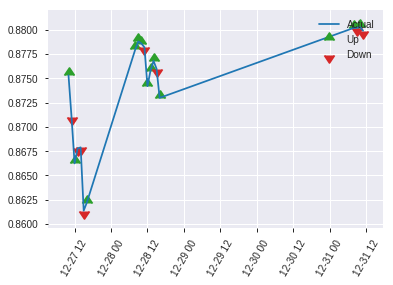


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19347885649494698
RMSE: 0.43986231538396986
LogLoss: 0.5691500644166712
Mean Per-Class Error: 0.27114285714285713
AUC: 0.7810612244897959
pr_auc: 0.6947056337984967
Gini: 0.5621224489795917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22384954988956451: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   58   0.464    (58.0/125.0)
1      11   87   0.1122   (11.0/98.0)
Total  78   145  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.22385      0.716049  144
max f2                       0.10245      0.837607  192
max f0point5                 0.524607     0.692488  81
max accuracy                 0.524607     0.721973  81
max precision                0.932368     1         0
max recall                   0.10245      1         192
max specificity              0.932368     1         0
max absolute_mcc             0.400259     0.455121  117
max min_per_class_accuracy   0.437038     0.688     106
max mean_per_class_accuracy  0.400259     0.728857  117

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 42.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.923101           1.51701   1.51701            0.666667         0.928903  0.666667                    0.928903            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.915315           2.27551   1.82041            1                0.918285  0.8                         0.924656            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.904248           1.13776   1.62536            0.5              0.911615  0.714286                    0.92093             0.0102041       0.0510204                  13.7755   62.5364
    4        0.0403587                   0.898723           2.27551   1.76984            1                0.900381  0.777778                    0.916364            0.0204082       0.0714286                  127.551   76.9841
    5        0.0538117                   0.882279           2.27551   1.89626            1                0.890989  0.833333                    0.91002             0.0306122       0.102041                   127.551   89.6259
    6        0.103139                    0.825739           2.06865   1.9787             0.909091         0.847481  0.869565                    0.88011             0.102041        0.204082                   106.865   97.8705
    7        0.152466                    0.792283           1.65492   1.87395            0.727273         0.806714  0.823529                    0.856364            0.0816327       0.285714                   65.4917   87.395
    8        0.201794                    0.739189           1.03432   1.66871            0.454545         0.760995  0.733333                    0.833052            0.0510204       0.336735                   3.43228   66.8707
    9        0.300448                    0.5853             1.55148   1.63022            0.681818         0.667342  0.716418                    0.77864             0.153061        0.489796                   55.1484   63.0216
    10       0.399103                    0.494224           1.34462   1.55962            0.590909         0.539173  0.685393                    0.719446            0.132653        0.622449                   34.462    55.9619
    11       0.502242                    0.419502           1.08829   1.46283            0.478261         0.452509  0.642857                    0.664628            0.112245        0.734694                   8.82875   46.2828
    12       0.600897                    0.292449           0.930891  1.37549            0.409091         0.369216  0.604478                    0.616128            0.0918367       0.826531                   -6.91095  37.5495
    13       0.699552                    0.185732           0.827458  1.29821            0.363636         0.229226  0.570513                    0.561565            0.0816327       0.908163                   -17.2542  29.8208
    14       0.798206                    0.125152           0.413729  1.18889            0.181818         0.147479  0.522472                    0.510385            0.0408163       0.94898                    -58.6271  18.889
    15       0.896861                    0.0905403          0.517161  1.115              0.227273         0.109581  0.49                        0.466297            0.0510204       1                          -48.2839  11.5
    16       1                           0.056604           0         1                  0                0.077869  0.439462                    0.426235            0 

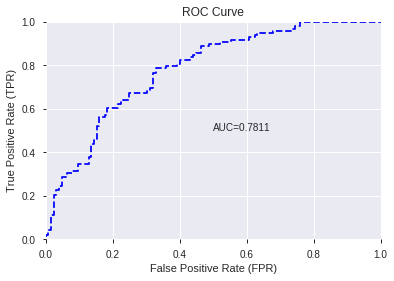

This function is available for GLM models only


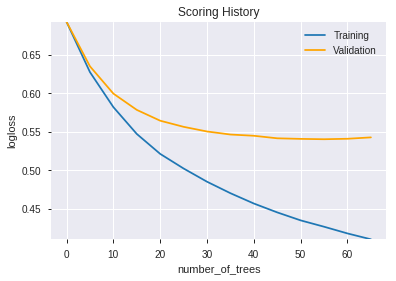

--2019-08-25 17:02:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_170157_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_170157_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CORREL_24',
 'SUB',
 'WILLR_8',
 'BETA_12',
 'ADX_24',
 'ADOSC',
 'STOCH_slowk',
 'DX_14',
 'HT_PHASOR_quadrature',
 'Volume',
 'dayofyear',
 'CORREL_8',
 'aroonup_14',
 'ULTOSC',
 'WILLR_24',
 'STOCHRSI_fastd',
 'AD',
 'day',
 'BETA_30',
 'STOCH_slowd',
 'hour',
 'aroonup_8',
 'CMO_8',
 'AROONOSC_8',
 'WILLR_20',
 'WILLR_12',
 'aroondown_14',
 'CDLHANGINGMAN',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'RSI_8',
 'days_in_month',
 'weekday_name',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 894 994 998] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


58

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_170227_model_1  0.789551  0.958686              0.280122  0.469549  0.220476
1  DeepLearning_grid_1_AutoML_20190825_170227_model_9  0.782041  0.581918              0.249224  0.445553  0.198518
2  DeepLearning_grid_1_AutoML_20190825_170227_model_3  0.778122  0.832400              0.262735  0.473171  0.223891
3  DeepLearning_grid_1_AutoML_20190825_170227_model_7  0.775592  0.760156              0.277224  0.466370  0.217501
4  DeepLearning_grid_1_AutoML_20190825_170227_model_6  0.770449  0.622739              0.278735  0.451040  0.203437
5  DeepLearning_grid_1_AutoML_20190825_170227_model_5  0.766122  0.636870              0.277633  0.449426  0.201984
6  DeepLearning_grid_1_AutoML_20190825_170227_model_8  0.759510  0.617647              0.274735  0.451622  0.203962
7               DeepLearning_1_AutoML_20190825_170227  0.756245  0.642990              0.325224  0.463273  0.214622
8  DeepLearning_grid_1_AutoML_20190825_170227_model_2  0.750857  0.760896              0.297633  0.479508  0.229928
9  DeepLearning_grid_1_AutoML_20190825_170227_model_4  0.741061  0.808212              0.344122  0.488750  0.238877

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI             1.000000           1.000000    0.023217
1            CDLTAKURI             0.992246           0.992246    0.023037
2        CDLHANGINGMAN             0.965126           0.965126    0.022408
3       CDLSPINNINGTOP             0.923292           0.923292    0.021436
4               Volume             0.893478           0.893478    0.020744
5                  BOP             0.892220           0.892220    0.020715
6               TRANGE             0.865176           0.865176    0.020087
7       STOCHRSI_fastk             0.864625           0.864625    0.020074
8            CDLHAMMER             0.858633           0.858633    0.019935
9   CDLCLOSINGMARUBOZU             0.818669           0.818669    0.019007
10        STOCHF_fastk             0.811190           0.811190    0.018834
11         CDLMARUBOZU             0.802575           0.802575    0.018634
12                 DIV             0.793671           0.793671    0.018427
13      STOCHRSI_fastd             0.792820           0.792820    0.018407
14                 SUB             0.789023           0.789023    0.018319
15         CDLLONGLINE             0.787928           0.787928    0.018294
16               ADOSC             0.765638           0.765638    0.017776
17               CCI_8             0.750316           0.750316    0.017420
18         CDLBELTHOLD             0.746766           0.746766    0.017338
19              ULTOSC             0.743073           0.743073    0.017252
20        CDLSHORTLINE             0.742783           0.742783    0.017245
21            WILLR_12             0.742661           0.742661    0.017243
22          MINUS_DI_8             0.742404           0.742404    0.017237
23             WILLR_8             0.733260           0.733260    0.017024
24         STOCH_slowk             0.733140           0.733140    0.017021
25        STOCHF_fastd             0.732280           0.732280    0.017002
26              MOM_12             0.719395           0.719395    0.016702
27             ROCR_12             0.718895           0.718895    0.016691
28          MINUS_DM_8             0.714805           0.714805    0.016596
29        CDLENGULFING             0.714553           0.714553    0.016590
30               ROC_8             0.714254           0.714254    0.016583
31               MOM_8             0.711559           0.711559    0.016520
32              RSI_24             0.708037           0.708037    0.016439
33              CCI_20             0.700784           0.700784    0.016270
34              CMO_30             0.694352           0.694352    0.016121
35            WILLR_30             0.691976           0.691976    0.016066
36              CCI_12             0.688889           0.688889    0.015994
37              ROC_12             0.688314           0.688314    0.015981
38           ROCR100_8             0.688034           0.688034    0.015974
39              CCI_14             0.685888           0.685888    0.015924
40              ROCR_8             0.684132           0.684132    0.015884
41            WILLR_14             0.684004           0.684004    0.015881
42              CMO_24             0.681105           0.681105    0.015813
43              RSI_12             0.680774           0.680774    0.015806
44            WILLR_20             0.678018           0.678018    0.015742
45              RSI_30             0.673546           0.673546    0.015638
46              ROCP_8             0.668667           0.668667    0.015525
47              CMO_20             0.667949           0.667949    0.015508
48              RSI_14             0.667359           0.667359    0.015494
49             ROCP_12             0.663991           0.663991    0.015416
50              RSI_20             0.661578           0.661578    0.015360
51            WILLR_24             0.656211           0.656211    0.015235
52              CMO_12             0.65

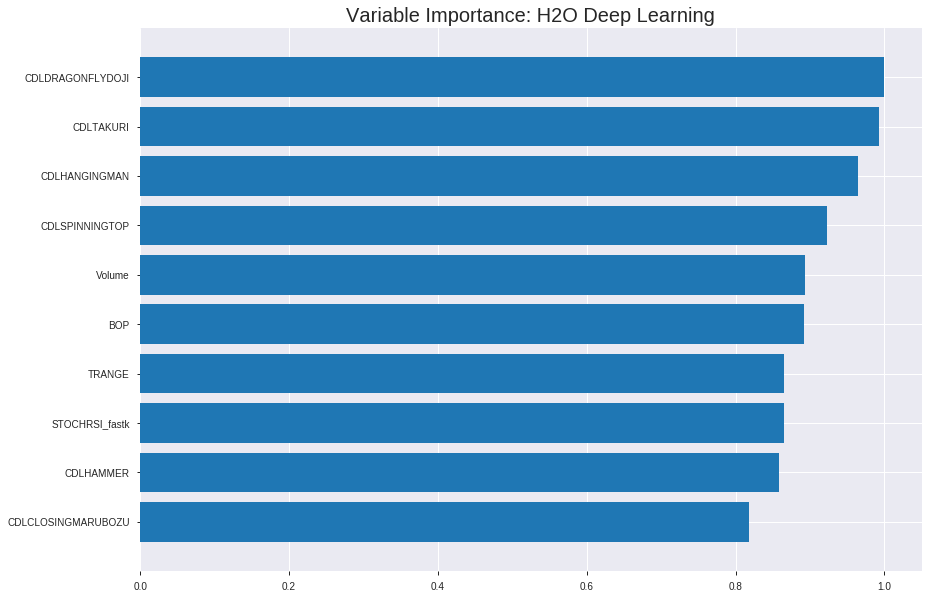

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_170227_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15382129275534
RMSE: 0.3922005771991418
LogLoss: 0.5487837400280531
Mean Per-Class Error: 0.20999909054079757
AUC: 0.8678853419979992
pr_auc: 0.7213159259385202
Gini: 0.7357706839959983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3984822556609189: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      508  247  0.3272   (247.0/755.0)
1      93   708  0.1161   (93.0/801.0)
Total  601  955  0.2185   (340.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398482     0.806378  237
max f2                       0.0811637    0.870837  351
max f0point5                 0.80532      0.815437  92
max accuracy                 0.582971     0.790488  174
max precision                0.998886     0.971264  2
max recall                   0.000100927  1         399
max specificity              0.999941     0.993377  0
max absolute_mcc             0.574843     0.580492  177
max min_per_class_accuracy   0.607566     0.782781  165
max mean_per_class_accuracy  0.582971     0.790001  174

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 55.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   1                  1.94257    1.94257            1                1           1                           1                   0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.999999           1.94257    1.94257            1                1           1                           1                   0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.999998           1.81307    1.90124            0.933333         0.999998    0.978723                    0.999999            0.0174782       0.0574282                  81.3067   90.124
    4        0.0404884                   0.999994           1.82116    1.8809             0.9375           0.999996    0.968254                    0.999999            0.0187266       0.0761548                  82.1161   88.0903
    5        0.0501285                   0.999978           1.81307    1.86786            0.933333         0.999989    0.961538                    0.999997            0.0174782       0.093633                   81.3067   86.7857
    6        0.100257                    0.999019           1.89276    1.88031            0.974359         0.999668    0.967949                    0.999832            0.0948814       0.188514                   89.2762   88.031
    7        0.150386                    0.993875           1.74333    1.83465            0.897436         0.99716     0.944444                    0.998942            0.0873908       0.275905                   74.3334   83.4651
    8        0.200514                    0.980406           1.64371    1.78692            0.846154         0.988595    0.919872                    0.996355            0.082397        0.358302                   64.3715   78.6917
    9        0.300129                    0.917389           1.66685    1.74707            0.858065         0.951616    0.899358                    0.981506            0.166042        0.524345                   66.6852   74.7067
    10       0.400386                    0.788445           1.44448    1.6713             0.74359          0.854637    0.860353                    0.949738            0.144819        0.669164                   44.4476   67.1298
    11       0.5                         0.628741           1.10288    1.55805            0.567742         0.716677    0.802057                    0.903305            0.109863        0.779026                   10.2879   55.8052
    12       0.600257                    0.430213           0.921476   1.45173            0.474359         0.528926    0.747323                    0.840775            0.0923845       0.871411                   -7.85236  45.1729
    13       0.699871                    0.238332           0.576505   1.32716            0.296774         0.331249    0.683196                    0.768253            0.0574282       0.928839                   -42.3495  32.7156
    14       0.800129                    0.0792417          0.373571   1.20767            0.192308         0.15258     0.621687                    0.691108            0.0374532       0.966292                   -62.6429  20.7671
    15       0.899743                    0.00971494         0.238122   1.10033            0.122581         0.0384235   0.566429                    0.618847            0.0237203       0.990012                   -76.1878  10.0328
    16       1                           2.71597e-07        0.0996191  1                  0.0512821        0.002



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22132577254953406
RMSE: 0.4704527314720726
LogLoss: 0.9455617796847736
Mean Per-Class Error: 0.2776944286756954
AUC: 0.7821648690292758
pr_auc: 0.6815275323174634
Gini: 0.5643297380585517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12757522371813335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  116  0.4915   (116.0/236.0)
1      22   187  0.1053   (22.0/209.0)
Total  142  303  0.3101   (138.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.127575     0.730469  276
max f2                       0.0487921    0.850254  319
max f0point5                 0.520232     0.700667  183
max accuracy                 0.520232     0.719101  183
max precision                0.999973     0.965517  5
max recall                   1.21746e-05  1         396
max specificity              0.999999     0.995763  0
max absolute_mcc             0.395341     0.445171  213
max min_per_class_accuracy   0.49498      0.716102  190
max mean_per_class_accuracy  0.395341     0.722306  213

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 49.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    1                  1.70335   1.70335            0.8              1            0.8                         1                   0.0191388       0.0191388                  70.3349   70.3349
    2        0.0202247                   1                  2.12919   1.89261            1                1            0.888889                    1                   0.0191388       0.0382775                  112.919   89.261
    3        0.0314607                   0.999998           2.12919   1.9771             1                0.999999     0.928571                    1                   0.0239234       0.062201                   112.919   97.7102
    4        0.0404494                   0.999995           2.12919   2.0109             1                0.999997     0.944444                    0.999999            0.0191388       0.0813397                  112.919   101.09
    5        0.0516854                   0.999986           2.12919   2.03661            1                0.999991     0.956522                    0.999997            0.0239234       0.105263                   112.919   103.661
    6        0.101124                    0.999652           1.35494   1.70335            0.636364         0.999892     0.8                         0.999946            0.0669856       0.172249                   35.4937   70.3349
    7        0.150562                    0.997254           1.83884   1.74784            0.863636         0.99874      0.820896                    0.99955             0.0909091       0.263158                   83.8843   74.784
    8        0.2                         0.983185           1.45172   1.67464            0.681818         0.992612     0.786517                    0.997835            0.0717703       0.334928                   45.1718   67.4641
    9        0.301124                    0.882429           1.2302    1.52539            0.577778         0.938423     0.716418                    0.977883            0.124402        0.45933                    23.0197   52.5387
    10       0.4                         0.720088           1.50011   1.51914            0.704545         0.801651     0.713483                    0.93432             0.148325        0.607656                   50.0109   51.9139
    11       0.501124                    0.464287           1.18288   1.45128            0.555556         0.575439     0.681614                    0.8619              0.119617        0.727273                   18.2881   45.1284
    12       0.6                         0.272009           0.871031  1.35566            0.409091         0.365689     0.636704                    0.780128            0.0861244       0.813397                   -12.8969  35.5662
    13       0.698876                    0.109905           0.82264   1.28025            0.386364         0.181059     0.601286                    0.695372            0.0813397       0.894737                   -17.736   28.025
    14       0.8                         0.0309681          0.662414  1.20215            0.311111         0.0684415    0.564607                    0.616125            0.0669856       0.961722                   -33.7586  20.2153
    15       0.898876                    0.000972455        0.241953  1.09653            0.113636         0.00946331   0.515                       0.549392            0.0239234       0.985646                   -75.8047  9.65311
    16       1                           5.14601e-07        0.141946  1                  0.0666667        0.000221


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:02:28  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:02:35  6.517 sec   2336 obs/sec      9.61311   1             14958      0.455177         0.771821            0.170532       0.795685        0.669605           1.82116          0.283419                         0.499752           1.08948               -0.00270059      0.75003           0.665981             1.70335            0.332584
    2019-08-25 17:02:41  12.809 sec  2373 obs/sec      19.2474   2             29949      0.466167         0.729657            0.129994       0.782261        0.686277           1.94257          0.316838                         0.530611           1.29753               -0.130355        0.703714          0.594468             2.12919            0.388764
    2019-08-25 17:02:47  18.706 sec  2437 obs/sec      28.8817   3             44940      0.425643         0.63676             0.274679       0.832657        0.743289           1.94257          0.23329                          0.489158           1.02432               0.0393631        0.756538          0.670399             2.12919            0.310112
    2019-08-25 17:02:52  24.361 sec  2495 obs/sec      38.5167   4             59932      0.404419         0.573787            0.345209       0.84537         0.712961           1.94257          0.24036                          0.475458           0.954667              0.0924189        0.76481           0.685566             1.70335            0.352809
    2019-08-25 17:02:58  29.926 sec  2539 obs/sec      48.1568   5             74932      0.451689         0.705385            0.183195       0.816169        0.734979           1.94257          0.297558                         0.505451           1.08313               -0.0256978       0.746999          0.643285             1.70335            0.334831
    2019-08-25 17:03:03  35.440 sec  2573 obs/sec      57.777    6             89901      0.446403         0.671116            0.202199       0.816718        0.680405           1.94257          0.286632                         0.539892           1.36843               -0.170242        0.713719          0.606107             2.12919            0.388764
    2019-08-25 17:03:09  40.914 sec  2600 obs/sec      67.4158   7             104899     0.391758         0.539141            0.385566       0.863283        0.743606           1.94257          0.215938                         0.480582           0.982051              0.07275          0.76701           0.681012             2.12919            0.323596
    2019-08-25 17:03:14  46.256 sec  2627 obs/sec      77.0122   8             119831     0.392201         0.548784            0.384177       0.867885        0.721316           1.94257          0.218509                         0.470453           0.945562              0.111426         0.782165          0.681528             1.70335            0.310112

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLDRAGONFLYDOJI  1.0                    1.0                  0.023217237573799215
CDLTAKURI         0.9922458529472351     0.9922458529472351   0.023037207699493
CDLHANGINGMAN     0.9651260375976562     0.9651260375976562   0.02240756050356426
CDLSPINNINGTOP    0.923292338848114      0.923292338848114    0.02143629758110539
Volume            0.8934783339500427     0.8934783339500427   0.020744098746360455
---               ---                    ---                  ---
CMO_14            0.6549713611602783     0.6549713611602783   0.01520662569609283
CCI_24            0.6532245874404907     0.6532245874404907   0.015166070435652853
CMO_8             0.6476808786392212     0.6476808786392212   0.015037360831373817
RSI_8             0.6370936632156372     0.6370936632156372   0.014791554935639476
ROCR100_12        0.6327478885650635     0.6327478885650635   0.01469065805313491


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7219917012448132)

('auc', 0.7895510204081633)

('logloss', 0.9586857254970925)

('mean_per_class_error', 0.2801224489795918)

('rmse', 0.46954854414340097)

('mse', 0.22047583530718737)

deeplearning prediction progress: |███████████████████████████████████████| 100%


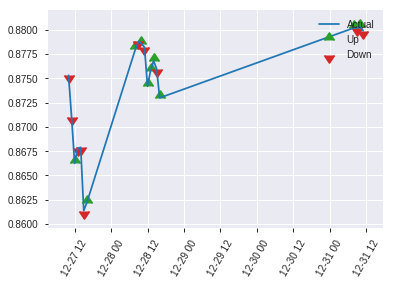


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22047583530718737
RMSE: 0.46954854414340097
LogLoss: 0.9586857254970925
Mean Per-Class Error: 0.2801224489795918
AUC: 0.7895510204081633
pr_auc: 0.7242153298946268
Gini: 0.5791020408163265
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1551773618056941: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   56   0.448    (56.0/125.0)
1      11   87   0.1122   (11.0/98.0)
Total  80   143  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.155177     0.721992  142
max f2                       0.0423785    0.828829  162
max f0point5                 0.922645     0.724852  59
max accuracy                 0.922645     0.730942  59
max precision                1            1         0
max recall                   5.1464e-05   1         204
max specificity              1            1         0
max absolute_mcc             0.922645     0.461101  59
max min_per_class_accuracy   0.429249     0.696     106
max mean_per_class_accuracy  0.155177     0.719878  142

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 46.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.999999           2.27551   2.27551            1                1            1                           1                   0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.999998           2.27551   2.27551            1                0.999999     1                           0.999999            0.0204082       0.0510204                  127.551   127.551
    3        0.0313901                   0.999997           2.27551   2.27551            1                0.999998     1                           0.999999            0.0204082       0.0714286                  127.551   127.551
    4        0.0403587                   0.999996           2.27551   2.27551            1                0.999996     1                           0.999998            0.0204082       0.0918367                  127.551   127.551
    5        0.0538117                   0.99999            0.758503  1.89626            0.333333         0.999995     0.833333                    0.999997            0.0102041       0.102041                   -24.1497  89.6259
    6        0.103139                    0.999514           1.65492   1.78083            0.727273         0.999797     0.782609                    0.999901            0.0816327       0.183673                   65.4917   78.0834
    7        0.152466                    0.995782           1.86178   1.80702            0.818182         0.998487     0.794118                    0.999444            0.0918367       0.27551                    86.1781   80.7023
    8        0.201794                    0.978583           2.06865   1.87098            0.909091         0.987865     0.822222                    0.996613            0.102041        0.377551                   106.865   87.0975
    9        0.300448                    0.842464           1.55148   1.76607            0.681818         0.929846     0.776119                    0.97469             0.153061        0.530612                   55.1484   76.6068
    10       0.399103                    0.634087           0.930891  1.55962            0.409091         0.740884     0.685393                    0.916895            0.0918367       0.622449                   -6.91095  55.9619
    11       0.502242                    0.342853           0.890417  1.42219            0.391304         0.516568     0.625                       0.834685            0.0918367       0.714286                   -10.9583  42.2194
    12       0.600897                    0.185835           1.13776   1.37549            0.5              0.265561     0.604478                    0.741247            0.112245        0.826531                   13.7755   37.5495
    13       0.699552                    0.0662166          0.827458  1.29821            0.363636         0.126351     0.570513                    0.654531            0.0816327       0.908163                   -17.2542  29.8208
    14       0.798206                    0.00764483         0.413729  1.18889            0.181818         0.0321774    0.522472                    0.577611            0.0408163       0.94898                    -58.6271  18.889
    15       0.896861                    0.000216028        0.310297  1.09224            0.136364         0.00218068   0.48                        0.514313            0.0306122       0.979592                   -68.9703  9.22449
    16       1                           3.08931e-08        0.19787   1                  0.0869565        2.693

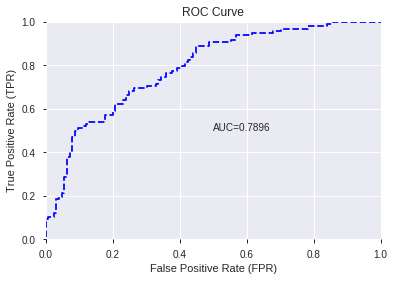

This function is available for GLM models only


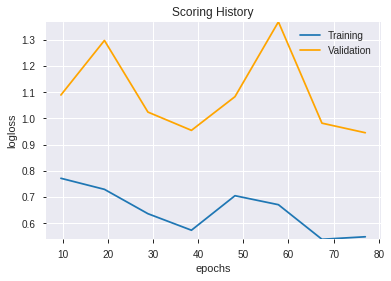

--2019-08-25 17:10:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_170227_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_170227_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLSPINNINGTOP',
 'Volume',
 'BOP',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'DIV',
 'STOCHRSI_fastd',
 'SUB',
 'CDLLONGLINE',
 'ADOSC',
 'CCI_8',
 'CDLBELTHOLD',
 'ULTOSC',
 'CDLSHORTLINE',
 'WILLR_12',
 'MINUS_DI_8',
 'WILLR_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MOM_12',
 'ROCR_12',
 'MINUS_DM_8',
 'CDLENGULFING',
 'ROC_8',
 'MOM_8',
 'RSI_24',
 'CCI_20',
 'CMO_30',
 'WILLR_30',
 'CCI_12',
 'ROC_12',
 'ROCR100_8',
 'CCI_14',
 'ROCR_8',
 'WILLR_14',
 'CMO_24',
 'RSI_12',
 'WILLR_20',
 'RSI_30',
 'ROCP_8',
 'CMO_20',
 'RSI_14',
 'ROCP_12',
 'RSI_20',
 'WILLR_24',
 'CMO_12',
 'CMO_14',
 'CCI_24',
 'CMO_8',
 'RSI_8',
 'ROCR100_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_171044_model_1  0.786286  0.562137              0.242327  0.435898  0.190007

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.447569           1.000000    0.121529
1   CDLCLOSINGMARUBOZU             0.201209           0.449559    0.054635
2            CDLHAMMER             0.179226           0.400443    0.048666
3         STOCHF_fastk             0.165871           0.370604    0.045039
4                  SUB             0.151109           0.337622    0.041031
5                  DIV             0.131743           0.294353    0.035773
6                ADOSC             0.127709           0.285340    0.034677
7              WILLR_8             0.113264           0.253065    0.030755
8               TRANGE             0.109592           0.244861    0.029758
9        CDLHANGINGMAN             0.109110           0.243784    0.029627
10              ULTOSC             0.106894           0.238833    0.029025
11      STOCHRSI_fastk             0.103028           0.230194    0.027975
12      CDLSPINNINGTOP             0.102625           0.229295    0.027866
13              CCI_24             0.094172           0.210409    0.025571
14        STOCHF_fastd             0.085800           0.191703    0.023298
15         STOCH_slowk             0.085733           0.191552    0.023279
16        CDLSHORTLINE             0.085167           0.190288    0.023126
17            WILLR_12             0.077436           0.173015    0.021026
18              CCI_20             0.076024           0.169860    0.020643
19      STOCHRSI_fastd             0.071115           0.158892    0.019310
20         CDLBELTHOLD             0.070253           0.156966    0.019076
21              CCI_14             0.066832           0.149323    0.018147
22        CDLENGULFING             0.061539           0.137497    0.016710
23            WILLR_20             0.058096           0.129802    0.015775
24          MINUS_DM_8             0.056065           0.125265    0.015223
25    CDLDRAGONFLYDOJI             0.053396           0.119302    0.014499
26           CDLTAKURI             0.053311           0.119112    0.014476
27               CCI_8             0.053123           0.118693    0.014425
28            WILLR_14             0.050851           0.113616    0.013808
29         CDLLONGLINE             0.045968           0.102705    0.012482
30              Volume             0.042833           0.095702    0.011631
31               CMO_8             0.039685           0.088669    0.010776
32               RSI_8             0.039490           0.088233    0.010723
33         CDLMARUBOZU             0.038239           0.085438    0.010383
34              CCI_12             0.031872           0.071211    0.008654
35            WILLR_24             0.027733           0.061964    0.007530
36          ROCR100_12             0.021376           0.047761    0.005804
37             ROCR_12             0.021311           0.047615    0.005787
38             ROCP_12             0.021226           0.047426    0.005764
39              ROC_12             0.021153           0.047261    0.005744
40          MINUS_DI_8             0.020112           0.044937    0.005461
41              RSI_30             0.016983           0.037944    0.004611
42              MOM_12             0.016900           0.037760    0.004589
43              CMO_30             0.016830           0.037604    0.004570
44              CMO_24             0.013744           0.030709    0.003732
45              RSI_24             0.013709           0.030629    0.003722
46            WILLR_30             0.013310           0.029738    0.003614
47              CMO_12             0.012892           0.028804    0.003501
48              RSI_12             0.012385           0.027673    0.003363
49              CMO_20             0.009935           0.022198    0.002698
50              RSI_20             0.009466           0.021151    0.002570
51           ROCR100_8             0.004741           0.010592    0.001287
52              ROCR_8             0.00

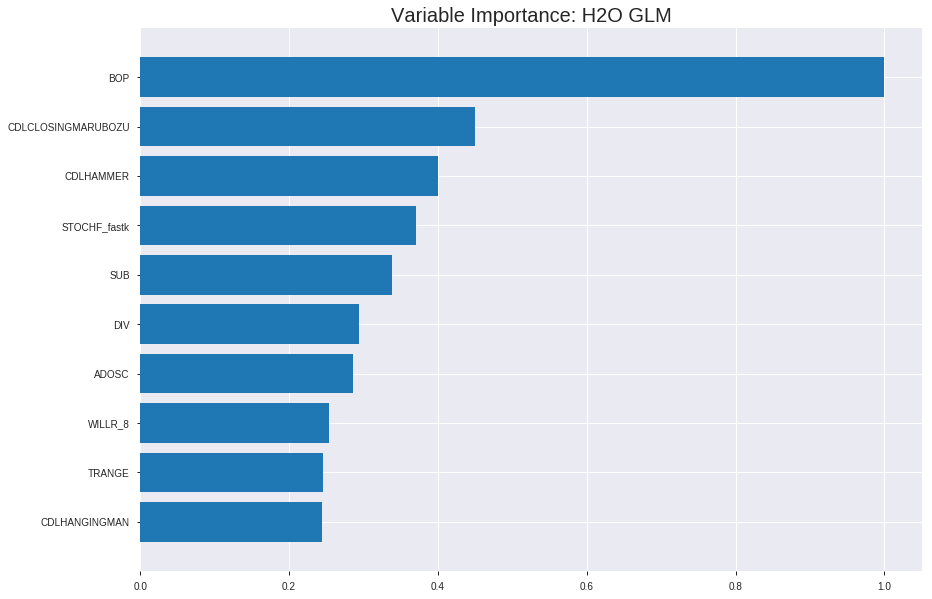

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_171044_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18294256607441609
RMSE: 0.42771785802607787
LogLoss: 0.5465010006267478
Null degrees of freedom: 1555
Residual degrees of freedom: 1497
Null deviance: 2155.7139305761725
Residual deviance: 1700.711113950439
AIC: 1818.711113950439
AUC: 0.8038891782622715
pr_auc: 0.8045402517976111
Gini: 0.6077783565245429
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37190638478677296: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  375   0.4967   (375.0/755.0)
1      91   710   0.1136   (91.0/801.0)
Total  471  1085  0.2995   (466.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371906     0.752916  261
max f2                       0.251317     0.851485  320
max f0point5                 0.575961     0.757202  166
max accuracy                 0.563721     0.739717  172
max precision                0.936452     1         0
max recall                   0.0416876    1         394
max specificity              0.936452     1         0
max absolute_mcc             0.563721     0.481664  172
max min_per_class_accuracy   0.531043     0.734082  185
max mean_per_class_accuracy  0.563721     0.74065   172

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.909614           1.69975   1.69975            0.875            0.921146  0.875                       0.921146            0.0174782       0.0174782                  69.975    69.975
    2        0.0205656                   0.891034           1.82116   1.76046            0.9375           0.899694  0.90625                     0.91042             0.0187266       0.0362047                  82.1161   76.0456
    3        0.0302057                   0.87716            1.94257   1.81858            1                0.885197  0.93617                     0.90237             0.0187266       0.0549313                  94.2572   81.8578
    4        0.0404884                   0.860689           1.94257   1.85007            1                0.869267  0.952381                    0.893963            0.019975        0.0749064                  94.2572   85.0068
    5        0.0501285                   0.838695           1.68356   1.81805            0.866667         0.847648  0.935897                    0.885056            0.0162297       0.0911361                  68.3562   81.8048
    6        0.100257                    0.794114           1.66862   1.74333            0.858974         0.815284  0.897436                    0.85017             0.0836454       0.174782                   66.8619   74.3334
    7        0.150386                    0.759908           1.76824   1.75164            0.910256         0.776454  0.901709                    0.825598            0.0886392       0.263421                   76.8238   75.1635
    8        0.200514                    0.728729           1.569     1.70598            0.807692         0.743517  0.878205                    0.805078            0.0786517       0.342072                   56.9      70.5977
    9        0.300129                    0.673163           1.42873   1.61396            0.735484         0.699708  0.830835                    0.770105            0.142322        0.484395                   42.873    61.3957
    10       0.400386                    0.614727           1.25769   1.52475            0.647436         0.643858  0.784912                    0.738493            0.126092        0.610487                   25.7691   52.4747
    11       0.5                         0.534949           1.17808   1.45568            0.606452         0.578307  0.749357                    0.706579            0.117353        0.72784                    17.8076   45.568
    12       0.600257                    0.443627           0.821857  1.34982            0.423077         0.49102   0.694861                    0.670576            0.082397        0.810237                   -17.8143  34.9817
    13       0.699871                    0.370593           0.764496  1.26651            0.393548         0.402906  0.651974                    0.632477            0.0761548       0.886392                   -23.5504  26.6507
    14       0.800129                    0.301776           0.523     1.17334            0.269231         0.337563  0.604016                    0.595524            0.0524345       0.938826                   -47.7     17.3345
    15       0.899743                    0.201457           0.350916  1.08229            0.180645         0.256183  0.557143                    0.557954            0.0349563       0.973783                   -64.9084  8.229
    16       1                           0.00991738         0.2615    1                  0.134615         0.127332  0.514781                    0.514782            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18677706104818392
RMSE: 0.4321771176823039
LogLoss: 0.5514775816945786
Null degrees of freedom: 444
Residual degrees of freedom: 386
Null deviance: 618.886943697008
Residual deviance: 490.8150477081749
AIC: 608.8150477081749
AUC: 0.7884397048090179
pr_auc: 0.7250741235307481
Gini: 0.5768794096180359
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3929429933665239: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  85   0.3602   (85.0/236.0)
1      40   169  0.1914   (40.0/209.0)
Total  191  254  0.2809   (125.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392943     0.730022  225
max f2                       0.203811     0.854879  324
max f0point5                 0.604882     0.719557  134
max accuracy                 0.474633     0.72809   194
max precision                0.942763     1         0
max recall                   0.0844135    1         371
max specificity              0.942763     1         0
max absolute_mcc             0.474633     0.455886  194
max min_per_class_accuracy   0.475539     0.724576  193
max mean_per_class_accuracy  0.474633     0.728317  194

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 46.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.893294           1.27751    1.27751            0.6              0.924475   0.6                         0.924475            0.0143541       0.0143541                  27.7512   27.7512
    2        0.0202247                   0.884813           2.12919    1.65603            1                0.890556   0.777778                    0.9094              0.0191388       0.0334928                  112.919   65.6034
    3        0.0314607                   0.86214            2.12919    1.82502            1                0.873657   0.857143                    0.896635            0.0239234       0.0574163                  112.919   82.5017
    4        0.0404494                   0.855662           2.12919    1.89261            1                0.859144   0.888889                    0.888303            0.0191388       0.076555                   112.919   89.261
    5        0.0516854                   0.845897           2.12919    1.94404            1                0.850559   0.913043                    0.880098            0.0239234       0.100478                   112.919   94.404
    6        0.101124                    0.797434           1.45172    1.70335            0.681818         0.815416   0.8                         0.848476            0.0717703       0.172249                   45.1718   70.3349
    7        0.150562                    0.753176           1.45172    1.62072            0.681818         0.776818   0.761194                    0.824946            0.0717703       0.244019                   45.1718   62.0724
    8        0.2                         0.705536           1.5485     1.60287            0.727273         0.727363   0.752809                    0.800825            0.076555        0.320574                   54.8499   60.2871
    9        0.301124                    0.636101           1.75066    1.6525             0.822222         0.672731   0.776119                    0.757808            0.177033        0.497608                   75.0665   65.2503
    10       0.4                         0.552907           1.30655    1.56699            0.613636         0.593436   0.735955                    0.717177            0.129187        0.626794                   30.6546   56.6986
    11       0.501124                    0.467524           1.13557    1.47993            0.533333         0.507478   0.695067                    0.674861            0.114833        0.741627                   13.5566   47.9928
    12       0.6                         0.369809           0.77425    1.36364            0.363636         0.412138   0.640449                    0.631566            0.076555        0.818182                   -22.575   36.3636
    13       0.698876                    0.306531           0.725859   1.2734             0.340909         0.333232   0.598071                    0.589358            0.0717703       0.889952                   -27.4141  27.3404
    14       0.8                         0.22694            0.709729   1.20215            0.333333         0.267651   0.564607                    0.548693            0.0717703       0.961722                   -29.0271  20.2153
    15       0.898876                    0.127218           0.290344   1.10185            0.136364         0.170269   0.5175                      0.507066            0.0287081       0.990431                   -70.9656  10.1854
    16       1                           0.00563662         0.0946305  1                  0.0444444        0.0676534  0.469663   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:10:44  0.000 sec   2            22        59            1.3578            1.3565
    2019-08-25 17:10:44  0.011 sec   4            14        59            1.34608           1.34226
    2019-08-25 17:10:44  0.023 sec   6            8.6       59            1.33105           1.32417
    2019-08-25 17:10:44  0.035 sec   8            5.4       59            1.31217           1.30171
    2019-08-25 17:10:44  0.046 sec   10           3.3       59            1.28897           1.27448
    2019-08-25 17:10:44  0.059 sec   12           2.1       59            1.26148           1.24286
    2019-08-25 17:10:44  0.070 sec   14           1.3       59            1.23091           1.20893
    2019-08-25 17:10:44  0.081 sec   16           0.8       59            1.19942           1.17597
    2019-08-25 17:10:44  0.092 sec   18           0.5       59            1.16964           1.14757
    2019-08-25 17:10:44  0.103 sec   20           0.31      59            1.14357           1.12612
    2019-08-25 17:10:44  0.114 sec   22           0.19      59            1.12219           1.11226
    2019-08-25 17:10:44  0.126 sec   24           0.12      59            1.10552           1.10512
    2019-08-25 17:10:44  0.137 sec   26           0.074     59            1.093             1.10296
    2019-08-25 17:10:44  0.152 sec   28           0.046     59            1.08387           1.10376
    2019-08-25 17:10:44  0.163 sec   30           0.028     59            1.07734           1.10592
    2019-08-25 17:10:44  0.183 sec   32           0.018     59            1.07269           1.10836
    2019-08-25 17:10:44  0.204 sec   34           0.011     59            1.06927           1.11076
    2019-08-25 17:10:44  0.226 sec   36           0.0068    59            1.06668           1.11301

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.748898678414097)

('auc', 0.7862857142857144)

('logloss', 0.5621365906416902)

('mean_per_class_error', 0.2416326530612245)

('rmse', 0.43589766636700367)

('mse', 0.19000677554419962)

glm prediction progress: |████████████████████████████████████████████████| 100%


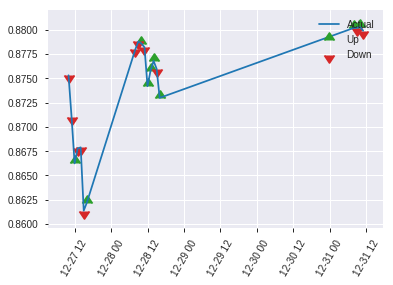


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19000677554419962
RMSE: 0.43589766636700367
LogLoss: 0.5621365906416902
Null degrees of freedom: 222
Residual degrees of freedom: 164
Null deviance: 310.9354893756444
Residual deviance: 250.71291942619382
AIC: 368.7129194261938
AUC: 0.7862857142857144
pr_auc: 0.6978151159898945
Gini: 0.5725714285714287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30239942764054883: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   44   0.352    (44.0/125.0)
1      13   85   0.1327   (13.0/98.0)
Total  94   129  0.2556   (57.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302399     0.748899  128
max f2                       0.0891501    0.820513  192
max f0point5                 0.334943     0.700692  119
max accuracy                 0.334943     0.748879  119
max precision                0.93464      1         0
max recall                   0.0495076    1         206
max specificity              0.93464      1         0
max absolute_mcc             0.302399     0.517975  128
max min_per_class_accuracy   0.401556     0.712     105
max mean_per_class_accuracy  0.331219     0.758367  121

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 39.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.888354           1.51701   1.51701            0.666667         0.905932   0.666667                    0.905932            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.875967           2.27551   1.82041            1                0.876574   0.8                         0.894189            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.84131            2.27551   1.95044            1                0.864313   0.857143                    0.885653            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.809875           1.13776   1.76984            0.5              0.826938   0.777778                    0.872605            0.0102041       0.0714286                  13.7755   76.9841
    5        0.0538117                   0.805862           1.51701   1.70663            0.666667         0.807141   0.75                        0.856239            0.0204082       0.0918367                  51.7007   70.6633
    6        0.103139                    0.744202           1.86178   1.78083            0.818182         0.775917   0.782609                    0.817824            0.0918367       0.183673                   86.1781   78.0834
    7        0.152466                    0.700879           1.86178   1.80702            0.818182         0.719272   0.794118                    0.78594             0.0918367       0.27551                    86.1781   80.7023
    8        0.201794                    0.642288           1.44805   1.71927            0.636364         0.673273   0.755556                    0.758399            0.0714286       0.346939                   44.8052   71.9274
    9        0.300448                    0.5416             1.24119   1.56229            0.545455         0.584541   0.686567                    0.701311            0.122449        0.469388                   24.1187   56.2291
    10       0.399103                    0.454184           1.65492   1.58519            0.727273         0.492289   0.696629                    0.649643            0.163265        0.632653                   65.4917   58.5187
    11       0.502242                    0.377049           1.38509   1.5441             0.608696         0.415627   0.678571                    0.601586            0.142857        0.77551                    38.5093   54.4096
    12       0.600897                    0.28862            0.930891  1.44342            0.409091         0.326537   0.634328                    0.556429            0.0918367       0.867347                   -6.91095  44.3421
    13       0.699552                    0.204613           0.310297  1.28362            0.136364         0.251528   0.564103                    0.51343             0.0306122       0.897959                   -68.9703  28.3621
    14       0.798206                    0.129677           0.413729  1.17611            0.181818         0.173168   0.516854                    0.471375            0.0408163       0.938776                   -58.6271  17.6106
    15       0.896861                    0.063445           0.413729  1.09224            0.181818         0.097131   0.48                        0.430208            0.0408163       0.979592                   -58.6271  9.22449
    16       1                           0.00204553         0.19787   1                  0.0869565        0.0401709  0.439462                   

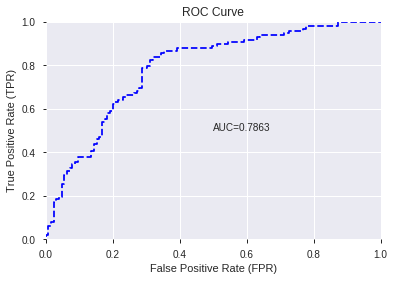

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


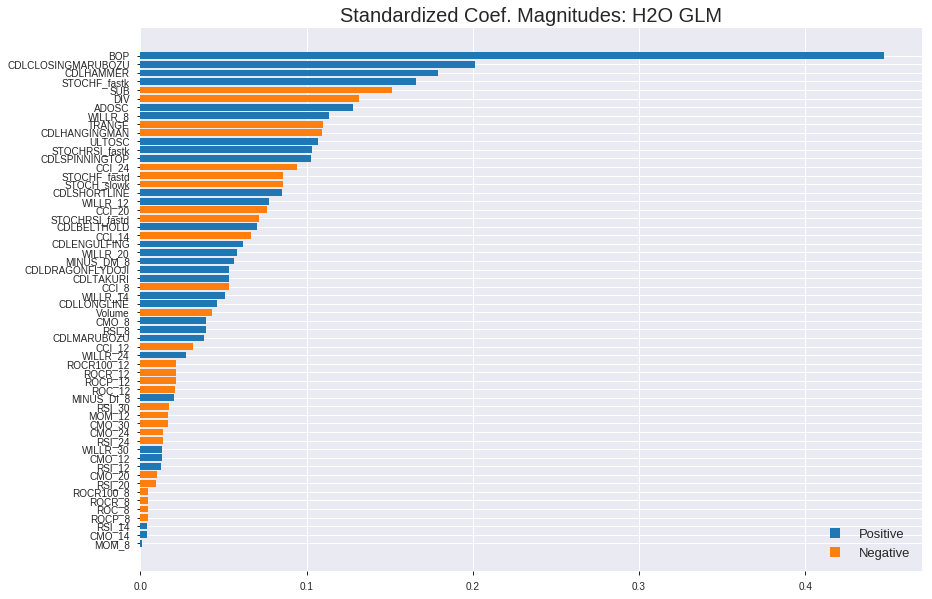

'log_likelihood'
--2019-08-25 17:10:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_171044_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_171044_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'STOCHF_fastk',
 'SUB',
 'DIV',
 'ADOSC',
 'WILLR_8',
 'TRANGE',
 'CDLHANGINGMAN',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CDLSPINNINGTOP',
 'CCI_24',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLSHORTLINE',
 'WILLR_12',
 'CCI_20',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'CCI_14',
 'CDLENGULFING',
 'WILLR_20',
 'MINUS_DM_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CCI_8',
 'WILLR_14',
 'CDLLONGLINE',
 'Volume',
 'CMO_8',
 'RSI_8',
 'CDLMARUBOZU',
 'CCI_12',
 'WILLR_24',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'MINUS_DI_8',
 'RSI_30',
 'MOM_12',
 'CMO_30',
 'CMO_24',
 'RSI_24',
 'WILLR_30',
 'CMO_12',
 'RSI_12',
 'CMO_20',
 'RSI_20',
 'ROCR100_8',
 'ROCR_8',
 'ROC_8',
 'ROCP_8',
 'RSI_14',
 'CMO_14',
 'MOM_8']

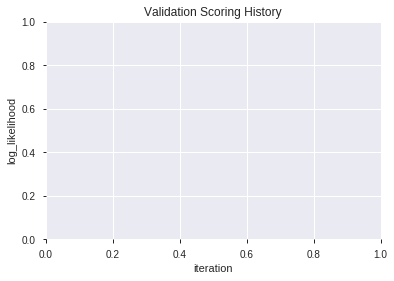

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_171058_model_1  0.781633  0.572152              0.255837  0.439900  0.193512
1  XGBoost_grid_1_AutoML_20190825_171058_model_6  0.781388  0.566192              0.255429  0.437338  0.191265
2  XGBoost_grid_1_AutoML_20190825_171058_model_5  0.780816  0.569206              0.247429  0.437295  0.191227
3               XGBoost_1_AutoML_20190825_171058  0.780408  0.569900              0.255429  0.437609  0.191502
4               XGBoost_3_AutoML_20190825_171058  0.776163  0.575423              0.262327  0.440144  0.193727
5  XGBoost_grid_1_AutoML_20190825_171058_model_7  0.775755  0.577673              0.275837  0.441437  0.194866
6  XGBoost_grid_1_AutoML_20190825_171058_model_2  0.773878  0.573766              0.260939  0.440791  0.194296
7  XGBoost_grid_1_AutoML_20190825_171058_model_3  0.773224  0.570681              0.265633  0.438279  0.192088
8               XGBoost_2_AutoML_20190825_171058  0.769633  0.581876              0.252531  0.444006  0.197142
9  XGBoost_grid_1_AutoML_20190825_171058_model_4  0.767429  0.580176              0.292122  0.444445  0.197531

variable  relative_importance  scaled_importance  percentage
0                  BOP          3152.334473           1.000000    0.354090
1               TRANGE           449.874298           0.142711    0.050533
2                  DIV           447.866058           0.142074    0.050307
3         STOCHF_fastk           435.129333           0.138034    0.048876
4                  SUB           380.639618           0.120748    0.042756
5   CDLCLOSINGMARUBOZU           312.276855           0.099062    0.035077
6       STOCHRSI_fastk           287.211090           0.091111    0.032261
7                ADOSC           282.711487           0.089683    0.031756
8            CDLHAMMER           233.013824           0.073918    0.026174
9          STOCH_slowk           222.179581           0.070481    0.024957
10              ULTOSC           218.433517           0.069293    0.024536
11              Volume           212.743835           0.067488    0.023897
12               CCI_8           203.684906           0.064614    0.022879
13             WILLR_8           155.509064           0.049331    0.017468
14               MOM_8           141.657425           0.044937    0.015912
15      STOCHRSI_fastd           141.278046           0.044817    0.015869
16              CCI_14           124.461334           0.039482    0.013980
17          MINUS_DM_8           112.750854           0.035767    0.012665
18          MINUS_DI_8           101.592194           0.032228    0.011411
19              CCI_12           101.575928           0.032222    0.011410
20            WILLR_20            93.065224           0.029523    0.010454
21              CCI_20            91.475746           0.029018    0.010275
22              MOM_12            76.553574           0.024285    0.008599
23            WILLR_30            75.313103           0.023891    0.008460
24               ROC_8            70.138199           0.022250    0.007878
25              CCI_24            69.660736           0.022098    0.007825
26            WILLR_12            68.458641           0.021717    0.007690
27            WILLR_24            55.815472           0.017706    0.006270
28              CMO_30            54.934059           0.017426    0.006171
29              CMO_24            54.482452           0.017283    0.006120
30            WILLR_14            51.267635           0.016263    0.005759
31              CMO_20            50.135464           0.015904    0.005632
32        STOCHF_fastd            48.849945           0.015496    0.005487
33               CMO_8            47.499207           0.015068    0.005335
34       CDLHANGINGMAN            47.010731           0.014913    0.005281
35              CMO_14            38.959507           0.012359    0.004376
36              ROC_12            38.413620           0.012186    0.004315
37              ROCP_8            33.913174           0.010758    0.003809
38      CDLSPINNINGTOP            22.990536           0.007293    0.002582
39              RSI_24            16.528904           0.005243    0.001857
40              CMO_12            14.711073           0.004667    0.001652
41             ROCP_12            14.074537           0.004465    0.001581
42           CDLTAKURI            12.345509           0.003916    0.001387
43         CDLBELTHOLD            10.775473           0.003418    0.001210
44              RSI_12             5.864604           0.001860    0.000659
45    CDLDRAGONFLYDOJI             5.750526           0.001824    0.000646
46              RSI_30             5.428508           0.001722    0.000610
47         CDLLONGLINE             4.594509           0.001457    0.000516
48              ROCR_8             3.834507           0.001216    0.000431
49              RSI_20             2.271430           0.000721    0.000255
50         CDLMARUBOZU             0.599758           0.000190    0.000067

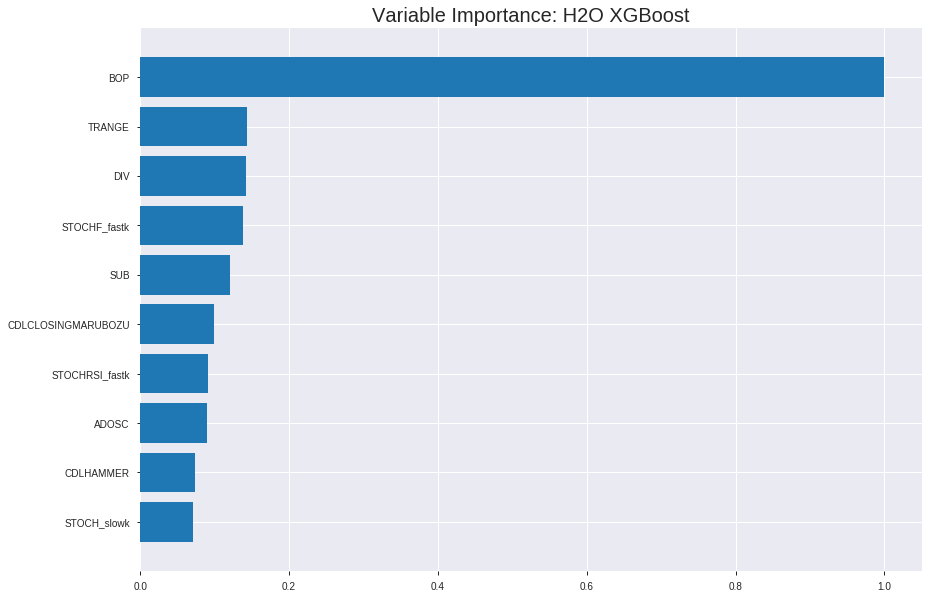

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_171058_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12845786657135527
RMSE: 0.35841019317446215
LogLoss: 0.4142192346903117
Mean Per-Class Error: 0.15703218658795715
AUC: 0.9187505684120016
pr_auc: 0.9218751235218947
Gini: 0.8375011368240033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4606296867132187: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      597  158  0.2093   (158.0/755.0)
1      84   717  0.1049   (84.0/801.0)
Total  681  875  0.1555   (242.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46063      0.855609  217
max f2                       0.33315      0.90402   274
max f0point5                 0.623924     0.853132  148
max accuracy                 0.463019     0.844473  216
max precision                0.954248     1         0
max recall                   0.182418     1         338
max specificity              0.954248     1         0
max absolute_mcc             0.46063      0.690951  217
max min_per_class_accuracy   0.509917     0.826467  197
max mean_per_class_accuracy  0.463019     0.842968  216

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.932173           1.94257    1.94257            1                0.942499   1                           0.942499            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.924784           1.94257    1.94257            1                0.927733   1                           0.935116            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.91461            1.94257    1.94257            1                0.919277   1                           0.930061            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.90733            1.94257    1.94257            1                0.909812   1                           0.924919            0.019975        0.0786517                  94.2572   94.2572
    5        0.0501285                   0.897484           1.94257    1.94257            1                0.900941   1                           0.920308            0.0187266       0.0973783                  94.2572   94.2572
    6        0.100257                    0.856774           1.91767    1.93012            0.987179         0.878002   0.99359                     0.899155            0.0961298       0.193508                   91.7667   93.0119
    7        0.150386                    0.821865           1.89276    1.91767            0.974359         0.838572   0.987179                    0.878961            0.0948814       0.28839                    89.2762   91.7667
    8        0.200514                    0.784489           1.86786    1.90521            0.961538         0.800459   0.980769                    0.859335            0.093633        0.382022                   86.7857   90.5215
    9        0.300129                    0.715728           1.69192    1.83442            0.870968         0.750532   0.944325                    0.823223            0.168539        0.550562                   69.1917   83.442
    10       0.400386                    0.613885           1.48183    1.74613            0.762821         0.668476   0.898876                    0.784474            0.148564        0.699126                   48.1834   74.6132
    11       0.5                         0.521916           1.16554    1.63046            0.6              0.5681     0.839332                    0.741366            0.116105        0.815231                   16.5543   63.0462
    12       0.600257                    0.423972           1.05845    1.53492            0.544872         0.473337   0.79015                     0.696599            0.106117        0.921348                   5.84526   53.4923
    13       0.699871                    0.337453           0.476243   1.38424            0.245161         0.384481   0.71258                     0.652174            0.0474407       0.968789                   -52.3757  38.4238
    14       0.800129                    0.241009           0.2615     1.24356            0.134615         0.294896   0.640161                    0.607407            0.0262172       0.995006                   -73.85    24.3558
    15       0.899743                    0.139301           0.0501309  1.11143            0.0258065        0.186634   0.572143                    0.560821            0.00499376      1                          -94.9869  11.1429
    16       1                           0.0381648          0          1                  0                0.0971653  0.514781  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17641542266105628
RMSE: 0.4200183599094881
LogLoss: 0.5285882949993614
Mean Per-Class Error: 0.24912821344578706
AUC: 0.8135491849809424
pr_auc: 0.7650725843098011
Gini: 0.6270983699618848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34400875866413116: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  96   0.4068   (96.0/236.0)
1      27   182  0.1292   (27.0/209.0)
Total  167  278  0.2764   (123.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344009     0.747433  251
max f2                       0.133582     0.848435  340
max f0point5                 0.591962     0.752688  143
max accuracy                 0.449814     0.750562  200
max precision                0.942602     1         0
max recall                   0.0878891    1         374
max specificity              0.942602     1         0
max absolute_mcc             0.449814     0.500922  200
max min_per_class_accuracy   0.455799     0.746411  197
max mean_per_class_accuracy  0.449814     0.750872  200

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 45.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.9296             2.12919    2.12919            1                0.937943   1                           0.937943            0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.920361           1.59689    1.89261            0.75             0.922851   0.888889                    0.931235            0.0143541       0.0382775                  59.689    89.261
    3        0.0314607                   0.918584           1.70335    1.82502            0.8              0.919486   0.857143                    0.927039            0.0191388       0.0574163                  70.3349   82.5017
    4        0.0404494                   0.910685           1.59689    1.77432            0.75             0.916202   0.833333                    0.924631            0.0143541       0.0717703                  59.689    77.4322
    5        0.0516854                   0.903224           1.70335    1.75889            0.8              0.907893   0.826087                    0.920992            0.0191388       0.0909091                  70.3349   75.8893
    6        0.101124                    0.851141           1.83884    1.79798            0.863636         0.872298   0.844444                    0.897186            0.0909091       0.181818                   83.8843   79.798
    7        0.150562                    0.804562           1.93562    1.84318            0.909091         0.827054   0.865672                    0.874158            0.0956938       0.277512                   93.5624   84.3176
    8        0.2                         0.740548           1.45172    1.74641            0.681818         0.775242   0.820225                    0.849707            0.0717703       0.349282                   45.1718   74.6411
    9        0.301124                    0.646829           1.5614     1.68428            0.733333         0.694087   0.791045                    0.797446            0.157895        0.507177                   56.1404   68.4282
    10       0.4                         0.528564           1.25816    1.57895            0.590909         0.590686   0.741573                    0.746337            0.124402        0.631579                   25.8156   57.8947
    11       0.501124                    0.440094           1.27751    1.51812            0.6              0.480003   0.713004                    0.692592            0.129187        0.760766                   27.7512   51.812
    12       0.6                         0.358862           0.77425    1.39553            0.363636         0.395389   0.655431                    0.643615            0.076555        0.837321                   -22.575   39.5534
    13       0.698876                    0.258971           0.725859   1.30079            0.340909         0.315078   0.610932                    0.597134            0.0717703       0.909091                   -27.4141  30.0789
    14       0.8                         0.15876            0.520468   1.20215            0.244444         0.209659   0.564607                    0.548155            0.0526316       0.961722                   -47.9532  20.2153
    15       0.898876                    0.111327           0.338734   1.10718            0.159091         0.134827   0.52                        0.502689            0.0334928       0.995215                   -66.1266  10.7177
    16       1                           0.0377066          0.0473153  1                  0.0222222        0.0789882  0.469663    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:11:02  0.026 sec   0                  0.5              0.693147            0.5             0                  1                0.485219                         0.5                0.693147              0.5               0                    1                  0.530337
    2019-08-25 17:11:03  0.112 sec   5                  0.465924         0.626732            0.845668        0.832811           1.94257          0.260283                         0.471232           0.636741              0.784436          0.740949             1.82502            0.314607
    2019-08-25 17:11:03  0.160 sec   10                 0.443266         0.583329            0.857689        0.860932           1.94257          0.224293                         0.45195            0.59918               0.800189          0.758607             2.12919            0.278652
    2019-08-25 17:11:03  0.208 sec   15                 0.425763         0.549529            0.866642        0.868708           1.94257          0.207584                         0.441195           0.577298              0.800361          0.751705             1.70335            0.283146
    2019-08-25 17:11:03  0.258 sec   20                 0.413269         0.524621            0.872658        0.874428           1.94257          0.199871                         0.434125           0.562161              0.805075          0.754468             1.27751            0.267416
    2019-08-25 17:11:03  0.309 sec   25                 0.404043         0.505707            0.876853        0.879782           1.94257          0.196658                         0.429459           0.551397              0.805774          0.7556               1.27751            0.265169
    2019-08-25 17:11:03  0.371 sec   30                 0.396156         0.489124            0.882311        0.885178           1.94257          0.190874                         0.42633            0.544029              0.808694          0.759784             1.70335            0.267416
    2019-08-25 17:11:03  0.430 sec   35                 0.388785         0.474142            0.889236        0.891754           1.94257          0.192802                         0.424427           0.539724              0.808825          0.757054             1.27751            0.278652
    2019-08-25 17:11:03  0.482 sec   40                 0.383042         0.462337            0.893872        0.896175           1.94257          0.183162                         0.423237           0.536651              0.809221          0.755832             1.27751            0.285393
    2019-08-25 17:11:03  0.530 sec   45                 0.378536         0.452694            0.897339        0.899831           1.94257          0.173522                         0.422065           0.533639              0.811035          0.753092             1.27751            0.274157
    2019-08-25 17:11:03  0.586 sec   50                 0.372402         0.44088             0.903875        0.907207           1.94257          0.170308                         0.421505           0.531997              0.811126          0.754593             1.27751            0.276404
    2019-08-25 17:11:03  0.630 sec   55                 0.368978         0.434135            0.907386        0.910783           1.94257          0.16581                          0.421218           0.531416              0.811633          0

Variable Importances: 


variable      relative_importance    scaled_importance       percentage
------------  ---------------------  ----------------------  ----------------------
BOP           3152.33447265625       1.0                     0.3540898478793717
TRANGE        449.8742980957031      0.1427114736706939      0.05053268400269696
DIV           447.8660583496094      0.1420744093732618      0.05030710600252985
STOCHF_fastk  435.12933349609375     0.13803399901579635     0.048876437713684676
SUB           380.6396179199219      0.120748486945671       0.04275581337425695
---           ---                    ---                     ---
RSI_30        5.4285078048706055     0.0017220595885234172   0.0006097638177394703
CDLLONGLINE   4.594509124755859      0.0014574941728453042   0.0005160838899478645
ROCR_8        3.8345072269439697     0.0012164024027922712   0.00043071574176481756
RSI_20        2.271430253982544      0.0007205549644827408   0.0002551411977624198
CDLMARUBOZU   0.5997581481933594     0.00019025841115393618  6.736857186326822e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.7305936073059361)

('auc', 0.7816326530612244)

('logloss', 0.5721524515363512)

('mean_per_class_error', 0.2522448979591837)

('rmse', 0.43989979198063994)

('mse', 0.19351182698461028)

xgboost prediction progress: |████████████████████████████████████████████| 100%


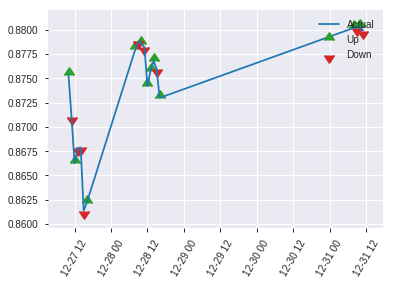


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19351182698461028
RMSE: 0.43989979198063994
LogLoss: 0.5721524515363512
Mean Per-Class Error: 0.2522448979591837
AUC: 0.7816326530612244
pr_auc: 0.6920614719921476
Gini: 0.5632653061224488
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36499160528182983: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   41   0.328    (41.0/125.0)
1      18   80   0.1837   (18.0/98.0)
Total  102  121  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364992     0.730594  120
max f2                       0.136074     0.82897   180
max f0point5                 0.387888     0.701107  110
max accuracy                 0.387888     0.744395  110
max precision                0.941189     1         0
max recall                   0.0970846    1         205
max specificity              0.941189     1         0
max absolute_mcc             0.387888     0.49187   110
max min_per_class_accuracy   0.394554     0.728     105
max mean_per_class_accuracy  0.387888     0.747755  110

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 42.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.935228           2.27551    2.27551            1                0.939183   1                           0.939183            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.918901           1.13776    1.82041            0.5              0.926137   0.8                         0.933964            0.0102041       0.0408163                  13.7755   82.0408
    3        0.0313901                   0.914862           2.27551    1.95044            1                0.915131   0.857143                    0.928583            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.89243            1.13776    1.76984            0.5              0.910404   0.777778                    0.924544            0.0102041       0.0714286                  13.7755   76.9841
    5        0.0538117                   0.888196           1.51701    1.70663            0.666667         0.88959    0.75                        0.915805            0.0204082       0.0918367                  51.7007   70.6633
    6        0.103139                    0.832119           1.65492    1.6819             0.727273         0.864375   0.73913                     0.891208            0.0816327       0.173469                   65.4917   68.1899
    7        0.152466                    0.775112           2.06865    1.80702            0.909091         0.811034   0.794118                    0.86527             0.102041        0.27551                    106.865   80.7023
    8        0.201794                    0.702239           1.44805    1.71927            0.636364         0.746904   0.755556                    0.836336            0.0714286       0.346939                   44.8052   71.9274
    9        0.300448                    0.576245           1.55148    1.66418            0.681818         0.642336   0.731343                    0.772634            0.153061        0.5                        55.1484   66.4179
    10       0.399103                    0.462576           1.13776    1.53405            0.5              0.51611    0.674157                    0.709224            0.112245        0.612245                   13.7755   53.4052
    11       0.502242                    0.387531           1.58296    1.5441             0.695652         0.418258   0.678571                    0.649472            0.163265        0.77551                    58.2964   54.4096
    12       0.600897                    0.309038           0.517161   1.37549            0.227273         0.351353   0.604478                    0.600527            0.0510204       0.826531                   -48.2839  37.5495
    13       0.699552                    0.193484           0.724026   1.28362            0.318182         0.237952   0.564103                    0.549395            0.0714286       0.897959                   -27.5974  28.3621
    14       0.798206                    0.13774            0.517161   1.18889            0.227273         0.163824   0.522472                    0.50174             0.0510204       0.94898                    -48.2839  18.889
    15       0.896861                    0.102874           0.413729   1.10362            0.181818         0.120787   0.485                       0.459835            0.0408163       0.989796                   -58.6271  10.3622
    16       1                           0.0711076          0.0989352  1                  0.0434783        0.0882987  0.439462  

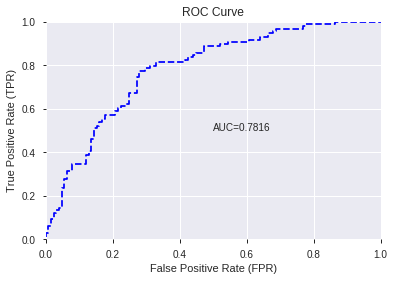

This function is available for GLM models only


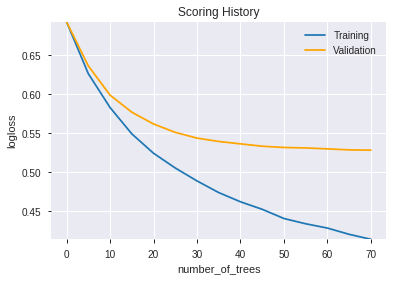

--2019-08-25 17:11:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_171058_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_171058_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLHAMMER',
 'STOCH_slowk',
 'ULTOSC',
 'Volume',
 'CCI_8',
 'WILLR_8',
 'MOM_8',
 'STOCHRSI_fastd',
 'CCI_14',
 'MINUS_DM_8',
 'MINUS_DI_8',
 'CCI_12',
 'WILLR_20',
 'CCI_20',
 'MOM_12',
 'WILLR_30',
 'ROC_8',
 'CCI_24',
 'WILLR_12',
 'WILLR_24',
 'CMO_30',
 'CMO_24',
 'WILLR_14',
 'CMO_20',
 'STOCHF_fastd',
 'CMO_8',
 'CDLHANGINGMAN',
 'CMO_14',
 'ROC_12',
 'ROCP_8',
 'CDLSPINNINGTOP',
 'RSI_24',
 'CMO_12',
 'ROCP_12',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'RSI_30',
 'CDLLONGLINE',
 'ROCR_8',
 'RSI_20',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

78

['BBANDS_middleband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_upperband_14_6_5',
 'BBANDS_middleband_14_7_3',
 'BBANDS_middleband_14_7_4',
 'DEMA_20',
 'BBANDS_upperband_20_0_3',
 'MA_20_1',
 'MAVP_20_1',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_middleband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_middleband_20_3_4',
 'BBANDS_middleband_20_5_4',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_lowerband_24_0_4',
 'BOP',
 'ADX_8',
 'CCI_8',
 'CMO_8',
 'MFI_8',
 'PLUS_DM_8',
 'RSI_8',
 'aroondown_12',
 'aroonup_12',
 'AROONOSC_12',
 'CMO_12',
 'PLUS_DM_12',
 'ROC_12',
 'ROCR_12',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MACDFIX_14',
 'MACDFIX_hist_14',
 'MOM_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'TRIX_14',
 'aroonup_20',
 'MACDFIX_20',
 'MINUS_DI_20',
 'MOM_20',
 'PLUS_DI_20',
 'RSI_20',
 'aroondown_24',
 'aroonup_24',
 'CCI_24',
 'DX_24',
 'MINUS_DI_24',
 'WILLR_24',
 'aroondown_30',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_171220_model_6  0.791592  0.648305              0.258327  0.474832  0.225465
1  DeepLearning_grid_1_AutoML_20190825_171220_model_5  0.790204  0.611747              0.269633  0.459873  0.211483
2  DeepLearning_grid_1_AutoML_20190825_171220_model_9  0.777551  0.605756              0.239143  0.460059  0.211654
3  DeepLearning_grid_1_AutoML_20190825_171220_model_4  0.777143  0.697956              0.299429  0.466661  0.217772
4  DeepLearning_grid_1_AutoML_20190825_171220_model_8  0.771265  0.624121              0.251837  0.468575  0.219562
5  DeepLearning_grid_1_AutoML_20190825_171220_model_3  0.770694  0.819414              0.294327  0.473235  0.223951
6  DeepLearning_grid_1_AutoML_20190825_171220_model_1  0.752082  2.542940              0.319837  0.614572  0.377699
7  DeepLearning_grid_1_AutoML_20190825_171220_model_2  0.743429  1.404560              0.330327  0.576018  0.331797
8  DeepLearning_grid_1_AutoML_20190825_171220_model_7  0.737306  0.638217              0.331714  0.468314  0.219318
9               DeepLearning_1_AutoML_20190825_171220  0.630531  0.703008              0.374735  0.499335  0.249336

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.021915
1                     TRANGE             0.890923           0.890923    0.019525
2         CDLCLOSINGMARUBOZU             0.764418           0.764418    0.016753
3                  CDLHAMMER             0.680436           0.680436    0.014912
4               STOCHF_fastk             0.635058           0.635058    0.013918
..                       ...                  ...                ...         ...
73                    MOM_14             0.545407           0.545407    0.011953
74  BBANDS_middleband_20_2_4             0.543081           0.543081    0.011902
75                     CMO_8             0.538093           0.538093    0.011793
76   BBANDS_upperband_20_1_4             0.533374           0.533374    0.011689
77   BBANDS_lowerband_14_6_4             0.516757           0.516757    0.011325

[78 rows x 4 columns]

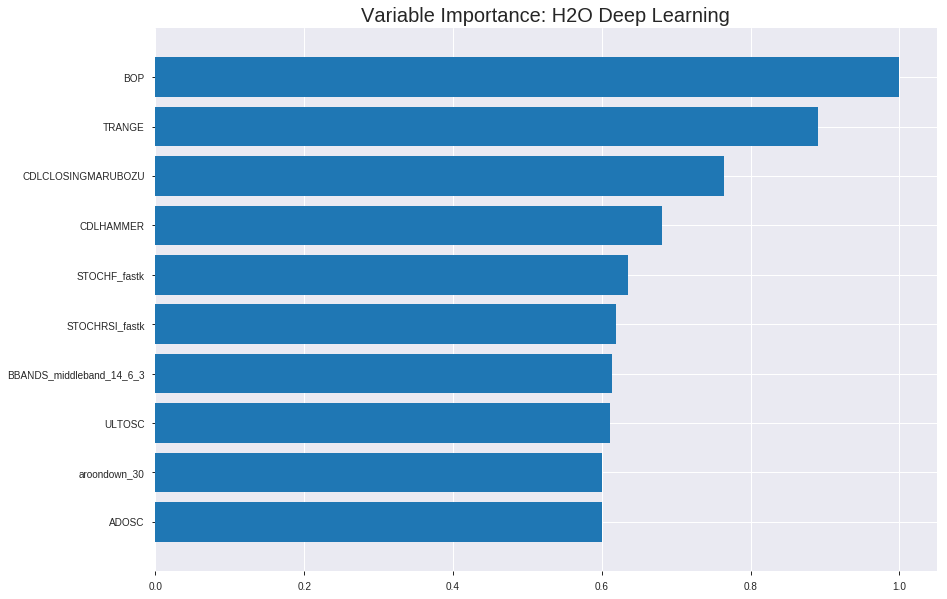

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_171220_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17896685702333895
RMSE: 0.4230447458878776
LogLoss: 0.5322281581896062
Mean Per-Class Error: 0.2646865259485247
AUC: 0.8088308488561484
pr_auc: 0.821215045108224
Gini: 0.6176616977122968
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4201544981708696: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      445  310  0.4106   (310.0/755.0)
1      116  685  0.1448   (116.0/801.0)
Total  561  995  0.2738   (426.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420154     0.762806  248
max f2                       0.234886     0.852713  326
max f0point5                 0.629662     0.752508  155
max accuracy                 0.471535     0.735219  225
max precision                0.985354     1         0
max recall                   0.0697847    1         383
max specificity              0.985354     1         0
max absolute_mcc             0.469298     0.472543  226
max min_per_class_accuracy   0.544484     0.732834  193
max mean_per_class_accuracy  0.560484     0.735313  185

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.967686           1.94257   1.94257            1                0.973502  1                           0.973502            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.958789           1.94257   1.94257            1                0.962747  1                           0.968125            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.946497           1.94257   1.94257            1                0.950377  1                           0.962461            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.9338             1.69975   1.8809             0.875            0.940523  0.968254                    0.956889            0.0174782       0.0761548                  69.975    88.0903
    5        0.0501285                   0.921631           1.94257   1.89276            1                0.926959  0.974359                    0.951133            0.0187266       0.0948814                  94.2572   89.2762
    6        0.100257                    0.865254           1.86786   1.88031            0.961538         0.891668  0.967949                    0.921401            0.093633        0.188514                   86.7857   88.031
    7        0.150386                    0.820252           1.64371   1.80144            0.846154         0.842518  0.92735                     0.895106            0.082397        0.270911                   64.3715   80.1445
    8        0.200514                    0.784386           1.46938   1.71843            0.75641          0.800711  0.884615                    0.871508            0.0736579       0.344569                   46.9381   71.8429
    9        0.300129                    0.710965           1.40366   1.61396            0.722581         0.747955  0.830835                    0.8305              0.139825        0.484395                   40.3665   61.3957
    10       0.400386                    0.62864            1.33241   1.54346            0.685897         0.670045  0.794543                    0.790322            0.133583        0.617978                   33.2405   54.3456
    11       0.5                         0.549281           1.07781   1.45069            0.554839         0.587531  0.746787                    0.74992             0.107366        0.725343                   7.7814    45.0687
    12       0.600257                    0.455628           0.983738  1.3727             0.50641          0.501285  0.706638                    0.708392            0.0986267       0.82397                    -1.62617  37.2695
    13       0.699871                    0.355794           0.651702  1.27007            0.335484         0.408653  0.653811                    0.665729            0.0649189       0.888889                   -34.8298  27.0074
    14       0.800129                    0.27628            0.535452  1.17803            0.275641         0.317367  0.606426                    0.622079            0.0536829       0.942572                   -46.4548  17.8025
    15       0.899743                    0.166464           0.338383  1.08507            0.174194         0.224207  0.558571                    0.578029            0.0337079       0.97628                    -66.1617  8.50651
    16       1                           0.00549884         0.236595  1                  0.121795         0.093913  0.514781                    0.529493          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20010606044348386
RMSE: 0.44733215896410117
LogLoss: 0.5877691476318903
Mean Per-Class Error: 0.2748966020598491
AUC: 0.7739944043467684
pr_auc: 0.7245999512322315
Gini: 0.5479888086935367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5078355913256133: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  99   0.4195   (99.0/236.0)
1      29   180  0.1388   (29.0/209.0)
Total  166  279  0.2876   (128.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507836     0.737705  246
max f2                       0.206934     0.840816  347
max f0point5                 0.615312     0.707502  189
max accuracy                 0.615312     0.725843  189
max precision                0.976099     1         0
max recall                   0.0908798    1         382
max specificity              0.976099     1         0
max absolute_mcc             0.507836     0.455882  246
max min_per_class_accuracy   0.609414     0.722488  194
max mean_per_class_accuracy  0.615312     0.725103  189

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 55.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.970838           2.12919   2.12919            1                0.973238  1                           0.973238            0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.961522           2.12919   2.12919            1                0.96908   1                           0.97139             0.0191388       0.0430622                  112.919   112.919
    3        0.0314607                   0.941556           1.70335   1.9771             0.8              0.947274  0.928571                    0.962777            0.0191388       0.062201                   70.3349   97.7102
    4        0.0404494                   0.927369           2.12919   2.0109             1                0.937536  0.944444                    0.957168            0.0191388       0.0813397                  112.919   101.09
    5        0.0516854                   0.913729           1.27751   1.85147            0.6              0.920175  0.869565                    0.949126            0.0143541       0.0956938                  27.7512   85.1467
    6        0.101124                    0.882628           1.64528   1.75066            0.772727         0.893935  0.822222                    0.922144            0.0813397       0.177033                   64.5281   75.0665
    7        0.150562                    0.836407           1.64528   1.71606            0.772727         0.860119  0.80597                     0.901778            0.0813397       0.258373                   64.5281   71.6061
    8        0.2                         0.803322           1.35494   1.62679            0.636364         0.817003  0.764045                    0.880822            0.0669856       0.325359                   35.4937   62.6794
    9        0.301124                    0.735366           1.32483   1.52539            0.622222         0.770621  0.716418                    0.843814            0.133971        0.45933                    32.4827   52.5387
    10       0.4                         0.674512           1.30655   1.47129            0.613636         0.70753   0.691011                    0.810126            0.129187        0.588517                   30.6546   47.1292
    11       0.501124                    0.603183           1.46677   1.47038            0.688889         0.636848  0.690583                    0.77516             0.148325        0.736842                   46.6773   47.038
    12       0.6                         0.523383           0.967812  1.38756            0.454545         0.563404  0.651685                    0.740264            0.0956938       0.832536                   -3.21879  38.756
    13       0.698876                    0.401953           0.629078  1.28025            0.295455         0.470907  0.601286                    0.702155            0.062201        0.894737                   -37.0922  28.025
    14       0.8                         0.289305           0.567783  1.19019            0.266667         0.34266   0.558989                    0.656713            0.0574163       0.952153                   -43.2217  19.0191
    15       0.898876                    0.180425           0.338734  1.09653            0.159091         0.231548  0.515                       0.609945            0.0334928       0.985646                   -66.1266  9.65311
    16       1                           0.00847576         0.141946  1                  0.0666667        0.104151  0.469663                    0.558797            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:16:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:16:13  1 min 58.539 sec  875 obs/sec       1.26478   1             1968       0.455558         0.685971            0.169141       0.785009        0.77633            1.94257          0.28599                          0.486826           0.770171              0.0484997        0.756863          0.717617             2.12919            0.334831
    2019-08-25 17:16:18  2 min  4.221 sec  1327 obs/sec      6.30784   5             9815       0.423045         0.532228            0.283506       0.808831        0.821215           1.94257          0.273779                         0.447332           0.587769              0.196618         0.773994          0.7246               2.12919            0.28764
    2019-08-25 17:16:24  2 min  9.652 sec  1763 obs/sec      13.9737   11            21743      0.420417         0.526169            0.292379       0.815141        0.821247           1.94257          0.283419                         0.450556           0.596859              0.184998         0.774988          0.736474             2.12919            0.301124
    2019-08-25 17:16:29  2 min 14.680 sec  2001 obs/sec      21.6594   17            33702      0.416741         0.515975            0.304699       0.830677        0.836649           1.94257          0.261568                         0.45696            0.628457              0.161665         0.774309          0.729759             2.12919            0.283146
    2019-08-25 17:16:35  2 min 20.232 sec  2173 obs/sec      30.5707   24            47568      0.405583         0.493322            0.341435       0.838252        0.838669           1.94257          0.251285                         0.449675           0.596861              0.188181         0.769352          0.733003             2.12919            0.31236
    2019-08-25 17:16:40  2 min 25.757 sec  2288 obs/sec      39.5559   31            61549      0.40424          0.49193             0.345787       0.840134        0.837199           1.82116          0.266067                         0.447729           0.591447              0.195191         0.775322          0.739366             2.12919            0.283146
    2019-08-25 17:16:45  2 min 31.070 sec  2379 obs/sec      48.4904   38            75451      0.399128         0.479592            0.362231       0.848563        0.855669           1.94257          0.251285                         0.445426           0.589112              0.203451         0.771835          0.72574              1.70335            0.303371
    2019-08-25 17:16:46  2 min 31.602 sec  2377 obs/sec      48.4904   38            75451      0.423045         0.532228            0.283506       0.808831        0.821215           1.94257          0.273779                         0.447332           0.587769              0.196618         0.773994          0.7246               2.12919            0.28764

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.021915491871154685
TRANGE                    0.8909228444099426     0.8909228444099426   0.01952501235449211
CDLCLOSINGMARUBOZU        0.764417827129364      0.764417827129364    0.016752592676619306
CDLHAMMER                 0.6804358959197998     0.6804358959197998   0.01491208734587223
STOCHF_fastk              0.6350578665733337     0.6350578665733337   0.013917605512600732
---                       ---                    ---                  ---
MOM_14                    0.5454065799713135     0.5454065799713135   0.011952853469835599
BBANDS_middleband_20_2_4  0.5430812835693359     0.5430812835693359   0.011901893455440035
CMO_8                     0.5380926132202148     0.5380926132202148   0.011792564290956
BBANDS_upperband_20_1_4   0.5333736538887024     0.5333736538887024   0.01168914597608593
BBANDS_lowerband_14_6_4   0.5167571902275085     0.5167571902275085   0.0113249880017917


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.735930735930736)

('auc', 0.7915918367346939)

('logloss', 0.6483047912125738)

('mean_per_class_error', 0.25832653061224486)

('rmse', 0.4748317144929946)

('mse', 0.22546515708835677)

deeplearning prediction progress: |███████████████████████████████████████| 100%


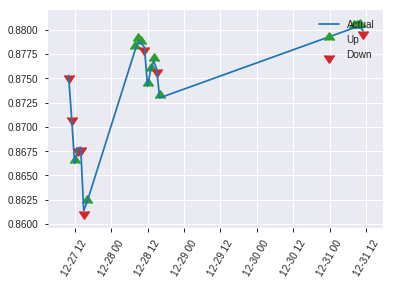


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22546515708835677
RMSE: 0.4748317144929946
LogLoss: 0.6483047912125738
Mean Per-Class Error: 0.25832653061224486
AUC: 0.7915918367346939
pr_auc: 0.7107230092012903
Gini: 0.5831836734693878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6242512179663526: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   48   0.384    (48.0/125.0)
1      13   85   0.1327   (13.0/98.0)
Total  90   133  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.624251     0.735931  132
max f2                       0.456333     0.827402  169
max f0point5                 0.788796     0.692308  72
max accuracy                 0.704984     0.730942  105
max precision                0.949396     1         0
max recall                   0.240977     1         210
max specificity              0.949396     1         0
max absolute_mcc             0.624251     0.488967  132
max min_per_class_accuracy   0.704984     0.728     105
max mean_per_class_accuracy  0.624251     0.741673  132

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 63.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.941895           2.27551   2.27551            1                0.945046  1                           0.945046            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.933558           1.13776   1.82041            0.5              0.936485  0.8                         0.941622            0.0102041       0.0408163                  13.7755   82.0408
    3        0.0313901                   0.930002           2.27551   1.95044            1                0.932224  0.857143                    0.938937            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.925775           2.27551   2.02268            1                0.929181  0.888889                    0.936769            0.0204082       0.0816327                  127.551   102.268
    5        0.0538117                   0.918452           1.51701   1.89626            0.666667         0.921769  0.833333                    0.933019            0.0204082       0.102041                   51.7007   89.6259
    6        0.103139                    0.884804           1.65492   1.78083            0.727273         0.899141  0.782609                    0.916817            0.0816327       0.183673                   65.4917   78.0834
    7        0.152466                    0.865205           1.86178   1.80702            0.818182         0.874271  0.794118                    0.903052            0.0918367       0.27551                    86.1781   80.7023
    8        0.201794                    0.838685           1.24119   1.66871            0.545455         0.854441  0.733333                    0.891169            0.0612245       0.336735                   24.1187   66.8707
    9        0.300448                    0.800316           1.75835   1.69814            0.772727         0.814889  0.746269                    0.866122            0.173469        0.510204                   75.8349   69.8142
    10       0.399103                    0.753725           1.13776   1.55962            0.5              0.775823  0.685393                    0.843801            0.112245        0.622449                   13.7755   55.9619
    11       0.502242                    0.689276           1.28616   1.50346            0.565217         0.719784  0.660714                    0.818333            0.132653        0.755102                   28.6158   50.3462
    12       0.600897                    0.618818           1.13776   1.44342            0.5              0.655927  0.634328                    0.791669            0.112245        0.867347                   13.7755   44.3421
    13       0.699552                    0.548737           0.413729  1.29821            0.181818         0.589525  0.570513                    0.763162            0.0408163       0.908163                   -58.6271  29.8208
    14       0.798206                    0.386332           0.413729  1.18889            0.181818         0.473306  0.522472                    0.727337            0.0408163       0.94898                    -58.6271  18.889
    15       0.896861                    0.274799           0.310297  1.09224            0.136364         0.330612  0.48                        0.683697            0.0306122       0.979592                   -68.9703  9.22449
    16       1                           0.0646994          0.19787   1                  0.0869565        0.199266  0.439462                    0.633733          

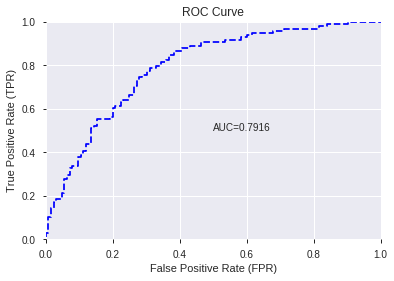

This function is available for GLM models only


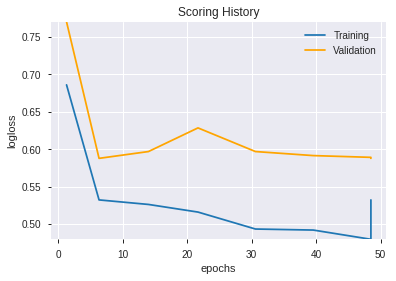

--2019-08-25 17:19:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_171220_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_171220_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'BBANDS_middleband_14_6_3',
 'ULTOSC',
 'aroondown_30',
 'ADOSC',
 'BETA_8',
 'HT_DCPERIOD',
 'aroondown_12',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'PLUS_DM_12',
 'AROONOSC_14',
 'CMO_12',
 'BBANDS_upperband_20_1_5',
 'aroonup_14',
 'aroondown_24',
 'CDLSPINNINGTOP',
 'MFI_8',
 'MINUS_DI_24',
 'aroonup_24',
 'STOCHF_fastd',
 'MOM_20',
 'DX_24',
 'ROC_12',
 'MACDFIX_20',
 'PLUS_DM_30',
 'RSI_20',
 'BBANDS_middleband_20_5_4',
 'RSI_8',
 'TRIX_14',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_24_0_4',
 'PLUS_DI_30',
 'MACDFIX_hist_14',
 'DEMA_20',
 'PLUS_DI_14',
 'MAVP_20_1',
 'LINEARREG_SLOPE_8',
 'WILLR_30',
 'MA_20_1',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lowerband_20_6_5',
 'aroonup_20',
 'CCI_24',
 'WILLR_24',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_middleband_20_3_4',
 'MINUS_DI_20',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_14_6_4',
 'AVGPRICE',
 'PLUS_DM_8',
 'aro

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_172005_model_1  0.786694  0.559946              0.248531  0.433395  0.187831

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.518245           1.000000    0.130681
1                     TRANGE             0.293687           0.566695    0.074056
2         CDLCLOSINGMARUBOZU             0.221887           0.428151    0.055951
3                  CDLHAMMER             0.203365           0.392411    0.051281
4               STOCHF_fastk             0.184483           0.355976    0.046519
..                       ...                  ...                ...         ...
73                   MA_20_1             0.001155           0.002228    0.000291
74               AROONOSC_12             0.000805           0.001552    0.000203
75  BBANDS_middleband_14_7_3             0.000435           0.000838    0.000110
76  BBANDS_middleband_14_7_4             0.000213           0.000411    0.000054
77   BBANDS_upperband_14_6_5             0.000088           0.000170    0.000022

[78 rows x 4 columns]

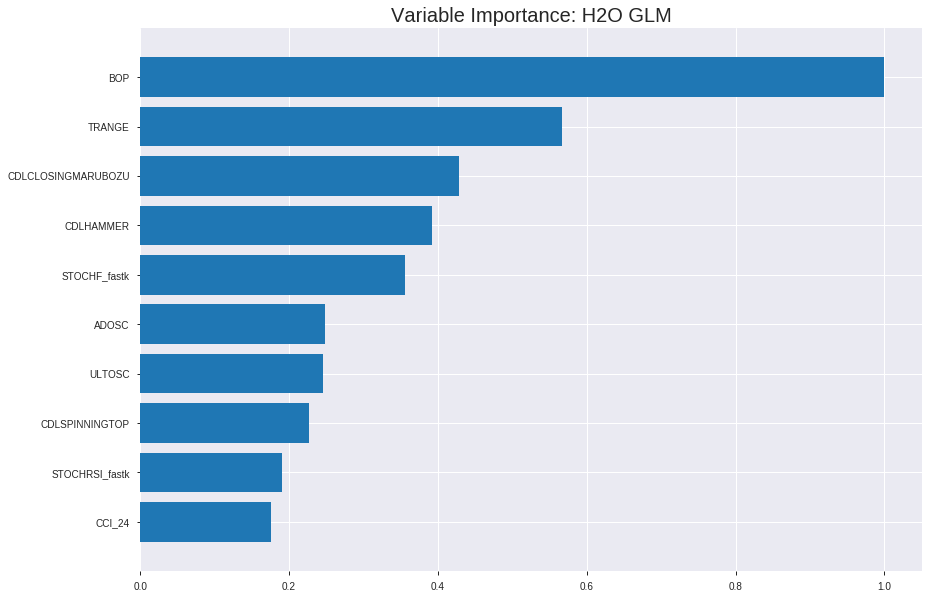

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_172005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18410113882154405
RMSE: 0.4290700861415814
LogLoss: 0.54887791582467
Null degrees of freedom: 1555
Residual degrees of freedom: 1477
Null deviance: 2155.7139305761725
Residual deviance: 1708.1080740463735
AIC: 1866.1080740463735
AUC: 0.8028251109953618
pr_auc: 0.808347033205458
Gini: 0.6056502219907236
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4312586238361175: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      447  308  0.4079   (308.0/755.0)
1      128  673  0.1598   (128.0/801.0)
Total  575  981  0.2802   (436.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431259     0.755331  233
max f2                       0.248861     0.854007  323
max f0point5                 0.614795     0.748872  148
max accuracy                 0.52904      0.736504  189
max precision                0.912583     1         0
max recall                   0.0886992    1         385
max specificity              0.912583     1         0
max absolute_mcc             0.52904      0.472681  189
max min_per_class_accuracy   0.533258     0.732834  187
max mean_per_class_accuracy  0.52904      0.736387  189

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.878162           1.82116   1.82116            0.9375           0.889228  0.9375                      0.889228            0.0187266       0.0187266                  82.1161   82.1161
    2        0.0205656                   0.860964           1.82116   1.82116            0.9375           0.86678   0.9375                      0.878004            0.0187266       0.0374532                  82.1161   82.1161
    3        0.0302057                   0.848595           1.94257   1.85991            1                0.853578  0.957447                    0.870208            0.0187266       0.0561798                  94.2572   85.9909
    4        0.0404884                   0.840071           1.94257   1.8809             1                0.844301  0.968254                    0.863629            0.019975        0.0761548                  94.2572   88.0903
    5        0.0501285                   0.825231           1.81307   1.86786            0.933333         0.833169  0.961538                    0.857771            0.0174782       0.093633                   81.3067   86.7857
    6        0.100257                    0.773564           1.76824   1.81805            0.910256         0.796668  0.935897                    0.827219            0.0886392       0.182272                   76.8238   81.8048
    7        0.150386                    0.744816           1.71843   1.78484            0.884615         0.760534  0.918803                    0.804991            0.0861423       0.268414                   71.8429   78.4842
    8        0.200514                    0.716794           1.44448   1.69975            0.74359          0.729471  0.875                       0.786111            0.0724095       0.340824                   44.4476   69.975
    9        0.300129                    0.668418           1.44126   1.61396            0.741935         0.6926    0.830835                    0.755074            0.143571        0.484395                   44.1263   61.3957
    10       0.400386                    0.616961           1.29505   1.5341             0.666667         0.644531  0.789727                    0.727394            0.129838        0.614232                   29.5048   53.4102
    11       0.5                         0.534923           1.14048   1.45568            0.587097         0.578926  0.749357                    0.697815            0.113608        0.72784                    14.0478   45.568
    12       0.600257                    0.450953           0.859214  1.35606            0.442308         0.489415  0.698073                    0.663007            0.0861423       0.813983                   -14.0786  35.6057
    13       0.699871                    0.376375           0.651702  1.2558             0.335484         0.412714  0.646465                    0.627382            0.0649189       0.878901                   -34.8298  25.5804
    14       0.800129                    0.313196           0.560357  1.16866            0.288462         0.345062  0.601606                    0.592007            0.0561798       0.935081                   -43.9643  16.8664
    15       0.899743                    0.210941           0.426113  1.08645            0.219355         0.268061  0.559286                    0.556142            0.0424469       0.977528                   -57.3887  8.64526
    16       1                           0.0116151          0.224143  1                  0.115385         0.1436    0.514781                    0.514782           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1904160442135728
RMSE: 0.43636686883123105
LogLoss: 0.5638102919084929
Null degrees of freedom: 444
Residual degrees of freedom: 366
Null deviance: 618.886943697008
Residual deviance: 501.79115979855874
AIC: 659.7911597985587
AUC: 0.7823473359824832
pr_auc: 0.7025928084933689
Gini: 0.5646946719649664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4486276438601639: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  91   0.3856   (91.0/236.0)
1      31   178  0.1483   (31.0/209.0)
Total  176  269  0.2742   (122.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448628     0.74477   237
max f2                       0.25647      0.845833  322
max f0point5                 0.607443     0.705755  152
max accuracy                 0.465928     0.72809   227
max precision                0.952638     1         0
max recall                   0.112728     1         375
max specificity              0.952638     1         0
max absolute_mcc             0.448628     0.475728  237
max min_per_class_accuracy   0.534777     0.716102  188
max mean_per_class_accuracy  0.462948     0.734338  230

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.883656           0.851675  0.851675           0.4              0.925155  0.4                         0.925155            0.00956938      0.00956938                 -14.8325  -14.8325
    2        0.0202247                   0.86666            2.12919   1.41946            1                0.87337   0.666667                    0.902139            0.0191388       0.0287081                  112.919   41.9458
    3        0.0314607                   0.860203           1.70335   1.52085            0.8              0.864803  0.714286                    0.888805            0.0191388       0.0478469                  70.3349   52.0848
    4        0.0404494                   0.855731           2.12919   1.65603            1                0.857431  0.777778                    0.881833            0.0191388       0.0669856                  112.919   65.6034
    5        0.0516854                   0.847956           1.27751   1.57375            0.6              0.851153  0.73913                     0.875163            0.0143541       0.0813397                  27.7512   57.3747
    6        0.101124                    0.794409           1.74206   1.65603            0.818182         0.818457  0.777778                    0.84744             0.0861244       0.167464                   74.2062   65.6034
    7        0.150562                    0.758963           1.64528   1.6525             0.772727         0.77422   0.776119                    0.823398            0.0813397       0.248804                   64.5281   65.2503
    8        0.2                         0.734258           1.5485    1.62679            0.727273         0.749422  0.764045                    0.805112            0.076555        0.325359                   54.8499   62.6794
    9        0.301124                    0.676187           1.32483   1.52539            0.622222         0.705322  0.716418                    0.7716              0.133971        0.45933                    32.4827   52.5387
    10       0.4                         0.607186           1.64528   1.55502            0.772727         0.638236  0.730337                    0.738634            0.162679        0.62201                    64.5281   55.5024
    11       0.501124                    0.522497           1.08825   1.46083            0.511111         0.562294  0.686099                    0.70305             0.110048        0.732057                   8.82509   46.0832
    12       0.6                         0.451704           1.11298   1.40351            0.522727         0.489533  0.659176                    0.667863            0.110048        0.842105                   11.2984   40.3509
    13       0.698876                    0.363184           0.629078  1.29394            0.295455         0.400033  0.607717                    0.629971            0.062201        0.904306                   -37.0922  29.3943
    14       0.8                         0.272548           0.520468  1.19617            0.244444         0.316608  0.561798                    0.59036             0.0526316       0.956938                   -47.9532  19.6172
    15       0.898876                    0.173516           0.290344  1.09653            0.136364         0.222383  0.515                       0.549883            0.0287081       0.985646                   -70.9656  9.65311
    16       1                           0.021567           0.141946  1                  0.0666667        0.105247  0.469663                    0.50492         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:20:06  0.000 sec   2            22        79            1.36859           1.37494
    2019-08-25 17:20:06  0.018 sec   4            14        79            1.36041           1.36722
    2019-08-25 17:20:06  0.035 sec   6            8.6       79            1.34911           1.35629
    2019-08-25 17:20:06  0.052 sec   8            5.4       79            1.33392           1.34111
    2019-08-25 17:20:06  0.072 sec   10           3.3       79            1.31412           1.32043
    2019-08-25 17:20:06  0.090 sec   12           2.1       79            1.28933           1.29367
    2019-08-25 17:20:06  0.109 sec   14           1.3       79            1.26002           1.26172
    2019-08-25 17:20:06  0.127 sec   16           0.8       79            1.22771           1.22723
    2019-08-25 17:20:06  0.144 sec   18           0.5       79            1.19476           1.19382
    2019-08-25 17:20:06  0.164 sec   20           0.31      79            1.16378           1.16532
    2019-08-25 17:20:06  0.184 sec   22           0.19      79            1.13679           1.14433
    2019-08-25 17:20:06  0.202 sec   24           0.12      79            1.11479           1.13187
    2019-08-25 17:20:06  0.219 sec   26           0.074     79            1.09776           1.12762
    2019-08-25 17:20:06  0.236 sec   28           0.046     79            1.08504           1.1303
    2019-08-25 17:20:06  0.253 sec   30           0.028     79            1.0757            1.13827
    2019-08-25 17:20:06  0.270 sec   32           0.018     79            1.0688            1.15008
    2019-08-25 17:20:06  0.288 sec   34           0.011     79            1.06358           1.16519
    2019-08-25 17:20:06  0.305 sec   36           0.0068    79            1.05957           1.18209

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7410714285714286)

('auc', 0.7866938775510204)

('logloss', 0.5599463511603128)

('mean_per_class_error', 0.2431428571428571)

('rmse', 0.433395102057597)

('mse', 0.18783131448751494)

glm prediction progress: |████████████████████████████████████████████████| 100%


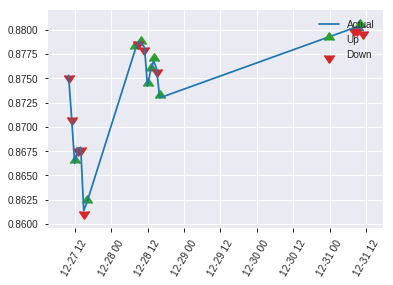


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18783131448751494
RMSE: 0.433395102057597
LogLoss: 0.5599463511603128
Null degrees of freedom: 222
Residual degrees of freedom: 144
Null deviance: 310.9354893756444
Residual deviance: 249.7360726174995
AIC: 407.73607261749953
AUC: 0.7866938775510204
pr_auc: 0.6960890619440604
Gini: 0.5733877551020408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40229793963631616: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   43   0.344    (43.0/125.0)
1      15   83   0.1531   (15.0/98.0)
Total  97   126  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402298     0.741071  125
max f2                       0.239065     0.819964  168
max f0point5                 0.456065     0.710332  110
max accuracy                 0.456065     0.753363  110
max precision                0.865587     0.875     7
max recall                   0.0786541    1         211
max specificity              0.927681     0.992     0
max absolute_mcc             0.456065     0.50994   110
max min_per_class_accuracy   0.483232     0.744     104
max mean_per_class_accuracy  0.456065     0.756857  110

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 45.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.880549           1.51701   1.51701            0.666667         0.897304   0.666667                    0.897304            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.875712           2.27551   1.82041            1                0.878055   0.8                         0.889604            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.868839           2.27551   1.95044            1                0.875195   0.857143                    0.885487            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.855497           1.13776   1.76984            0.5              0.861738   0.777778                    0.88021             0.0102041       0.0714286                  13.7755   76.9841
    5        0.0538117                   0.850348           2.27551   1.89626            1                0.852154   0.833333                    0.873196            0.0306122       0.102041                   127.551   89.6259
    6        0.103139                    0.809036           1.65492   1.78083            0.727273         0.826801   0.782609                    0.851007            0.0816327       0.183673                   65.4917   78.0834
    7        0.152466                    0.764235           1.86178   1.80702            0.818182         0.781444   0.794118                    0.828501            0.0918367       0.27551                    86.1781   80.7023
    8        0.201794                    0.683305           1.24119   1.66871            0.545455         0.734132   0.733333                    0.805433            0.0612245       0.336735                   24.1187   66.8707
    9        0.300448                    0.613402           1.55148   1.63022            0.681818         0.643494   0.716418                    0.752259            0.153061        0.489796                   55.1484   63.0216
    10       0.399103                    0.551041           1.34462   1.55962            0.590909         0.579188   0.685393                    0.709478            0.132653        0.622449                   34.462    55.9619
    11       0.502242                    0.454792           1.58296   1.56441            0.695652         0.501854   0.6875                      0.666841            0.163265        0.785714                   58.2964   56.4413
    12       0.600897                    0.378774           0.724026  1.42644            0.318182         0.415064   0.626866                    0.625504            0.0714286       0.857143                   -27.5974  42.6439
    13       0.699552                    0.304707           0.517161  1.29821            0.227273         0.346219   0.570513                    0.586118            0.0510204       0.908163                   -48.2839  29.8208
    14       0.798206                    0.207031           0.310297  1.17611            0.136364         0.24901    0.516854                    0.544453            0.0306122       0.938776                   -68.9703  17.6106
    15       0.896861                    0.118917           0.310297  1.08087            0.136364         0.155935   0.475                       0.501716            0.0306122       0.969388                   -68.9703  8.08673
    16       1                           0.00240414         0.296806  1                  0.130435         0.0713486  0.439462                   

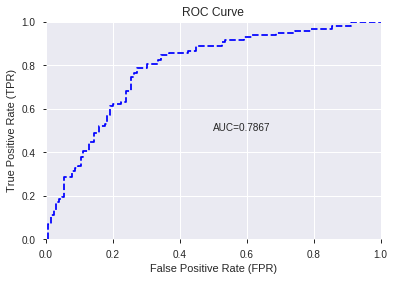

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


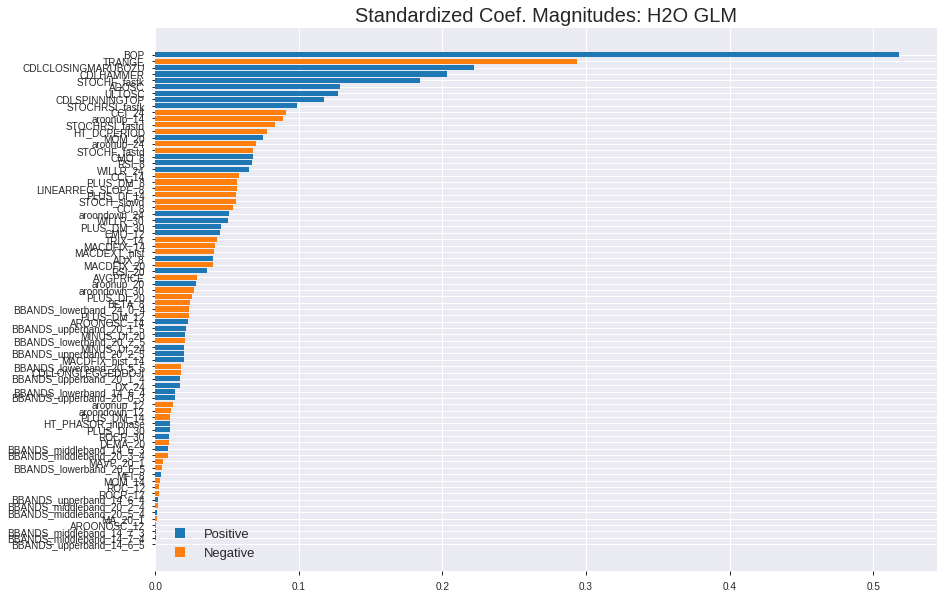

'log_likelihood'
--2019-08-25 17:20:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_172005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_172005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'STOCHF_fastk',
 'ADOSC',
 'ULTOSC',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'CCI_24',
 'aroonup_14',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'MOM_20',
 'aroonup_24',
 'STOCHF_fastd',
 'CMO_8',
 'RSI_8',
 'WILLR_24',
 'CCI_14',
 'PLUS_DM_8',
 'LINEARREG_SLOPE_8',
 'PLUS_DI_14',
 'STOCH_slowd',
 'CCI_8',
 'aroondown_24',
 'WILLR_30',
 'PLUS_DM_30',
 'CMO_12',
 'TRIX_14',
 'MACDFIX_14',
 'MACDEXT_hist',
 'ADX_8',
 'MACDFIX_20',
 'RSI_20',
 'AVGPRICE',
 'aroonup_20',
 'aroondown_30',
 'PLUS_DI_20',
 'BETA_8',
 'BBANDS_lowerband_24_0_4',
 'PLUS_DM_12',
 'AROONOSC_14',
 'BBANDS_upperband_20_1_5',
 'MINUS_DI_20',
 'BBANDS_lowerband_20_2_5',
 'MINUS_DI_24',
 'BBANDS_upperband_20_2_5',
 'MACDFIX_hist_14',
 'BBANDS_lowerband_20_5_5',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_upperband_20_1_4',
 'DX_24',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_upperband_20_0_3',
 'aroonup_12',
 'aroondown_12',
 'PLUS_DM_14',
 'HT_PHASOR_inphase',
 'PLUS_DI_30',
 'ROCR_30',
 

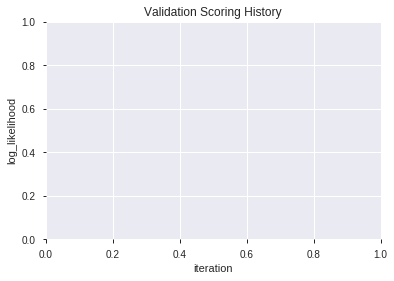

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_172032_model_1  0.785796  0.566298              0.271837  0.435653  0.189794
1  XGBoost_grid_1_AutoML_20190825_172032_model_3  0.780653  0.567195              0.279143  0.437348  0.191274
2  XGBoost_grid_1_AutoML_20190825_172032_model_6  0.777878  0.566437              0.259143  0.437184  0.191130
3               XGBoost_3_AutoML_20190825_172032  0.775673  0.570222              0.292122  0.439135  0.192839
4  XGBoost_grid_1_AutoML_20190825_172032_model_7  0.775184  0.573877              0.308816  0.440016  0.193614
5               XGBoost_2_AutoML_20190825_172032  0.771020  0.571743              0.307714  0.441081  0.194553
6               XGBoost_1_AutoML_20190825_172032  0.770449  0.573619              0.269347  0.440563  0.194096
7  XGBoost_grid_1_AutoML_20190825_172032_model_2  0.768653  0.575784              0.277224  0.441099  0.194568
8  XGBoost_grid_1_AutoML_20190825_172032_model_4  0.762694  0.579224              0.271429  0.443872  0.197023
9  XGBoost_grid_1_AutoML_20190825_172032_model_5  0.752245  0.595069              0.294449  0.450470  0.202923

variable  relative_importance  scaled_importance  percentage
0                        BOP          3311.310547           1.000000    0.354542
1                     TRANGE          1096.088623           0.331014    0.117358
2               STOCHF_fastk           385.160858           0.116317    0.041239
3         CDLCLOSINGMARUBOZU           311.084229           0.093946    0.033308
4                  CDLHAMMER           260.392395           0.078637    0.027880
..                       ...                  ...                ...         ...
72         CDLLONGLEGGEDDOJI             8.334641           0.002517    0.000892
73   BBANDS_upperband_20_1_5             8.178755           0.002470    0.000876
74                   ROCR_12             8.077581           0.002439    0.000865
75  BBANDS_middleband_20_3_4             6.390171           0.001930    0.000684
76  BBANDS_middleband_14_7_3             2.921574           0.000882    0.000313

[77 rows x 4 columns]

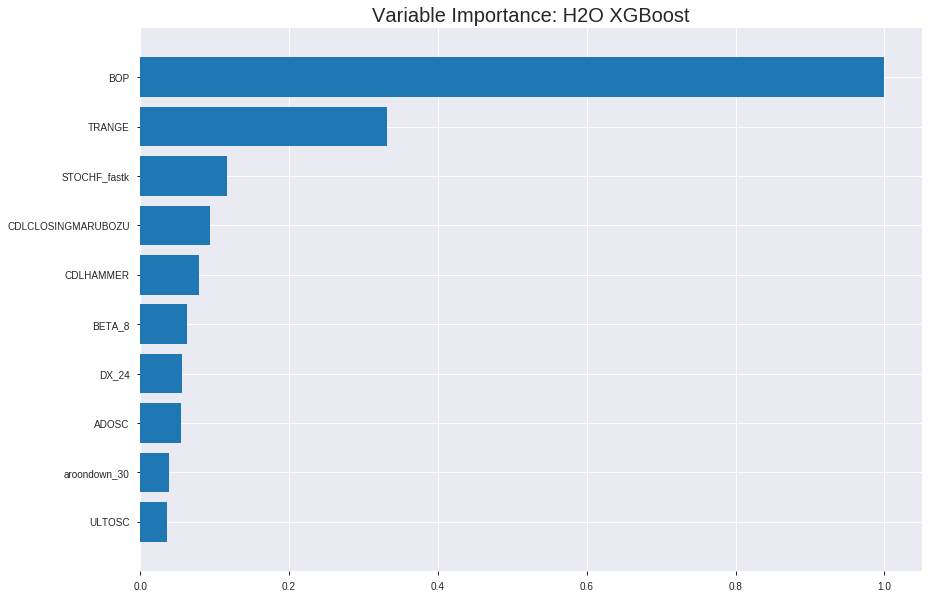

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_172032_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12213982696135
RMSE: 0.3494850883247381
LogLoss: 0.40051242859753805
Mean Per-Class Error: 0.1504253788724359
AUC: 0.9323163925887342
pr_auc: 0.9373046815740746
Gini: 0.8646327851774684
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4461137652397156: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      578  177  0.2344   (177.0/755.0)
1      62   739  0.0774   (62.0/801.0)
Total  640  916  0.1536   (239.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446114     0.860804  236
max f2                       0.333462     0.909408  280
max f0point5                 0.605646     0.865242  168
max accuracy                 0.493497     0.850257  216
max precision                0.958381     1         0
max recall                   0.180751     1         345
max specificity              0.958381     1         0
max absolute_mcc             0.471934     0.700622  224
max min_per_class_accuracy   0.513183     0.847682  208
max mean_per_class_accuracy  0.493497     0.849575  216

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.938267           1.94257    1.94257            1                0.947045  1                           0.947045            0.019975        0.019975                   94.2572   94.2572
    2        0.0205656                   0.927836           1.94257    1.94257            1                0.932911  1                           0.939978            0.019975        0.0399501                  94.2572   94.2572
    3        0.0302057                   0.919488           1.94257    1.94257            1                0.92359   1                           0.934748            0.0187266       0.0586767                  94.2572   94.2572
    4        0.0404884                   0.911714           1.94257    1.94257            1                0.915186  1                           0.92978             0.019975        0.0786517                  94.2572   94.2572
    5        0.0501285                   0.896761           1.94257    1.94257            1                0.904365  1                           0.924892            0.0187266       0.0973783                  94.2572   94.2572
    6        0.100257                    0.859844           1.94257    1.94257            1                0.879064  1                           0.901978            0.0973783       0.194757                   94.2572   94.2572
    7        0.150386                    0.821563           1.94257    1.94257            1                0.841499  1                           0.881819            0.0973783       0.292135                   94.2572   94.2572
    8        0.200514                    0.783893           1.91767    1.93635            0.987179         0.801931  0.996795                    0.861847            0.0961298       0.388265                   91.7667   93.6346
    9        0.300129                    0.712685           1.76711    1.88018            0.909677         0.747276  0.96788                     0.82382             0.17603         0.564295                   76.7114   88.0177
    10       0.400386                    0.619254           1.44448    1.77108            0.74359          0.667541  0.911717                    0.784687            0.144819        0.709114                   44.4476   77.1077
    11       0.5                         0.520181           1.27834    1.67291            0.658065         0.567206  0.861183                    0.741359            0.127341        0.836454                   27.8338   67.2909
    12       0.600257                    0.431399           0.884119   1.54116            0.455128         0.477066  0.793362                    0.697216            0.0886392       0.925094                   -11.5881  54.1162
    13       0.699871                    0.333081           0.501309   1.39316            0.258065         0.379767  0.717172                    0.652033            0.0499376       0.975031                   -49.8691  39.3158
    14       0.800129                    0.233431           0.199238   1.24356            0.102564         0.28359   0.640161                    0.605866            0.019975        0.995006                   -80.0762  24.3558
    15       0.899743                    0.146104           0.0501309  1.11143            0.0258065        0.189268  0.572143                    0.559743            0.00499376      1                          -94.9869  11.1429
    16       1                           0.0549611          0          1                  0                0.10542   0.514781                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1859889445539379
RMSE: 0.43126435576562305
LogLoss: 0.5510724775161931
Mean Per-Class Error: 0.27236233882085803
AUC: 0.7927276782093909
pr_auc: 0.7591101935078246
Gini: 0.5854553564187819
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36576054493586224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  102  0.4322   (102.0/236.0)
1      27   182  0.1292   (27.0/209.0)
Total  161  284  0.2899   (129.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365761     0.738337  255
max f2                       0.191158     0.834018  342
max f0point5                 0.683038     0.711409  121
max accuracy                 0.454996     0.723596  223
max precision                0.95251      1         0
max recall                   0.0764049    1         394
max specificity              0.95251      1         0
max absolute_mcc             0.399816     0.45731   242
max min_per_class_accuracy   0.530417     0.712919  192
max mean_per_class_accuracy  0.454996     0.727638  223

Gains/Lift Table: Avg response rate: 46.97 %, avg score: 50.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.940208           2.12919   2.12919            1                0.946086  1                           0.946086            0.0239234       0.0239234                  112.919   112.919
    2        0.0202247                   0.931563           2.12919   2.12919            1                0.935854  1                           0.941538            0.0191388       0.0430622                  112.919   112.919
    3        0.0314607                   0.917              2.12919   2.12919            1                0.925649  1                           0.935863            0.0239234       0.0669856                  112.919   112.919
    4        0.0404494                   0.911105           1.59689   2.0109             0.75             0.914247  0.944444                    0.93106             0.0143541       0.0813397                  59.689    101.09
    5        0.0516854                   0.905818           2.12919   2.03661            1                0.908364  0.956522                    0.926126            0.0239234       0.105263                   112.919   103.661
    6        0.101124                    0.852172           1.74206   1.89261            0.818182         0.878389  0.888889                    0.902788            0.0861244       0.191388                   74.2062   89.261
    7        0.150562                    0.819067           1.5485    1.77962            0.727273         0.831811  0.835821                    0.879482            0.076555        0.267943                   54.8499   77.9619
    8        0.2                         0.761468           1.74206   1.77033            0.818182         0.796175  0.831461                    0.858889            0.0861244       0.354067                   74.2062   77.0335
    9        0.301124                    0.68292            1.51409   1.68428            0.711111         0.728539  0.791045                    0.815115            0.15311         0.507177                   51.4088   68.4282
    10       0.4                         0.592088           1.06459   1.5311             0.5              0.640213  0.719101                    0.771881            0.105263        0.61244                    6.45933   53.11
    11       0.501124                    0.507623           1.13557   1.45128            0.533333         0.550862  0.681614                    0.72728             0.114833        0.727273                   13.5566   45.1284
    12       0.6                         0.406145           1.06459   1.38756            0.5              0.454635  0.651685                    0.68235             0.105263        0.832536                   6.45933   38.756
    13       0.698876                    0.30457            0.725859  1.29394            0.340909         0.354349  0.607717                    0.635945            0.0717703       0.904306                   -27.4141  29.3943
    14       0.8                         0.222701           0.378522  1.17823            0.177778         0.258922  0.553371                    0.588287            0.0382775       0.942584                   -62.1478  17.823
    15       0.898876                    0.152339           0.387125  1.09121            0.181818         0.189576  0.5125                      0.544429            0.0382775       0.980861                   -61.2875  9.12081
    16       1                           0.0518648          0.189261  1                  0.0888889        0.104659  0.469663                    0.499958            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:20:37  0.046 sec   0                  0.5              0.693147            0.5             0                  1                0.485219                         0.5                0.693147              0.5               0                    1                  0.530337
    2019-08-25 17:20:37  0.247 sec   5                  0.464996         0.625007            0.856286        0.861823           1.94257          0.235219                         0.473178           0.640511              0.77738           0.755649             1.77432            0.294382
    2019-08-25 17:20:37  0.319 sec   10                 0.441143         0.57951             0.864516        0.864015           1.94257          0.234576                         0.456575           0.608023              0.786179          0.75984              1.70335            0.305618
    2019-08-25 17:20:37  0.371 sec   15                 0.423766         0.545955            0.871618        0.87791            1.94257          0.232648                         0.445191           0.58506               0.791126          0.767279             2.12919            0.305618
    2019-08-25 17:20:37  0.418 sec   20                 0.411667         0.521698            0.874441        0.878489           1.94257          0.22108                          0.437789           0.569113              0.792951          0.769091             2.12919            0.278652
    2019-08-25 17:20:38  0.503 sec   25                 0.400636         0.49976             0.884337        0.891038           1.94257          0.207584                         0.433163           0.559006              0.796782          0.769861             2.12919            0.292135
    2019-08-25 17:20:38  0.576 sec   30                 0.391913         0.482315            0.89132         0.898363           1.94257          0.197301                         0.4315             0.554692              0.795911          0.76426              2.12919            0.28764
    2019-08-25 17:20:38  0.641 sec   35                 0.383972         0.466278            0.898088        0.904992           1.94257          0.191517                         0.429523           0.550065              0.797087          0.772247             2.12919            0.27191
    2019-08-25 17:20:38  0.695 sec   40                 0.376264         0.450961            0.90548         0.911476           1.94257          0.183162                         0.42805            0.546278              0.797563          0.772241             2.12919            0.276404
    2019-08-25 17:20:38  0.748 sec   45                 0.370053         0.438748            0.911347        0.917739           1.94257          0.176735                         0.429158           0.547794              0.795019          0.767523             2.12919            0.280899
    2019-08-25 17:20:38  0.799 sec   50                 0.364746         0.428429            0.916154        0.922344           1.94257          0.172237                         0.429905           0.548946              0.79361           0.764873             2.12919            0.283146
    2019-08-25 17:20:38  0.851 sec   55                 0.359217         0.418003            0.921796        0.926193           1.94257          0.161311                         0.430251           0.549527              0.793752          0.7

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       3311.310546875         1.0                    0.3545422448395696
TRANGE                    1096.088623046875      0.3310135390597213     0.11735828321052416
STOCHF_fastk              385.1608581542969      0.11631674308463358    0.04123919920565347
CDLCLOSINGMARUBOZU        311.084228515625       0.09394595406015485    0.03330780944608238
CDLHAMMER                 260.39239501953125     0.07863726199443079    0.02788023139554286
---                       ---                    ---                    ---
CDLLONGLEGGEDDOJI         8.334640502929688      0.0025170217003039415  0.0008923905239356699
BBANDS_upperband_20_1_5   8.178754806518555      0.002469944963101432   0.0008756998318481696
ROCR_12                   8.077581405639648      0.0024393910783338476  0.0008648671889541007
BBANDS_middleband_20_3_4  6.390171051025391      0.0019298011951962703  0.0006841960478389702
BBANDS_middleband_14_7_3  2.921574115753174      0.0008823014556911208  0.00031281313872595005


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.7174887892376681)

('auc', 0.785795918367347)

('logloss', 0.5662977090778173)

('mean_per_class_error', 0.2682448979591837)

('rmse', 0.43565334134334344)

('mse', 0.1897938338236197)

xgboost prediction progress: |████████████████████████████████████████████| 100%


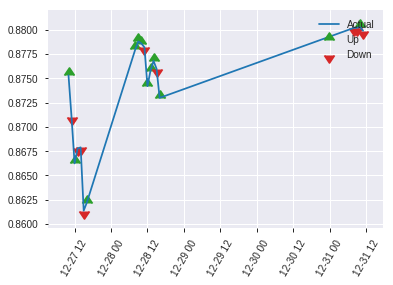


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1897938338236197
RMSE: 0.43565334134334344
LogLoss: 0.5662977090778173
Mean Per-Class Error: 0.2682448979591837
AUC: 0.785795918367347
pr_auc: 0.6868997008984481
Gini: 0.5715918367346939
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40359655022621155: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   45   0.36     (45.0/125.0)
1      18   80   0.1837   (18.0/98.0)
Total  98   125  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403597     0.717489  124
max f2                       0.167467     0.833333  183
max f0point5                 0.622179     0.726601  76
max accuracy                 0.622179     0.744395  76
max precision                0.908481     0.833333  11
max recall                   0.122512     1         204
max specificity              0.94955      0.992     0
max absolute_mcc             0.622179     0.478135  76
max min_per_class_accuracy   0.529666     0.72      105
max mean_per_class_accuracy  0.460146     0.731755  114

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 47.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.940089           0.758503   0.758503           0.333333         0.944907  0.333333                    0.944907            0.0102041       0.0102041                  -24.1497  -24.1497
    2        0.0224215                   0.930556           2.27551    1.36531            1                0.932761  0.6                         0.940048            0.0204082       0.0306122                  127.551   36.5306
    3        0.0313901                   0.923178           2.27551    1.62536            1                0.9267    0.714286                    0.936235            0.0204082       0.0510204                  127.551   62.5364
    4        0.0403587                   0.923049           2.27551    1.76984            1                0.923076  0.777778                    0.933311            0.0204082       0.0714286                  127.551   76.9841
    5        0.0538117                   0.907357           2.27551    1.89626            1                0.916157  0.833333                    0.929022            0.0306122       0.102041                   127.551   89.6259
    6        0.103139                    0.866671           1.65492    1.78083            0.727273         0.886688  0.782609                    0.908775            0.0816327       0.183673                   65.4917   78.0834
    7        0.152466                    0.80192            1.65492    1.7401             0.727273         0.827732  0.764706                    0.882555            0.0816327       0.265306                   65.4917   74.0096
    8        0.201794                    0.740834           1.44805    1.66871            0.636364         0.772083  0.733333                    0.855551            0.0714286       0.336735                   44.8052   66.8707
    9        0.300448                    0.644911           1.65492    1.66418            0.727273         0.684753  0.731343                    0.799468            0.163265        0.5                        65.4917   66.4179
    10       0.399103                    0.581911           1.55148    1.63632            0.681818         0.61561   0.719101                    0.75402             0.153061        0.653061                   55.1484   63.6322
    11       0.502242                    0.477091           0.890417   1.48315            0.391304         0.539085  0.651786                    0.709881            0.0918367       0.744898                   -10.9583  48.3145
    12       0.600897                    0.346993           0.827458   1.37549            0.363636         0.408191  0.604478                    0.66035             0.0816327       0.826531                   -17.2542  37.5495
    13       0.699552                    0.254213           0.620594   1.26903            0.272727         0.299912  0.557692                    0.609519            0.0612245       0.887755                   -37.9406  26.9035
    14       0.798206                    0.188326           0.724026   1.20167            0.318182         0.212895  0.52809                     0.560498            0.0714286       0.959184                   -27.5974  20.1674
    15       0.896861                    0.126954           0.310297   1.10362            0.136364         0.153248  0.485                       0.515701            0.0306122       0.989796                   -68.9703  10.3622
    16       1                           0.0698977          0.0989352  1                  0.0434783        0.105008  0.439462                  

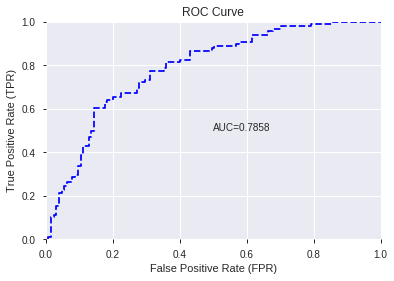

This function is available for GLM models only


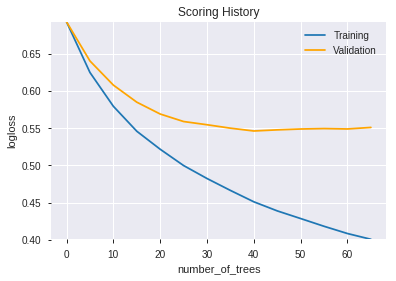

--2019-08-25 17:20:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_172032_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_172032_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8b41',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'BETA_8',
 'DX_24',
 'ADOSC',
 'aroondown_30',
 'ULTOSC',
 'LINEARREG_SLOPE_8',
 'CCI_14',
 'MOM_20',
 'PLUS_DM_30',
 'CCI_8',
 'PLUS_DI_30',
 'HT_DCPERIOD',
 'WILLR_24',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'MA_20_1',
 'PLUS_DM_12',
 'STOCHRSI_fastd',
 'MACDFIX_hist_14',
 'PLUS_DM_14',
 'HT_PHASOR_inphase',
 'ADX_8',
 'aroonup_14',
 'CCI_24',
 'PLUS_DM_8',
 'TRIX_14',
 'MACDEXT_hist',
 'MAVP_20_1',
 'MOM_14',
 'WILLR_30',
 'AROONOSC_12',
 'STOCH_slowd',
 'aroonup_20',
 'aroondown_24',
 'ROCR_30',
 'BBANDS_upperband_20_0_3',
 'BBANDS_lowerband_20_5_5',
 'MACDFIX_14',
 'BBANDS_lowerband_24_0_4',
 'RSI_20',
 'MFI_8',
 'AVGPRICE',
 'BBANDS_lowerband_20_2_5',
 'ROC_12',
 'aroondown_12',
 'BBANDS_middleband_14_6_3',
 'PLUS_DI_14',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_middleband_20_5_4',
 'PLUS_DI_20',
 'CMO_12',
 'MINUS_DI_24',
 'CMO_8',
 'aroonup_24',
 'BBANDS_upperband_20_2_5',
 'MINUS_DI_20',
 'BBANDS_upperband_14_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.762
GLM             0.753
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.762  0.740    0.758
DLF          0.722  0.753    0.722
Fwe          0.731  0.749    0.744
RFE          0.731  0.753    0.744
XGBF         0.753  0.753    0.722





F1


DeepLearning    0.756
GLM             0.749
XGBoost         0.731
dtype: float64

DeepLearning    GLM  XGBoost
All          0.756  0.731    0.722
DLF          0.729  0.740    0.716
Fwe          0.722  0.749    0.731
RFE          0.736  0.741    0.717
XGBF         0.734  0.740    0.716





auc


DeepLearning    0.807
GLM             0.792
XGBoost         0.799
dtype: float64

DeepLearning    GLM  XGBoost
All          0.790  0.792    0.799
DLF          0.802  0.792    0.781
Fwe          0.790  0.786    0.782
RFE          0.792  0.787    0.786
XGBF         0.807  0.792    0.781





logloss


DeepLearning    1.079
GLM             0.562
XGBoost         0.572
dtype: float64

DeepLearning    GLM  XGBoost
All          0.645  0.550    0.544
DLF          1.079  0.561    0.569
Fwe          0.959  0.562    0.572
RFE          0.648  0.560    0.566
XGBF         0.529  0.561    0.569





mean_per_class_error


DeepLearning    0.280
GLM             0.256
XGBoost         0.271
dtype: float64

DeepLearning    GLM  XGBoost
All          0.230  0.256    0.247
DLF          0.277  0.244    0.271
Fwe          0.280  0.242    0.252
RFE          0.258  0.243    0.268
XGBF         0.252  0.244    0.271





rmse


DeepLearning    0.520
GLM             0.436
XGBoost         0.440
dtype: float64

DeepLearning    GLM  XGBoost
All          0.476  0.431    0.426
DLF          0.520  0.436    0.440
Fwe          0.470  0.436    0.440
RFE          0.475  0.433    0.436
XGBF         0.424  0.436    0.440





mse


DeepLearning    0.271
GLM             0.190
XGBoost         0.194
dtype: float64

DeepLearning    GLM  XGBoost
All          0.226  0.185    0.182
DLF          0.271  0.190    0.193
Fwe          0.220  0.190    0.194
RFE          0.225  0.188    0.190
XGBF         0.179  0.190    0.193

{'F1':       DeepLearning    GLM  XGBoost
 All          0.756    NaN      NaN
 DLF          0.729    NaN      NaN
 DLF            NaN  0.740      NaN
 DLF            NaN    NaN    0.716
 All            NaN  0.731      NaN
 All            NaN    NaN    0.722
 XGBF         0.734    NaN      NaN
 XGBF           NaN  0.740      NaN
 XGBF           NaN    NaN    0.716
 Fwe          0.722    NaN      NaN
 Fwe            NaN  0.749      NaN
 Fwe            NaN    NaN    0.731
 RFE          0.736    NaN      NaN
 RFE            NaN  0.741      NaN
 RFE            NaN    NaN    0.717,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.762    NaN      NaN
 DLF          0.722    NaN      NaN
 DLF            NaN  0.753      NaN
 DLF            NaN    NaN    0.722
 All            NaN  0.740      NaN
 All            NaN    NaN    0.758
 XGBF         0.753    NaN      NaN
 XGBF           NaN  0.753      NaN
 XGBF           NaN    NaN    0.722
 Fwe          0.731    NaN      NaN
 Fwe     